# Landfill Sentinel — Looking for Methane Plumes

This notebook is designed to spot signs of methane coming from a landfill.  
Methane is invisible, but satellites like **Sentinel-5P** measure how much methane is in the air above the Earth each day. By combining that data with local wind information, it’s possible to “stack up” many days of observations and reveal patterns that point to a source.

The method used here is called **Wind-Rotated Plume Mapping (WRPM)**.  
The basic idea:
1. Collect daily methane maps from the satellite.  
2. Note which way the wind was blowing each day.  
3. Rotate the maps so that the wind always blows north (straight up).  
4. Average them all together.  
5. Look for a “plume” — higher methane values consistently downwind of the landfill.  

This helps confirm whether a landfill is releasing methane.


In [1]:
import os, io, contextlib
from tempfile import NamedTemporaryFile

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

import folium
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

import rasterio
from rasterio.transform import from_origin
from rasterio import warp
from rasterstats import zonal_stats

import openeo
import cdsapi

from shapely.geometry import shape, Point
from tqdm.notebook import tqdm

from geopy.geocoders import Nominatim

## Connect to OpenEO

The code below establishes a connection with the Copernicus openEO platform which provides a wide variety of earth observation datasets

- If this does not read as 'Authorised successfully' or 'Authenticated using refresh token', then please ensure that you have completed the setup steps as outlined in section 2.6 of the user guide. 

- If you have followed the steps in section 2.6 correctly and the problem persists, please look at https://dataspace.copernicus.eu/news for any information about service interruptions. 

- If there is no news of service problems you can raise a ticket here: https://helpcenter.dataspace.copernicus.eu/hc/en-gb/requests/new

In [2]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Define the study area  
The box below sets the landfill’s latitude and longitude and creates a box around it for collecting satellite data.


In [3]:
# Coordinates + buffer
user_latitude = 36.2392
user_longitude = 59.9882
buffer_degrees = 1

# Label
site_label = f"User site ({user_latitude:.2f},{user_longitude:.2f})"

# Bounding box
spatial_extent = {
    "west":  user_longitude - buffer_degrees,
    "south": user_latitude - buffer_degrees,
    "east":  user_longitude + buffer_degrees,
    "north": user_latitude + buffer_degrees,
}

# Reverse geocode
geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.reverse((user_latitude, user_longitude), exactly_one=True)
place_name = location.address if location else "Unknown location"

# Confirmation message
print(f"Analysis area set around {place_name}")
print(f"Label: {site_label}")
print(f"Spatial Extent: {spatial_extent}")


Analysis area set around دهستان میامی, بخش رضویه, شهرستان مشهد, استان خراسان رضوی, ایران
Label: User site (36.24,59.99)
Spatial Extent: {'west': 58.9882, 'south': 35.2392, 'east': 60.9882, 'north': 37.2392}


## Choosing date and downloading Sentinel-5P datasets

This downloads the methane concentration data for a particular date. The parameter you need to modify before running the code is:

- temporal_extent = ["2023-01-31", "2023-03-12"] (change this to your chosen date range using "YYYY-MM-DD" format)

Please note that the temporal extent dates <u>MUST BE IDENTICAL</u> because we are only choosing a single date.

In [4]:
# Step 4.1 (Report): Data acquisition
# This block handles opening Sentinel-5P CH4 data files and reading the required variables

cube = connection.load_collection(
    collection_id="SENTINEL_5P_L2", 
    temporal_extent = ["2022-01-01", "2024-01-01"],
    spatial_extent=spatial_extent,   # <-- from landfill selection cell
    bands=["CH4"],
)

cube = cube.aggregate_temporal_period(period="day", reducer="mean")
cube.download("Sentinel-5P_Landfill_daily.nc", format="NetCDF")
print(f"Downloaded daily Sentinel-5P CH₄ data for {site_label} at {spatial_extent}")


Downloaded daily Sentinel-5P CH₄ data for User site (36.24,59.99) at {'west': 58.9882, 'south': 35.2392, 'east': 60.9882, 'north': 37.2392}


## Build an unrotated composite (comparison)  
Stacks the daily maps without rotation to show why wind alignment is important.

Wrote oversampled_unrotated_0p01deg.tif  (100 x 100 at 0.01°)


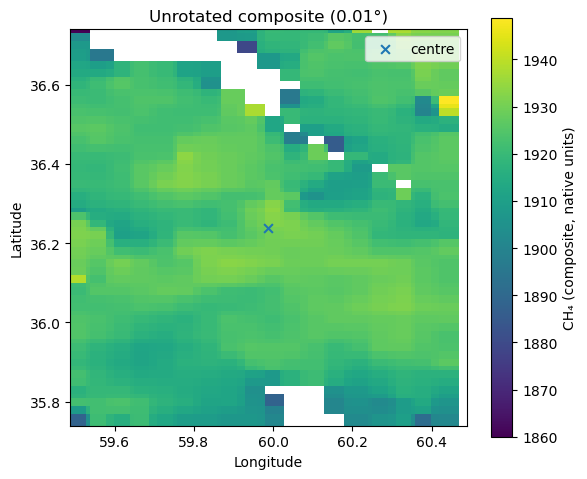

In [19]:
# === Oversampling to 0.01° WITHOUT rotation (comparison) ===
# Inputs:
#   - Sentinel-5P_Landfill_daily.nc    (var=CH4, time dim='t', coords x/y)
# Output:
#   - oversampled_unrotated_0p01deg.tif  (EPSG:4326, 0.01° grid)

# ---- params (match your rotated run) ----
in_nc   = "Sentinel-5P_Landfill_daily.nc"
src_lon, src_lat = user_longitude, user_latitude
box_deg = 0.5      # ~1° x 1° box
step    = 0.01     # oversampling grid resolution in degrees
out_tif = "oversampled_unrotated_0p01deg.tif"
# ----------------------------------------

west, east  = src_lon - box_deg, src_lon + box_deg
south, north = src_lat - box_deg, src_lat + box_deg
nx = int(np.round((east - west) / step))
ny = int(np.round((north - south) / step))
dst_transform = from_origin(west, north, step, step)
dst_crs = rasterio.crs.CRS.from_epsg(4326)

# open dataset
ds = xr.open_dataset(in_nc)
da = ds["CH4"]
lat = da.coords["y"]; lon = da.coords["x"]
times = pd.to_datetime(ds["t"].values)

# native pixel half-sizes in degrees (approx footprint)
dy = float(abs(lat[1] - lat[0])) if lat.size > 1 else 0.1
dx = float(abs(lon[1] - lon[0])) if lon.size > 1 else 0.1
hy = 0.5 * dy
hx = 0.5 * dx
hy_idx = max(1, int(np.ceil(hy / step)))
hx_idx = max(1, int(np.ceil(hx / step)))

# accumulators
sum_grid   = np.zeros((ny, nx), dtype=np.float64)
count_grid = np.zeros((ny, nx), dtype=np.float64)

# loop days: subset → oversample (footprint block) → accumulate
for t in times:
    s = da.sel(t=t)
    # subset to analysis box (respect y ordering)
    if float(lat[0]) > float(lat[-1]):
        s = s.sel({lat.name: slice(north, south), lon.name: slice(west, east)})
    else:
        s = s.sel({lat.name: slice(south, north), lon.name: slice(west, east)})
    if s.size == 0:
        continue

    LON, LAT = np.meshgrid(s[lon.name].values, s[lat.name].values)
    ARR = np.array(s.values, dtype=np.float32)

    # take all finite pixels; footprint clipping will limit to canvas
    valid = np.isfinite(ARR)
    if not np.any(valid):
        continue

    lon_c = LON[valid]; lat_c = LAT[valid]; vals = ARR[valid].astype(np.float64)

    # centre indices on the 0.01° grid (no rotation)
    j0 = np.floor((lon_c - west) / step).astype(int)   # 0..nx-1 (east)
    i0 = np.floor((north - lat_c) / step).astype(int)  # 0..ny-1 (southward)

    # rectangular footprint "splat"
    for ii, jj, v in zip(i0, j0, vals):
        i_min = max(0, ii - hy_idx); i_max = min(ny - 1, ii + hy_idx)
        j_min = max(0, jj - hx_idx); j_max = min(nx - 1, jj + hx_idx)
        if i_min > i_max or j_min > j_max:
            continue
        sum_grid[i_min:i_max+1, j_min:j_max+1]   += v
        count_grid[i_min:i_max+1, j_min:j_max+1] += 1.0

# mean composite
with np.errstate(invalid="ignore", divide="ignore"):
    comp = (sum_grid / count_grid).astype(np.float32)

profile = {
    "driver": "GTiff",
    "height": ny, "width": nx, "count": 1, "dtype": "float32",
    "crs": dst_crs, "transform": dst_transform,
    "compress": "LZW", "tiled": True, "nodata": np.nan,
}
with rasterio.open(out_tif, "w", **profile) as dst:
    dst.write(comp, 1)
    dst.update_tags(method="oversample_no_rotation", grid="0.01deg",
                    bbox=str((west, south, east, north)), step_deg=step)

print(f"Wrote {out_tif}  ({ny} x {nx} at {step}°)")

with rasterio.open(out_tif) as src:
    img = src.read(1)
    bounds = src.bounds

plt.figure(figsize=(6, 5))
im = plt.imshow(
    np.ma.masked_invalid(img),
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin="upper"
)
plt.scatter([src_lon], [src_lat], marker="x", s=40, linewidths=1.5, label="centre")
plt.title("Unrotated composite (0.01°)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.colorbar(im, label="CH₄ (composite, native units)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Add wind information  
Retrieves daily wind speed and direction from ERA5 and matches it to each day’s satellite observation.


In [6]:
# === Annotate NetCDF daily slices with ERA5 wind ===
# Input: Sentinel-5P_Landfill_daily.nc (t dimension = daily slices), landfill centroid
# Output: winds.csv with [date, wind_speed_mps, wind_from_deg]

in_nc = "Sentinel-5P_Landfill_daily.nc"   # downloaded NetCDF
lat, lon = user_latitude, user_longitude

era5_time = "13:00"                        # UTC near S5P overpass
out_csv = "winds.csv"

# open dataset
ds = xr.open_dataset(in_nc)
da = ds["CH4"]        # CH4 variable
times = pd.to_datetime(ds["t"].values)  # 't' is the time dimension
ds.close()

c = cdsapi.Client()
rows = []

for dt in tqdm(times, desc="Fetching ERA5 winds", unit="day"):
    y, m, d = dt.strftime("%Y"), dt.strftime("%m"), dt.strftime("%d")
    with NamedTemporaryFile(suffix=".nc") as tmp_file:
        # silence cdsapi chatter
        with contextlib.redirect_stdout(io.StringIO()):
            r = c.retrieve(
                "reanalysis-era5-single-levels",
                {
                    "product_type": "reanalysis",
                    "variable": ["10m_u_component_of_wind","10m_v_component_of_wind","surface_pressure"],
                    "year": y, "month": m, "day": d,
                    "time": [era5_time],
                    "format": "netcdf",
                    "area": [lat + buffer_degrees, lon - buffer_degrees,
                             lat - buffer_degrees, lon + buffer_degrees],
                },
            )
            r.download(tmp_file.name)
        era = xr.open_dataset(tmp_file.name)
        u10 = era["u10"].sel(latitude=lat, longitude=lon, method="nearest").values.item()
        v10 = era["v10"].sel(latitude=lat, longitude=lon, method="nearest").values.item()
        sp  = era["sp"].sel(latitude=lat, longitude=lon, method="nearest").values.item() 
        era.close()

    wind_speed = float(np.hypot(u10, v10))
    wind_from_deg = float((np.degrees(np.arctan2(-u10, -v10)) + 360.0) % 360.0)

    rows.append({
        "date": dt.date().isoformat(),
        "wind_speed_mps": wind_speed,
        "wind_from_deg": wind_from_deg,
        "surface_pressure_pa": float(sp),
    })

pd.DataFrame(rows).sort_values("date").to_csv(out_csv, index=False)
print(f"Wrote {len(rows)} rows to {out_csv}")



2025-09-30 22:39:51,666 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-30 22:39:51,667 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


Fetching ERA5 winds:   0%|          | 0/591 [00:00<?, ?day/s]

2025-09-30 22:39:52,255 INFO Request ID is 53c7ed65-f24f-4f1f-9516-f850adefaf8f
2025-09-30 22:39:52,507 INFO status has been updated to accepted
2025-09-30 22:40:25,538 INFO status has been updated to running
2025-09-30 22:40:42,700 INFO status has been updated to successful


3397fe12db02c7e64d03a80c34aa6121.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:40:43,947 INFO Request ID is d857e995-a20a-4889-8313-9cafba7dccba
2025-09-30 22:40:44,028 INFO status has been updated to accepted
2025-09-30 22:40:57,512 INFO status has been updated to running
2025-09-30 22:41:05,173 INFO status has been updated to successful


59544e5ff680c5ed4926cd27364487ef.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:41:06,227 INFO Request ID is 1192de28-12c3-4dfa-88ab-8e63c2686f5c
2025-09-30 22:41:06,303 INFO status has been updated to accepted
2025-09-30 22:41:19,928 INFO status has been updated to running
2025-09-30 22:41:27,641 INFO status has been updated to successful


c1689e8d2f034a76cc82b0c2a1101157.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:41:28,494 INFO Request ID is 724ae9c3-644b-4ac1-9994-c1e989a73da7
2025-09-30 22:41:28,556 INFO status has been updated to accepted
2025-09-30 22:41:42,141 INFO status has been updated to running
2025-09-30 22:42:01,254 INFO status has been updated to successful


c96c45e1ffda1c11b653d333b07f22d7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:42:02,256 INFO Request ID is 504c0460-3e0a-4b40-ac17-02fb75dec41a
2025-09-30 22:42:02,313 INFO status has been updated to accepted
2025-09-30 22:42:15,891 INFO status has been updated to running
2025-09-30 22:42:23,574 INFO status has been updated to successful


d6e27508cf727506c813e630f1dfe0d3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:42:25,144 INFO Request ID is a618f9ee-8e4e-4b05-9e8c-845d4039f5d1
2025-09-30 22:42:25,291 INFO status has been updated to accepted
2025-09-30 22:42:58,099 INFO status has been updated to successful


1fd0cb570066a0a25ad89fb241acbf37.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

Recovering from connection error [('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))], attempt 1 of 500
Retrying in 120 seconds


1fd0cb570066a0a25ad89fb241acbf37.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:45:18,592 INFO Request ID is 2790d418-9ffb-4128-9607-7602949057de
2025-09-30 22:45:18,668 INFO status has been updated to accepted
2025-09-30 22:45:32,373 INFO status has been updated to successful


f2601a98a1ba28e0a7b89b1a2935ac3f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:45:33,346 INFO Request ID is c4a210f1-f962-42cc-a8c5-355d65424f66
2025-09-30 22:45:33,403 INFO status has been updated to accepted
2025-09-30 22:45:46,931 INFO status has been updated to running
2025-09-30 22:45:54,608 INFO status has been updated to successful


be10c89289dabe4dc015028e76f8aad6.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:45:55,460 INFO Request ID is b1e182bd-5f5c-494f-bfef-55748df99962
2025-09-30 22:45:55,649 INFO status has been updated to accepted
2025-09-30 22:46:16,851 INFO status has been updated to successful


66f69d4627cee8d891a4abf6dbc95a3e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:46:17,715 INFO Request ID is cd122189-8b5f-4687-a904-411b4f243e59
2025-09-30 22:46:17,778 INFO status has been updated to accepted
2025-09-30 22:46:39,123 INFO status has been updated to successful


48fb6d9cbd65ab12b840ed3f5a990cdf.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:46:40,197 INFO Request ID is 502abc1a-8bfe-4a2f-804c-dd89824e0e5f
2025-09-30 22:46:40,270 INFO status has been updated to accepted
2025-09-30 22:46:48,730 INFO status has been updated to running
2025-09-30 22:47:12,967 INFO status has been updated to successful


7bef1bc010512628a60194c5e983ef9e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:47:13,886 INFO Request ID is f448d2e6-b4b5-4dfb-9935-eaf5a7412c85
2025-09-30 22:47:13,950 INFO status has been updated to accepted
2025-09-30 22:47:27,506 INFO status has been updated to running
2025-09-30 22:47:35,240 INFO status has been updated to successful


812d99a90ddb515d4bd7dad7d20f4782.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:47:36,111 INFO Request ID is dc4d969b-14f6-4822-8b14-c5c546df5984
2025-09-30 22:47:36,257 INFO status has been updated to accepted
2025-09-30 22:48:09,191 INFO status has been updated to running
2025-09-30 22:48:26,385 INFO status has been updated to successful


d656b58cf6a8dea66d2215eb73e1222.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:48:27,263 INFO Request ID is b117cb95-6864-425a-aa04-5de41fbc00c9
2025-09-30 22:48:27,341 INFO status has been updated to accepted
2025-09-30 22:48:41,055 INFO status has been updated to running
2025-09-30 22:48:48,730 INFO status has been updated to accepted
2025-09-30 22:49:00,185 INFO status has been updated to successful


44982ea08e1a7bce33d8e3ed012e5ca1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:49:01,104 INFO Request ID is 02ced152-1397-42ba-a97d-2a732c8ad6f8
2025-09-30 22:49:01,432 INFO status has been updated to accepted
2025-09-30 22:49:14,989 INFO status has been updated to running
2025-09-30 22:49:22,660 INFO status has been updated to successful


fb152fb46d5b456fd9fe0323193d1598.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:49:23,766 INFO Request ID is a377a566-fb72-40a3-b50a-849bc8a4bb76
2025-09-30 22:49:23,839 INFO status has been updated to accepted
2025-09-30 22:49:37,539 INFO status has been updated to running
2025-09-30 22:49:45,199 INFO status has been updated to successful


3bc70621172024f07140c273508cd733.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:49:46,487 INFO Request ID is 50df6229-1545-4770-9259-201e357c53ec
2025-09-30 22:49:46,572 INFO status has been updated to accepted
2025-09-30 22:50:00,367 INFO status has been updated to running
2025-09-30 22:50:36,777 INFO status has been updated to successful


5d4c5cea96b1d8bcec43e536469b1760.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:50:37,673 INFO Request ID is 14e2818d-3017-4c13-95d7-4f55d217c144
2025-09-30 22:50:37,760 INFO status has been updated to accepted
2025-09-30 22:50:51,315 INFO status has been updated to running
2025-09-30 22:50:58,983 INFO status has been updated to successful


fa660202f0a84ab1686aee88cde1cb6c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:50:59,882 INFO Request ID is d5f02d82-41d0-4bd1-9de9-290f69eca56c
2025-09-30 22:50:59,994 INFO status has been updated to accepted
2025-09-30 22:51:21,173 INFO status has been updated to successful


ef90a5bdd675af9134b369c803511aaa.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:51:22,028 INFO Request ID is b604decd-d46f-487f-ba12-612aa02eb1ea
2025-09-30 22:51:22,107 INFO status has been updated to accepted
2025-09-30 22:51:35,943 INFO status has been updated to running
2025-09-30 22:51:43,614 INFO status has been updated to successful


951193fc6215a97610a8af356d53d6b7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:51:45,139 INFO Request ID is 01677969-d4ce-451d-bcc2-968a747b93f3
2025-09-30 22:51:45,204 INFO status has been updated to accepted
2025-09-30 22:51:58,757 INFO status has been updated to running
2025-09-30 22:52:17,867 INFO status has been updated to successful


ace112c873c0be67759854883b596cfa.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:52:18,838 INFO Request ID is a66502ad-675f-415a-bffc-f2b3dec51b2c
2025-09-30 22:52:18,909 INFO status has been updated to accepted
2025-09-30 22:52:40,154 INFO status has been updated to successful


efee29f9227355fb01b4ad50c5bb28f4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:52:41,312 INFO Request ID is a1f82123-e9ca-4176-9f6e-a4df1b2e1931
2025-09-30 22:52:41,575 INFO status has been updated to accepted
2025-09-30 22:52:49,988 INFO status has been updated to running
2025-09-30 22:52:55,125 INFO status has been updated to successful


1741f903f011cb93b0dcaf53bb6f087.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:52:55,998 INFO Request ID is 83f0f24d-54f6-44e6-9fd3-c8650e169c67
2025-09-30 22:52:56,064 INFO status has been updated to accepted
2025-09-30 22:53:04,471 INFO status has been updated to running
2025-09-30 22:53:09,597 INFO status has been updated to successful


3ec57b5f978d89798b62243823eeb30f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:53:10,746 INFO Request ID is eecb9e94-ffe5-44c3-9be9-17e452e307ff
2025-09-30 22:53:10,813 INFO status has been updated to accepted
2025-09-30 22:53:19,230 INFO status has been updated to running
2025-09-30 22:53:24,363 INFO status has been updated to successful


9f1b8709fe6af36f1950093d65f23d4a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:53:25,272 INFO Request ID is d32dc048-15ec-4a6b-9016-e3c211c85e1b
2025-09-30 22:53:25,334 INFO status has been updated to accepted
2025-09-30 22:53:33,780 INFO status has been updated to running
2025-09-30 22:53:46,698 INFO status has been updated to successful


8b1802517e28a028dba7dcdb65871378.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:53:47,603 INFO Request ID is fdab6d12-3091-4671-a6df-ad8cc8df50ec
2025-09-30 22:53:47,687 INFO status has been updated to accepted
2025-09-30 22:54:01,239 INFO status has been updated to running
2025-09-30 22:54:08,917 INFO status has been updated to successful


8a2c4e4f296eaffd9885341965df38e8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:54:10,048 INFO Request ID is d7a57a6c-3d0b-4eac-ac84-7a3d7a816a9e
2025-09-30 22:54:10,115 INFO status has been updated to accepted
2025-09-30 22:54:18,692 INFO status has been updated to running
2025-09-30 22:54:23,819 INFO status has been updated to successful


f6173e9043a2bddc754a88a646801042.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:54:25,056 INFO Request ID is 10430f91-56f5-4267-9736-736bf500d627
2025-09-30 22:54:25,117 INFO status has been updated to accepted
2025-09-30 22:54:33,588 INFO status has been updated to running
2025-09-30 22:54:38,714 INFO status has been updated to successful


538aa7822623f5582f4db10277b74213.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:54:39,599 INFO Request ID is b56032ef-b88e-4fb3-9d01-fbe00d1bbc00
2025-09-30 22:54:39,658 INFO status has been updated to accepted
2025-09-30 22:54:53,222 INFO status has been updated to successful


7c60f2a5490d4e7b5e50a770fd88c5a2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:54:54,420 INFO Request ID is ce632230-8553-4ca5-b75f-51004226bc53
2025-09-30 22:54:54,518 INFO status has been updated to accepted
2025-09-30 22:55:08,214 INFO status has been updated to successful


f6e5d5dfbb6407c5869eff73eb4868c8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:55:09,093 INFO Request ID is 857259ff-8527-4431-887c-d1830dd6b798
2025-09-30 22:55:09,157 INFO status has been updated to accepted
2025-09-30 22:55:22,685 INFO status has been updated to successful


91c7d32adc619dc11ab25beb5486c681.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:55:23,581 INFO Request ID is c72ca1a5-2cef-46ea-9a83-3f0b89c84a15
2025-09-30 22:55:23,646 INFO status has been updated to accepted
2025-09-30 22:55:37,354 INFO status has been updated to running
2025-09-30 22:55:56,489 INFO status has been updated to successful


a644b1b6269334b9c59d65e5f41c0691.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:55:57,877 INFO Request ID is 752cfad9-43db-4b8f-82f6-1bd40299f707
2025-09-30 22:55:57,942 INFO status has been updated to accepted
2025-09-30 22:56:19,356 INFO status has been updated to successful


d841f4210bd6c2deb8062b612c0a6118.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:56:20,451 INFO Request ID is 41cb777e-ea5f-4584-9314-c607024c747b
2025-09-30 22:56:20,505 INFO status has been updated to accepted
2025-09-30 22:56:29,021 INFO status has been updated to running
2025-09-30 22:56:34,137 INFO status has been updated to successful


57bb14d403400524326c9987b01492bc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:56:35,048 INFO Request ID is 4d4edd58-3597-4340-be6c-ede5fe966e0e
2025-09-30 22:56:35,127 INFO status has been updated to accepted
2025-09-30 22:57:07,787 INFO status has been updated to successful


eab06db902f9103e332fed4f482018c5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:57:08,755 INFO Request ID is a20bf00e-7ab1-4442-9381-00169a184d2a
2025-09-30 22:57:08,834 INFO status has been updated to accepted
2025-09-30 22:57:30,165 INFO status has been updated to successful


54bf48380303533064bc94e7f2a7c1ad.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:57:31,286 INFO Request ID is f7e165d7-a54d-40e4-a474-c04b4a7e3682
2025-09-30 22:57:31,349 INFO status has been updated to accepted
2025-09-30 22:57:39,783 INFO status has been updated to running
2025-09-30 22:57:44,935 INFO status has been updated to successful


d573b825a3bffd0502c366c709416f77.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:57:45,799 INFO Request ID is dfd67cd2-d867-4dc9-887a-dd96cec69960
2025-09-30 22:57:45,880 INFO status has been updated to accepted
2025-09-30 22:57:54,461 INFO status has been updated to running
2025-09-30 22:58:07,253 INFO status has been updated to successful


755109b4ba6517444388dfd916b60603.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:58:08,097 INFO Request ID is 43f3862f-3f49-4d4b-952a-823936a078f7
2025-09-30 22:58:08,161 INFO status has been updated to accepted
2025-09-30 22:58:21,927 INFO status has been updated to running
2025-09-30 22:58:29,589 INFO status has been updated to successful


7eaaf85741ceb2cf72fec65424ea6d78.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:58:30,760 INFO Request ID is 667dae72-2afa-498d-b631-61957d36829b
2025-09-30 22:58:30,988 INFO status has been updated to accepted
2025-09-30 22:58:44,569 INFO status has been updated to running
2025-09-30 22:59:03,686 INFO status has been updated to successful


f9c048e9b2200cabd1bbd036ac653e0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:59:04,629 INFO Request ID is 1407d697-f176-40bf-8bb7-bbab81a153b4
2025-09-30 22:59:04,707 INFO status has been updated to accepted
2025-09-30 22:59:25,976 INFO status has been updated to successful


56dd9c949a6dc3cfd785d71c5cc5a334.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:59:26,870 INFO Request ID is 8cc1ab45-0d1e-4891-abcf-fba64ad7c5a8
2025-09-30 22:59:26,935 INFO status has been updated to accepted
2025-09-30 22:59:35,407 INFO status has been updated to running
2025-09-30 22:59:40,559 INFO status has been updated to successful


ebff326a948ff278eba76d922b813f5c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 22:59:41,739 INFO Request ID is 1667a571-d6c3-4d90-9cc5-bb00b31d549f
2025-09-30 22:59:41,820 INFO status has been updated to accepted
2025-09-30 22:59:55,755 INFO status has been updated to running
2025-09-30 23:00:03,440 INFO status has been updated to successful


e3dd187ead824d61c10433801ca417de.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:00:04,435 INFO Request ID is fa01e602-80f6-4988-afe5-aa53bcf8c4be
2025-09-30 23:00:04,499 INFO status has been updated to accepted
2025-09-30 23:00:37,404 INFO status has been updated to successful


98d8b427c951d54579c650cd14382edc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:00:38,370 INFO Request ID is 3c8de13d-0446-42c6-808c-5aadd059cd30
2025-09-30 23:00:38,459 INFO status has been updated to accepted
2025-09-30 23:00:46,959 INFO status has been updated to running
2025-09-30 23:00:52,091 INFO status has been updated to successful


ad05b810497832fba5289b8dfcd2c2c6.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:00:53,265 INFO Request ID is c6a061ec-bb4a-4be7-a879-c42b77954afa
2025-09-30 23:00:53,360 INFO status has been updated to accepted
2025-09-30 23:01:01,794 INFO status has been updated to running
2025-09-30 23:01:06,934 INFO status has been updated to successful


2694094976045528a538e3a62175181e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:01:07,978 INFO Request ID is 11731f52-cd37-4841-90d5-1e0253e67db1
2025-09-30 23:01:08,042 INFO status has been updated to accepted
2025-09-30 23:01:21,561 INFO status has been updated to running
2025-09-30 23:01:29,263 INFO status has been updated to successful


e6b448918588d89940dfd6b257b074ae.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:01:30,182 INFO Request ID is 0e445a5a-396d-4ce2-83f8-7ac3a4c74a40
2025-09-30 23:01:30,245 INFO status has been updated to accepted
2025-09-30 23:01:38,627 INFO status has been updated to running
2025-09-30 23:01:51,420 INFO status has been updated to successful


f604eb28022928d603927eb20ddbbe77.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:01:52,456 INFO Request ID is 08bdcdb9-35d8-4bd0-b363-538be427c805
2025-09-30 23:01:52,519 INFO status has been updated to accepted
2025-09-30 23:02:01,022 INFO status has been updated to running
2025-09-30 23:02:06,174 INFO status has been updated to successful


e88b053a0aa1be639eeafaf478e45291.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:02:07,290 INFO Request ID is d0a97f23-88bc-4463-badd-7217bc75f639
2025-09-30 23:02:07,375 INFO status has been updated to accepted
2025-09-30 23:02:20,913 INFO status has been updated to running
2025-09-30 23:02:28,596 INFO status has been updated to successful


bdf4aed6d1fbaef9fba3c7c0ea51a9a4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:02:29,555 INFO Request ID is 06101815-facc-4c7b-b850-5c055bff85c4
2025-09-30 23:02:29,624 INFO status has been updated to accepted
2025-09-30 23:02:43,132 INFO status has been updated to running
2025-09-30 23:02:50,798 INFO status has been updated to successful


12a3f4c6c250710be0aec302cc667d9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:02:51,885 INFO Request ID is 28431d52-0f5b-42b1-8119-fb43ca397468
2025-09-30 23:02:51,950 INFO status has been updated to accepted
2025-09-30 23:03:13,425 INFO status has been updated to successful


b963dfc7b1d2ec89848ec6b2e7ca4091.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:03:14,311 INFO Request ID is cf039aa2-564f-4a0f-aea4-95ec081ef148
2025-09-30 23:03:14,374 INFO status has been updated to accepted
2025-09-30 23:03:28,086 INFO status has been updated to successful


af2cd307ce6b4bbfa10a765603a152b9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:03:29,005 INFO Request ID is eb7ca21a-55ea-41a6-9a15-72a3b93c25bf
2025-09-30 23:03:29,069 INFO status has been updated to accepted
2025-09-30 23:03:42,639 INFO status has been updated to successful


1e34c733759e9ae508b274668587ace2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:03:43,508 INFO Request ID is b0d476d4-7a12-431a-8034-b48a21da5e44
2025-09-30 23:03:43,572 INFO status has been updated to accepted
2025-09-30 23:04:05,019 INFO status has been updated to successful


77f95481116678f253c990863bb012fb.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:04:07,096 INFO Request ID is 10419100-9535-4304-87f9-df383c9b2ec5
2025-09-30 23:04:07,150 INFO status has been updated to accepted
2025-09-30 23:04:20,868 INFO status has been updated to successful


79b26f711af4e4fb175d93ed5dd2a2d0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:04:22,354 INFO Request ID is 4c3d6174-4248-47d1-9bbb-d55f15e789e5
2025-09-30 23:04:22,726 INFO status has been updated to accepted
2025-09-30 23:04:36,226 INFO status has been updated to running
2025-09-30 23:04:43,922 INFO status has been updated to successful


6a1727014b43b2e4063880ab644e59d3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:04:44,832 INFO Request ID is 36e8e034-cc0e-4d89-885f-d632e45bf427
2025-09-30 23:04:44,914 INFO status has been updated to accepted
2025-09-30 23:04:58,721 INFO status has been updated to running
2025-09-30 23:05:06,384 INFO status has been updated to successful


15e3cdbb1778e5bffbe1433cdfb4f462.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:05:07,229 INFO Request ID is ba40e166-116a-4d8b-8ace-55bb89e59ecc
2025-09-30 23:05:07,310 INFO status has been updated to accepted
2025-09-30 23:05:20,828 INFO status has been updated to running
2025-09-30 23:05:28,487 INFO status has been updated to successful


246b4053cad95c9bdd8ab23e44b6ed09.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:05:29,385 INFO Request ID is 2821fe5f-4b0b-4b5d-8bb5-13a8f366b946
2025-09-30 23:05:29,449 INFO status has been updated to accepted
2025-09-30 23:06:02,188 INFO status has been updated to successful


226b3973d64edc4bd53175d601296dc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:06:03,113 INFO Request ID is b5044d5f-5961-46f6-abc8-e3178d97338b
2025-09-30 23:06:03,176 INFO status has been updated to accepted
2025-09-30 23:06:16,736 INFO status has been updated to running
2025-09-30 23:06:24,405 INFO status has been updated to accepted
2025-09-30 23:06:35,865 INFO status has been updated to successful


d5d5f838c6c02f0b180569169162c8ad.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:06:37,031 INFO Request ID is aa6005c0-185d-40ed-84f5-dd9b5e9dd396
2025-09-30 23:06:37,143 INFO status has been updated to accepted
2025-09-30 23:06:50,776 INFO status has been updated to running
2025-09-30 23:06:58,432 INFO status has been updated to successful


782035b947799b72762e0f308662bcce.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:06:59,624 INFO Request ID is c88c4a5c-1bbb-44b6-9272-faf5b1ff2e9b
2025-09-30 23:06:59,686 INFO status has been updated to accepted
2025-09-30 23:07:13,242 INFO status has been updated to running
2025-09-30 23:07:20,941 INFO status has been updated to successful


3a5edfaee8b58aac564f2d81585a1ea8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:07:21,932 INFO Request ID is e1f3b2ac-933b-41eb-b55e-b6cb2aff2d8a
2025-09-30 23:07:21,997 INFO status has been updated to accepted
2025-09-30 23:07:30,443 INFO status has been updated to running
2025-09-30 23:07:35,577 INFO status has been updated to successful


1e28a5c17a9baf0399598283506b5744.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:07:36,485 INFO Request ID is 243e119a-6039-4617-a00c-abd905168b28
2025-09-30 23:07:36,548 INFO status has been updated to accepted
2025-09-30 23:07:45,535 INFO status has been updated to running
2025-09-30 23:07:50,661 INFO status has been updated to successful


7b3958447608342547dc1da3d36fd4a8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:07:51,523 INFO Request ID is 87029565-ca88-4218-952b-19e2cf8280d7
2025-09-30 23:07:51,601 INFO status has been updated to accepted
2025-09-30 23:08:00,669 INFO status has been updated to running
2025-09-30 23:08:05,800 INFO status has been updated to accepted
2025-09-30 23:08:24,911 INFO status has been updated to successful


398038de18e4967af36864cdb9fced6b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:08:26,442 INFO Request ID is 956b550f-7f9d-4e67-9328-38a2c2ff7c75
2025-09-30 23:08:26,649 INFO status has been updated to accepted
2025-09-30 23:08:40,171 INFO status has been updated to running
2025-09-30 23:08:59,368 INFO status has been updated to successful


6d2a39219427e28737861c6f638b1f8f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:09:01,217 INFO Request ID is 96e57973-ccbb-4fb7-9cc8-347768c88008
2025-09-30 23:09:01,281 INFO status has been updated to accepted
2025-09-30 23:09:14,840 INFO status has been updated to successful


81c3135780e6be5b2fa8548bdc9a96ca.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:09:15,974 INFO Request ID is 9f0434ef-220e-4962-841c-c438890e011d
2025-09-30 23:09:16,036 INFO status has been updated to accepted
2025-09-30 23:10:06,783 INFO status has been updated to successful


8f627ecebea1f10ce8d15453e459d071.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

Recovering from connection error [('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))], attempt 1 of 500
Retrying in 120 seconds


8f627ecebea1f10ce8d15453e459d071.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:12:27,241 INFO Request ID is 0ae61d5b-10c7-4704-b8ea-bdcb3a9a0b3f
2025-09-30 23:12:27,433 INFO status has been updated to accepted
2025-09-30 23:12:36,176 INFO status has been updated to running
2025-09-30 23:12:41,317 INFO status has been updated to successful


90f84ca29bdd46167dcdbef83a57ee35.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:12:44,134 INFO Request ID is 37c7309f-f6a3-421d-94da-1665dd66725f
2025-09-30 23:12:44,230 INFO status has been updated to accepted
2025-09-30 23:12:52,695 INFO status has been updated to running
2025-09-30 23:12:57,843 INFO status has been updated to successful


9fe2942155b5181d8cdfff65845e3a65.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:12:58,866 INFO Request ID is d479c5ca-c461-43da-b6d1-89059fca51ff
2025-09-30 23:12:58,950 INFO status has been updated to accepted
2025-09-30 23:13:31,937 INFO status has been updated to successful


690d83a401ac46fa13fa6de1f0a2ab1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:13:33,263 INFO Request ID is 21962aac-711d-4a70-8fd8-65d41d1a6e0f
2025-09-30 23:13:33,359 INFO status has been updated to accepted
2025-09-30 23:14:07,058 INFO status has been updated to running
2025-09-30 23:14:24,284 INFO status has been updated to successful


387ec6f2884e5e8b071258bdb2931097.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:14:26,103 INFO Request ID is 7e3d2340-a016-4310-9f1a-ce565b61b906
2025-09-30 23:14:26,168 INFO status has been updated to accepted
2025-09-30 23:14:40,245 INFO status has been updated to running
2025-09-30 23:14:47,979 INFO status has been updated to successful


7c986297d0a1c0aac5c4c75141c98354.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:14:49,126 INFO Request ID is f1369fcb-db2e-4cd6-825f-5233c4245d4e
2025-09-30 23:14:49,255 INFO status has been updated to accepted
2025-09-30 23:14:58,311 INFO status has been updated to running
2025-09-30 23:15:03,495 INFO status has been updated to successful


119177521baf6a51efdfb1ce5bad7923.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:15:04,522 INFO Request ID is 50f0092e-051b-450d-b9ea-e05ece5d181f
2025-09-30 23:15:04,745 INFO status has been updated to accepted
2025-09-30 23:15:13,141 INFO status has been updated to running
2025-09-30 23:15:26,033 INFO status has been updated to successful


df305f672ff7862e33f9bef6968d291b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:15:28,002 INFO Request ID is e0c97411-bbe2-4cbc-b31c-fb12d055ab7b
2025-09-30 23:15:28,080 INFO status has been updated to accepted
2025-09-30 23:15:41,593 INFO status has been updated to successful


55507d303a44178634aa31721de51e43.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:15:42,619 INFO Request ID is ada5aa33-3d15-4036-8902-c8cdbf9ad176
2025-09-30 23:15:42,713 INFO status has been updated to accepted
2025-09-30 23:15:56,424 INFO status has been updated to successful


307be5fc83f6b29b1adeb3e1fed8cca3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:15:57,333 INFO Request ID is c69567f5-849b-44f3-85f9-fb4d5a31b1d7
2025-09-30 23:15:57,428 INFO status has been updated to accepted
2025-09-30 23:16:05,836 INFO status has been updated to running
2025-09-30 23:16:18,615 INFO status has been updated to successful


88356530c44293c0754fcb4e862f6ae5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:16:19,500 INFO Request ID is 2e327054-7e29-4725-8caa-8edf31d6b039
2025-09-30 23:16:19,580 INFO status has been updated to accepted
2025-09-30 23:16:33,104 INFO status has been updated to running
2025-09-30 23:16:40,781 INFO status has been updated to accepted
2025-09-30 23:16:52,242 INFO status has been updated to successful


51b4480b701878a92bf1ee1f4ea1d0a4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:16:53,397 INFO Request ID is 5d1061f4-fa22-4d4e-b953-d8f80bc938eb
2025-09-30 23:16:53,461 INFO status has been updated to accepted
2025-09-30 23:17:07,050 INFO status has been updated to running
2025-09-30 23:17:14,727 INFO status has been updated to successful


510e333cff0256b11e5b6edc66dfacff.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:17:16,573 INFO Request ID is 52d6c776-2ed0-49e5-ae36-1718dd0a2d41
2025-09-30 23:17:16,637 INFO status has been updated to accepted
2025-09-30 23:17:49,504 INFO status has been updated to successful


7ebd22c1dc1ae01285c108177753b9a3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:17:50,509 INFO Request ID is 1e2b1c01-d5de-451e-9fdf-13be94d1c024
2025-09-30 23:17:50,572 INFO status has been updated to accepted
2025-09-30 23:18:04,202 INFO status has been updated to running
2025-09-30 23:18:11,877 INFO status has been updated to successful


244fd767989846e0c3211908266b2a0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:18:13,530 INFO Request ID is d85513a4-7442-49e3-b027-b276a4343c33
2025-09-30 23:18:13,720 INFO status has been updated to accepted
2025-09-30 23:18:22,176 INFO status has been updated to running
2025-09-30 23:18:34,974 INFO status has been updated to successful


8264b30521405704bb525af1d7354a3f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:18:35,862 INFO Request ID is ba3e882e-59cb-4efc-998e-6d46d7dd7e98
2025-09-30 23:18:36,020 INFO status has been updated to accepted
2025-09-30 23:18:44,549 INFO status has been updated to running
2025-09-30 23:18:49,682 INFO status has been updated to successful


78f3d842e0742f81f22fc32d583061fb.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:18:51,040 INFO Request ID is fdab85d2-2724-4ee8-a2f3-427bc3a66a95
2025-09-30 23:18:51,135 INFO status has been updated to accepted
2025-09-30 23:19:12,435 INFO status has been updated to successful


2ac11028865d3694607ba68691c0e397.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:19:13,505 INFO Request ID is 7bde7185-cdc8-4ff9-b755-d538822a9e6f
2025-09-30 23:19:13,584 INFO status has been updated to accepted
2025-09-30 23:19:22,117 INFO status has been updated to running
2025-09-30 23:19:27,273 INFO status has been updated to successful


b9651b8b122b33efcd3a0c8f50889cfd.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:19:28,280 INFO Request ID is 83067b64-0402-497c-9868-702e888388c4
2025-09-30 23:19:28,360 INFO status has been updated to accepted
2025-09-30 23:19:42,392 INFO status has been updated to running
2025-09-30 23:19:50,051 INFO status has been updated to successful


28989538989f901a566f0bd99956120f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:19:51,249 INFO Request ID is 7257d315-1c7b-43d0-be36-41862452b15d
2025-09-30 23:19:51,329 INFO status has been updated to accepted
2025-09-30 23:19:59,786 INFO status has been updated to running
2025-09-30 23:20:04,925 INFO status has been updated to successful


ea3667e20aa0d5f6de6365e6cb1c71f0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:20:06,244 INFO Request ID is 70ad02fa-075b-4c9e-be99-9890e82141d8
2025-09-30 23:20:06,403 INFO status has been updated to accepted
2025-09-30 23:20:14,786 INFO status has been updated to running
2025-09-30 23:20:19,943 INFO status has been updated to successful


6fecba55f5c19f8eac0fc3bfb6a4ce27.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:20:21,844 INFO Request ID is 6bc3444a-de24-45b0-a38c-ee177c7f9431
2025-09-30 23:20:21,923 INFO status has been updated to accepted
2025-09-30 23:20:30,406 INFO status has been updated to running
2025-09-30 23:20:43,202 INFO status has been updated to successful


8909a2971cd49b1e8edf1c5719bfd124.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:20:44,094 INFO Request ID is d565708f-6280-4836-b10c-4c1d414c4717
2025-09-30 23:20:44,157 INFO status has been updated to accepted
2025-09-30 23:20:57,715 INFO status has been updated to running
2025-09-30 23:21:05,440 INFO status has been updated to successful


c59b4282f8a7b8226ce4526e2954d3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:21:07,046 INFO Request ID is 5f02e14d-d0ce-477a-8906-633fc45184ce
2025-09-30 23:21:07,112 INFO status has been updated to accepted
2025-09-30 23:21:28,353 INFO status has been updated to successful


987d43a28e1789a5f6bb542e064ef365.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:21:29,375 INFO Request ID is c9d37f73-2444-481e-a391-875a63f91274
2025-09-30 23:21:29,456 INFO status has been updated to accepted
2025-09-30 23:21:38,068 INFO status has been updated to running
2025-09-30 23:21:43,209 INFO status has been updated to accepted
2025-09-30 23:21:50,939 INFO status has been updated to successful


2d08a3d95d11d3a2584171d8179204cc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:21:51,958 INFO Request ID is 9600bad6-ed44-4895-9a90-5d18d1e2ab43
2025-09-30 23:21:52,022 INFO status has been updated to accepted
2025-09-30 23:22:06,067 INFO status has been updated to successful


90f34edec3eda68abeec7b94f279ce1e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:22:07,170 INFO Request ID is c08dedea-6681-443c-ab8d-398f086e46dc
2025-09-30 23:22:07,251 INFO status has been updated to accepted
2025-09-30 23:22:15,675 INFO status has been updated to running
2025-09-30 23:22:20,798 INFO status has been updated to successful


8985111ef9cd57afd1fbd17b15200c76.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:22:21,900 INFO Request ID is d0a3fede-5d02-4286-b9f3-a0760d9e6df2
2025-09-30 23:22:21,979 INFO status has been updated to accepted
2025-09-30 23:22:54,877 INFO status has been updated to successful


b1265e6d6b59f641b99e5b411a86e02.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:22:55,962 INFO Request ID is 090716ad-dd95-476e-88b8-958eb5cd0f99
2025-09-30 23:22:56,059 INFO status has been updated to accepted
2025-09-30 23:23:09,689 INFO status has been updated to running
2025-09-30 23:23:28,833 INFO status has been updated to successful


20f8bc6f186abcd2d0b57b69e6ccf68.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:23:29,730 INFO Request ID is 8e050145-434c-4648-adf3-578fe65083eb
2025-09-30 23:23:29,809 INFO status has been updated to accepted
2025-09-30 23:23:43,788 INFO status has been updated to running
2025-09-30 23:23:51,449 INFO status has been updated to successful


96ac1b663b46bec2a97c173629cbd7a3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:23:52,793 INFO Request ID is 2663779e-a2a3-4bd7-9af5-8b38003c4e63
2025-09-30 23:23:52,854 INFO status has been updated to accepted
2025-09-30 23:24:06,542 INFO status has been updated to running
2025-09-30 23:24:14,293 INFO status has been updated to successful


b9ae6901a91bbd37f6a847ff40d14cba.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:24:15,508 INFO Request ID is 4d0c4ae9-83ed-44e7-a07f-804dc46035bb
2025-09-30 23:24:15,667 INFO status has been updated to accepted
2025-09-30 23:24:29,218 INFO status has been updated to running
2025-09-30 23:24:36,875 INFO status has been updated to successful


e8d5c3bce74ce99fc5ecf3f45f5d0f21.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:24:37,777 INFO Request ID is e0088aab-be13-4745-8b14-8f9a31edac12
2025-09-30 23:24:37,857 INFO status has been updated to accepted
2025-09-30 23:24:51,431 INFO status has been updated to running
2025-09-30 23:24:59,090 INFO status has been updated to successful


51ee455d0d033029c69e323051791d15.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:24:59,997 INFO Request ID is 34217e54-30f2-4dc9-96d4-c3a12510540b
2025-09-30 23:25:00,078 INFO status has been updated to accepted
2025-09-30 23:25:13,662 INFO status has been updated to successful


1ced1ab975368cd865a80bdc48f01e26.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:25:14,680 INFO Request ID is 0947a42b-80f4-476a-8d7e-4ec93bd5d9f9
2025-09-30 23:25:15,744 INFO status has been updated to accepted
2025-09-30 23:25:29,270 INFO status has been updated to running
2025-09-30 23:25:36,971 INFO status has been updated to successful


34cadb444cf07a66d6460090185120b3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:25:37,900 INFO Request ID is bd86adc7-8c64-401f-af93-6bad9f5f8a21
2025-09-30 23:25:37,979 INFO status has been updated to accepted
2025-09-30 23:25:51,656 INFO status has been updated to successful


6908772f2fcb272b553eea5575130bef.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:25:52,876 INFO Request ID is ace5979a-6f71-48d8-ae90-a8ef0be25dea
2025-09-30 23:25:52,942 INFO status has been updated to accepted
2025-09-30 23:26:06,586 INFO status has been updated to successful


78d7aaf9162386ccc86c9d27b9ba630b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:26:07,914 INFO Request ID is f2534851-0803-4c2d-9e24-9fb0819e58bb
2025-09-30 23:26:08,058 INFO status has been updated to accepted
2025-09-30 23:26:21,599 INFO status has been updated to running
2025-09-30 23:26:29,257 INFO status has been updated to successful


1834c71890e8a978bb2466c1d35cb84b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:26:30,957 INFO Request ID is 439155df-2ba4-446e-9b7f-a5874ccec41b
2025-09-30 23:26:31,018 INFO status has been updated to accepted
2025-09-30 23:26:44,591 INFO status has been updated to running
2025-09-30 23:26:52,253 INFO status has been updated to accepted
2025-09-30 23:27:03,730 INFO status has been updated to successful


f4ad7f0d2a7afeb517d0f68305d71500.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:27:04,754 INFO Request ID is f892c5c1-7c45-4533-bd5b-70559e57b24f
2025-09-30 23:27:04,922 INFO status has been updated to accepted
2025-09-30 23:27:13,372 INFO status has been updated to running
2025-09-30 23:27:18,501 INFO status has been updated to successful


23658ea5dfd618e67206221469549c23.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:27:19,437 INFO Request ID is ce6a8e76-8718-491c-aa94-6700817a400f
2025-09-30 23:27:19,737 INFO status has been updated to accepted
2025-09-30 23:27:28,202 INFO status has been updated to running
2025-09-30 23:27:33,340 INFO status has been updated to successful


7ad68cc966f7ca9cc035527722a6035c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:27:34,210 INFO Request ID is f4ae9881-0724-486c-a6f7-56ce39908484
2025-09-30 23:27:34,271 INFO status has been updated to accepted
2025-09-30 23:27:47,947 INFO status has been updated to running
2025-09-30 23:27:55,608 INFO status has been updated to successful


469e32ba595a0437cc0c0058d8becc9e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:27:56,817 INFO Request ID is ebdb8317-118f-4527-877f-73cf549b1386
2025-09-30 23:27:56,893 INFO status has been updated to accepted
2025-09-30 23:28:18,080 INFO status has been updated to successful


6b63a6ba6f1da477c2d6b471621cabec.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:28:19,090 INFO Request ID is fab5ea7b-8d0e-4658-a386-f0fc5c2a1b25
2025-09-30 23:28:19,188 INFO status has been updated to accepted
2025-09-30 23:28:27,878 INFO status has been updated to running
2025-09-30 23:28:40,687 INFO status has been updated to successful


6adbd614973cca716b688438a11e5eca.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:28:41,935 INFO Request ID is 77a978e9-6f24-47dd-956e-ece9ae1d8fbe
2025-09-30 23:28:41,998 INFO status has been updated to accepted
2025-09-30 23:28:50,393 INFO status has been updated to running
2025-09-30 23:28:55,522 INFO status has been updated to successful


7fe86994628693847cb9a9734d1704cc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:28:56,494 INFO Request ID is a19b0d55-3263-403b-8870-68d41aa6b330
2025-09-30 23:28:56,556 INFO status has been updated to accepted
2025-09-30 23:29:04,985 INFO status has been updated to running
2025-09-30 23:29:10,116 INFO status has been updated to successful


d45bb9cd3fb457d01f9056f9fac8bb5e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:29:13,241 INFO Request ID is b7892a65-c81d-463c-a1a1-aea92c15c320
2025-09-30 23:29:13,327 INFO status has been updated to accepted
2025-09-30 23:29:34,557 INFO status has been updated to successful


17153f6f8c12029fef0c2e30c9d5afbf.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:29:35,663 INFO Request ID is f154a710-6511-46e4-a1ac-5f091426a563
2025-09-30 23:29:35,739 INFO status has been updated to accepted
2025-09-30 23:29:57,169 INFO status has been updated to successful


6a48af7bb6a8a7389b44801cf21f8f07.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:29:58,220 INFO Request ID is 1ad9619a-334b-47aa-984c-f11f6a00c5b6
2025-09-30 23:29:58,285 INFO status has been updated to accepted
2025-09-30 23:30:12,150 INFO status has been updated to running
2025-09-30 23:30:19,807 INFO status has been updated to successful


e957b64cdd71eb085e19dab677883286.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:30:21,267 INFO Request ID is 0c2a2700-e85f-4480-b39e-bacb9cccd261
2025-09-30 23:30:21,734 INFO status has been updated to accepted
2025-09-30 23:30:36,505 INFO status has been updated to running
2025-09-30 23:30:44,201 INFO status has been updated to successful


a250f8fec171664f2269da6a7537d012.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:30:45,061 INFO Request ID is 3b6356ce-b130-412c-8f13-9fb1752a9de9
2025-09-30 23:30:45,154 INFO status has been updated to accepted
2025-09-30 23:30:58,689 INFO status has been updated to running
2025-09-30 23:31:06,365 INFO status has been updated to successful


5a595719baf2f2e76b922403399223cc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:31:07,526 INFO Request ID is bac7bab0-0dbe-4346-92aa-e07e27cb5bbe
2025-09-30 23:31:07,585 INFO status has been updated to accepted
2025-09-30 23:31:28,872 INFO status has been updated to successful


99f31cf88bbea3519ec9e639e1af8add.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:31:29,757 INFO Request ID is e236d4bc-3767-4944-a10f-89b936920643
2025-09-30 23:31:29,834 INFO status has been updated to accepted
2025-09-30 23:31:38,250 INFO status has been updated to running
2025-09-30 23:31:43,373 INFO status has been updated to successful


a823f75f7279895c2d3cf9a3c322bb9b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:31:44,981 INFO Request ID is 41a0a383-4299-4bfc-8e3c-690c8d86333a
2025-09-30 23:31:45,073 INFO status has been updated to accepted
2025-09-30 23:31:53,552 INFO status has been updated to running
2025-09-30 23:31:58,877 INFO status has been updated to successful


261fbdb1d26e91c7a57d8a6c87f7c7fd.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:31:59,858 INFO Request ID is 5aa7284c-c58d-4e5a-95cd-7bbb88d58e06
2025-09-30 23:31:59,925 INFO status has been updated to accepted
2025-09-30 23:32:13,692 INFO status has been updated to successful


cb56a5297e17f482257a4ae16191b923.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:32:15,136 INFO Request ID is ed01533b-27dd-42fb-86b6-fff09806328e
2025-09-30 23:32:15,259 INFO status has been updated to accepted
2025-09-30 23:32:28,907 INFO status has been updated to successful


4b63ee4b6fa1b13d500e549742c8e3bc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:32:30,027 INFO Request ID is 2719a7ff-608d-4bce-931d-e62d9dc0441b
2025-09-30 23:32:30,185 INFO status has been updated to accepted
2025-09-30 23:32:44,090 INFO status has been updated to successful


358e9c8465e90c8ee4b0da2b75bb2bc0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:32:45,145 INFO Request ID is 903ad98a-b292-4a9d-831e-1363a212520d
2025-09-30 23:32:45,210 INFO status has been updated to accepted
2025-09-30 23:32:59,036 INFO status has been updated to successful


da878e4a43776543737018914e74b954.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:33:00,202 INFO Request ID is fb10f965-0e0a-4fba-835f-3d8adfa55140
2025-09-30 23:33:00,329 INFO status has been updated to accepted
2025-09-30 23:33:14,072 INFO status has been updated to successful


34fda691a773151fe2d8a5f37b1d0441.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:33:15,123 INFO Request ID is 168bbece-6153-401a-a2de-ca8d636a1ceb
2025-09-30 23:33:15,256 INFO status has been updated to accepted
2025-09-30 23:33:28,811 INFO status has been updated to successful


abffa93c6c269b82d197cb5ddc5e0379.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:33:29,884 INFO Request ID is 81a8c3d6-ef7a-419d-95a4-9635890011ee
2025-09-30 23:33:29,999 INFO status has been updated to accepted
2025-09-30 23:33:43,767 INFO status has been updated to successful


ca7f6bc09574a3009113bc5288d5b54c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:33:44,646 INFO Request ID is cb47b356-fd04-4d27-ae5d-9ca0182518c4
2025-09-30 23:33:44,828 INFO status has been updated to accepted
2025-09-30 23:33:58,568 INFO status has been updated to running
2025-09-30 23:34:17,685 INFO status has been updated to successful


a927c4d7a331b4b565646d091a1f1364.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:34:18,726 INFO Request ID is 9aa49853-229d-49a7-b9bb-741bed257837
2025-09-30 23:34:18,784 INFO status has been updated to accepted
2025-09-30 23:34:32,504 INFO status has been updated to running
2025-09-30 23:34:40,186 INFO status has been updated to accepted
2025-09-30 23:34:51,684 INFO status has been updated to successful


40af403bdc9ee6ddf785c27febab7f7b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:34:52,749 INFO Request ID is d61d7937-221a-43ce-9f7c-fa605c3271b3
2025-09-30 23:34:52,835 INFO status has been updated to accepted
2025-09-30 23:35:06,418 INFO status has been updated to successful


4f17eca6679de4ff0e9fb5bae7bf1f24.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:35:07,323 INFO Request ID is 9cbec231-79d0-4305-a8d2-ad1fb2a092c5
2025-09-30 23:35:07,385 INFO status has been updated to accepted
2025-09-30 23:35:20,931 INFO status has been updated to successful


52389d3f1403f9c60bbbcc775dd6ce46.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:35:21,939 INFO Request ID is 836f24b6-56e2-4124-be5e-af4c0b4fe4f5
2025-09-30 23:35:22,042 INFO status has been updated to accepted
2025-09-30 23:35:35,624 INFO status has been updated to running
2025-09-30 23:35:43,281 INFO status has been updated to successful


ccf00800cb46fc919ff5bf65eec16156.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:35:44,178 INFO Request ID is e8c62af7-da16-48bc-abad-dd8fd5dcc9af
2025-09-30 23:35:44,243 INFO status has been updated to accepted
2025-09-30 23:35:57,838 INFO status has been updated to running
2025-09-30 23:36:05,485 INFO status has been updated to successful


5921a4809a307a780d41f3bf790c2526.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:36:06,365 INFO Request ID is 3829adb0-91a0-4275-9ab6-948e07639338
2025-09-30 23:36:06,451 INFO status has been updated to accepted
2025-09-30 23:36:20,020 INFO status has been updated to running
2025-09-30 23:36:27,691 INFO status has been updated to successful


5661f6c06241b42b75b6e164bf5a8f26.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:36:28,700 INFO Request ID is 0369d95b-ad75-4ba2-b430-d12e680f5743
2025-09-30 23:36:28,762 INFO status has been updated to accepted
2025-09-30 23:37:44,528 INFO status has been updated to successful


92a8eb482c62edb52d1435c73d40368c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:37:45,822 INFO Request ID is de1fe86f-4052-4a32-af0a-2e3a202a1045
2025-09-30 23:37:45,899 INFO status has been updated to accepted
2025-09-30 23:38:18,735 INFO status has been updated to successful


ec785ecbd361bab042f8f2a4a115fc47.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:38:20,026 INFO Request ID is 01407c09-f624-48ec-98dc-c63160c45016
2025-09-30 23:38:20,099 INFO status has been updated to accepted
2025-09-30 23:38:41,350 INFO status has been updated to running
2025-09-30 23:38:52,823 INFO status has been updated to successful


cb3673368fd79d47b354d695efb3942c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:38:54,399 INFO Request ID is 15ad2383-a769-4a09-9a33-9a38b71de2e1
2025-09-30 23:38:54,489 INFO status has been updated to accepted
2025-09-30 23:39:16,120 INFO status has been updated to successful


bf420115951e91f2881b870a5758cd1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:39:17,362 INFO Request ID is 519b4eb8-d8ad-4fa5-aa64-1badda7c0a52
2025-09-30 23:39:17,434 INFO status has been updated to accepted
2025-09-30 23:39:25,817 INFO status has been updated to running
2025-09-30 23:41:11,690 INFO status has been updated to successful


ede13aef4fe27c01fe63e4d353f70c27.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:41:12,574 INFO Request ID is 0896c29e-7991-46d7-8ad4-1f10b1925f13
2025-09-30 23:41:12,652 INFO status has been updated to accepted
2025-09-30 23:41:33,842 INFO status has been updated to running
2025-09-30 23:41:45,294 INFO status has been updated to successful


e178be219d21ca953811c6e06e87bcf1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:41:46,356 INFO Request ID is d8a5c6e9-0cb1-4816-910e-3b5d741395ac
2025-09-30 23:41:46,418 INFO status has been updated to accepted
2025-09-30 23:41:59,972 INFO status has been updated to running
2025-09-30 23:43:40,630 INFO status has been updated to successful


6b542d85e8b260ed31bdcab3580b3276.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:43:41,582 INFO Request ID is 6dfcc0e3-291c-4cd2-a563-1a254822f8de
2025-09-30 23:43:41,646 INFO status has been updated to accepted
2025-09-30 23:43:50,086 INFO status has been updated to running
2025-09-30 23:44:02,942 INFO status has been updated to successful


a34539352d6e6d91ee2dcd3e5b6ca95d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:44:03,864 INFO Request ID is f18ea566-c567-42f3-8eed-1400e5749761
2025-09-30 23:44:03,926 INFO status has been updated to accepted
2025-09-30 23:44:12,425 INFO status has been updated to running
2025-09-30 23:44:17,566 INFO status has been updated to successful


c33518208819cac10e0d2decd89c0fd4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:44:18,660 INFO Request ID is 0b0bdf77-5b0c-47ce-8e11-8ddf3bbd6e05
2025-09-30 23:44:18,740 INFO status has been updated to accepted
2025-09-30 23:44:32,263 INFO status has been updated to running
2025-09-30 23:44:39,912 INFO status has been updated to successful


e52007061a2c3fa9c576cef7ef92a71c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:44:40,989 INFO Request ID is 13819dfc-25b4-491a-bfd2-855a7b7bdf81
2025-09-30 23:44:41,051 INFO status has been updated to accepted
2025-09-30 23:44:54,785 INFO status has been updated to running
2025-09-30 23:45:02,474 INFO status has been updated to successful


14ba1f3094ff3094a6b91f6ff6bf7563.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:45:03,472 INFO Request ID is 51a1fa71-e909-48ee-8947-0ac1ceb9228e
2025-09-30 23:45:03,551 INFO status has been updated to accepted
2025-09-30 23:45:17,116 INFO status has been updated to running
2025-09-30 23:45:24,788 INFO status has been updated to successful


7f63ebe2c780a61927c187d9c3d28a77.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:45:26,009 INFO Request ID is 25ebb3f5-a4f3-4c0c-bd81-e4fa948c7042
2025-09-30 23:45:26,067 INFO status has been updated to accepted
2025-09-30 23:45:34,488 INFO status has been updated to running
2025-09-30 23:45:39,632 INFO status has been updated to accepted
2025-09-30 23:45:58,756 INFO status has been updated to successful


e1e097c9fb040e8be121cc3f6b3d221f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:45:59,798 INFO Request ID is a12b4e0a-de0f-492c-bded-e93185cfb3f6
2025-09-30 23:45:59,865 INFO status has been updated to accepted
2025-09-30 23:46:08,864 INFO status has been updated to running
2025-09-30 23:46:14,004 INFO status has been updated to successful


4dad6d69239b83e65189e92d0f11226.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:46:14,932 INFO Request ID is a85dcd78-679a-4efa-8106-b7c35bb616b3
2025-09-30 23:46:14,992 INFO status has been updated to accepted
2025-09-30 23:46:23,447 INFO status has been updated to running
2025-09-30 23:46:28,583 INFO status has been updated to successful


af26dd0bf5e1749e45a5f721d4022237.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:46:29,827 INFO Request ID is 4641ba8d-1218-4214-9241-91a2b37df30a
2025-09-30 23:46:29,897 INFO status has been updated to accepted
2025-09-30 23:46:38,308 INFO status has been updated to running
2025-09-30 23:46:51,100 INFO status has been updated to successful


137001919615ff21bae1efb39a9d48aa.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:46:52,425 INFO Request ID is f3a2c515-a166-4b52-978a-2b1acb863953
2025-09-30 23:46:52,474 INFO status has been updated to accepted
2025-09-30 23:47:00,942 INFO status has been updated to running
2025-09-30 23:47:06,097 INFO status has been updated to successful


5e2902252741461054b5375a95f91fe5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:47:07,098 INFO Request ID is c35b1783-8c0a-4b4f-9966-0ec653c6b4a5
2025-09-30 23:47:07,175 INFO status has been updated to accepted
2025-09-30 23:47:39,988 INFO status has been updated to running
2025-09-30 23:49:59,347 INFO status has been updated to successful


5b93b81b6c84b4f9d0f2528be8325b58.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:50:00,254 INFO Request ID is b9922d85-6bdb-4cf4-9970-d9566e16fb64
2025-09-30 23:50:00,331 INFO status has been updated to accepted
2025-09-30 23:50:08,785 INFO status has been updated to running
2025-09-30 23:50:13,929 INFO status has been updated to successful


e2122a066ada2814fc995a5347446470.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:50:14,856 INFO Request ID is d7a11de8-d0b9-4e33-a0ce-463220d8cc86
2025-09-30 23:50:14,942 INFO status has been updated to accepted
2025-09-30 23:50:28,538 INFO status has been updated to running
2025-09-30 23:51:04,972 INFO status has been updated to successful


e65270f1330dd54375a59b85a36ead7f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:51:06,175 INFO Request ID is 6ec66388-bf20-403a-9e87-79149d24eb48
2025-09-30 23:51:06,317 INFO status has been updated to accepted
2025-09-30 23:51:14,959 INFO status has been updated to running
2025-09-30 23:51:28,051 INFO status has been updated to successful


a6037cee05a346f61d9178f02d08b0d5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:51:28,957 INFO Request ID is 3204cdb8-9d00-4df9-bc32-a6b500bb6d52
2025-09-30 23:51:29,083 INFO status has been updated to accepted
2025-09-30 23:51:37,585 INFO status has been updated to running
2025-09-30 23:51:50,363 INFO status has been updated to successful


b4ef092f975d85549b2ff7f26f14dd8a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:51:51,365 INFO Request ID is d2940805-ae67-4d7b-b9f0-1808e8e2771d
2025-09-30 23:51:51,427 INFO status has been updated to accepted
2025-09-30 23:52:04,946 INFO status has been updated to running
2025-09-30 23:52:12,597 INFO status has been updated to successful


c0bc0cf6f0bbdd30d42ec8146b49da9e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:52:13,566 INFO Request ID is 0bd5e2a1-95be-4662-b6b0-4d65c431b064
2025-09-30 23:52:13,676 INFO status has been updated to accepted
2025-09-30 23:52:27,233 INFO status has been updated to running
2025-09-30 23:52:46,364 INFO status has been updated to successful


bd0e7594c4c5c7ac6c8f08bb7de97ea0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:52:47,537 INFO Request ID is 4d82bdd3-9c70-4782-8a89-12a43d4be728
2025-09-30 23:52:47,605 INFO status has been updated to accepted
2025-09-30 23:53:01,172 INFO status has been updated to running
2025-09-30 23:53:20,286 INFO status has been updated to successful


8ff70fe404b6f376c47c684b8ffb2339.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:53:21,224 INFO Request ID is 6510c1cc-55b7-46fa-971b-1ab64e6a936c
2025-09-30 23:53:21,332 INFO status has been updated to accepted
2025-09-30 23:53:34,912 INFO status has been updated to running
2025-09-30 23:53:42,569 INFO status has been updated to successful


5ab739c195eea4e70b53af71fda1b661.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:53:43,488 INFO Request ID is 314062cf-358b-4166-be93-26b8089a096b
2025-09-30 23:53:43,580 INFO status has been updated to accepted
2025-09-30 23:53:51,975 INFO status has been updated to running
2025-09-30 23:54:04,765 INFO status has been updated to accepted
2025-09-30 23:54:16,225 INFO status has been updated to successful


f83a5c41d7ff9c1cd6769f38e86c26aa.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:54:17,097 INFO Request ID is 212b6cfc-9032-4e1d-9b68-4a6382de734c
2025-09-30 23:54:17,381 INFO status has been updated to accepted
2025-09-30 23:54:31,017 INFO status has been updated to running
2025-09-30 23:54:38,673 INFO status has been updated to successful


8fdd1a67606b12ea48c7efae2bbc6459.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:54:39,911 INFO Request ID is 458b2cd3-95c3-435a-9f64-79608ea02edc
2025-09-30 23:54:39,982 INFO status has been updated to accepted
2025-09-30 23:54:53,601 INFO status has been updated to running
2025-09-30 23:55:01,255 INFO status has been updated to successful


182d4e359f440ba227be90f05a3e8a6d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:55:02,160 INFO Request ID is 69636a91-e6a1-4ede-ae37-b65254200dfe
2025-09-30 23:55:02,234 INFO status has been updated to accepted
2025-09-30 23:55:10,605 INFO status has been updated to running
2025-09-30 23:55:23,412 INFO status has been updated to successful


7632ab9512b6d4a6d81319465f94aa32.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:55:24,270 INFO Request ID is 921fd220-3edc-4d46-b72d-86fa2a533db9
2025-09-30 23:55:24,341 INFO status has been updated to accepted
2025-09-30 23:55:38,302 INFO status has been updated to running
2025-09-30 23:55:45,958 INFO status has been updated to successful


9ad360e745b37b00c0a9c205aedbecda.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:55:47,208 INFO Request ID is 36dccb0a-fcd1-47a0-9f19-bdc6d69287c8
2025-09-30 23:55:47,470 INFO status has been updated to accepted
2025-09-30 23:56:01,208 INFO status has been updated to running
2025-09-30 23:57:41,710 INFO status has been updated to successful


73c6bde418ad5556152187c995dcc3c5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:57:42,694 INFO Request ID is c0f5dbf1-066d-492c-a4a5-df86bebc8a47
2025-09-30 23:57:42,770 INFO status has been updated to accepted
2025-09-30 23:57:56,411 INFO status has been updated to running
2025-09-30 23:58:04,068 INFO status has been updated to successful


4d9e171ffc05218e9ab158790bfd6da0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:58:05,185 INFO Request ID is 5632d2da-589f-4223-921d-f71ac364be8a
2025-09-30 23:58:05,286 INFO status has been updated to accepted
2025-09-30 23:58:13,770 INFO status has been updated to running
2025-09-30 23:58:26,806 INFO status has been updated to successful


e39bc6b1cfad5efbc687698c27c54f90.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:58:27,738 INFO Request ID is aaf3a70d-3294-421c-bb59-694261a767d3
2025-09-30 23:58:27,906 INFO status has been updated to accepted
2025-09-30 23:58:41,646 INFO status has been updated to running
2025-09-30 23:58:49,411 INFO status has been updated to successful


2279abee0d867e0a441db0616dbbc4a8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-09-30 23:58:50,487 INFO Request ID is 10239a74-7886-4b0a-9a92-3b55b88c2bdb
2025-09-30 23:58:50,590 INFO status has been updated to accepted
2025-09-30 23:59:04,553 INFO status has been updated to running
2025-09-30 23:59:12,216 INFO status has been updated to accepted
2025-09-30 23:59:23,677 INFO status has been updated to running
2025-10-01 00:00:06,598 INFO status has been updated to successful


9e61ee70cbf5a974bd80bda8491e967e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:00:07,536 INFO Request ID is 306034cd-e484-4f70-a0e2-91c8167ee3cf
2025-10-01 00:00:07,816 INFO status has been updated to accepted
2025-10-01 00:00:16,803 INFO status has been updated to running
2025-10-01 00:02:02,615 INFO status has been updated to successful


ee4a9a4877b9db50e881095e97501ddb.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:02:03,913 INFO Request ID is 18108f09-ead1-4dfd-8c68-bc1f86481723
2025-10-01 00:02:03,988 INFO status has been updated to accepted
2025-10-01 00:02:17,934 INFO status has been updated to running
2025-10-01 00:02:25,582 INFO status has been updated to successful


f2402371efed31973d67ff02f4202f4a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:02:26,630 INFO Request ID is 8d098918-4a6f-4d4f-ace4-e81d2f55eb66
2025-10-01 00:02:26,728 INFO status has been updated to accepted
2025-10-01 00:02:40,302 INFO status has been updated to successful


48a4384e72c699875e71c807e324d0a4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:02:41,304 INFO Request ID is 92d2c4b4-802d-463c-a58c-cffd5954ec63
2025-10-01 00:02:41,391 INFO status has been updated to accepted
2025-10-01 00:02:49,801 INFO status has been updated to running
2025-10-01 00:05:33,613 INFO status has been updated to successful


a77ee6d5c499a31b658b9b1f9b737f86.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:05:34,631 INFO Request ID is ebf8c557-ad6a-4196-b8b5-41b6bb59dc5f
2025-10-01 00:05:34,722 INFO status has been updated to accepted
2025-10-01 00:05:43,270 INFO status has been updated to running
2025-10-01 00:05:48,411 INFO status has been updated to successful


af33b1ffaa7138aed565beb40f926c55.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:05:50,110 INFO Request ID is 8d92c1c3-a180-4416-906a-2cf832d065bb
2025-10-01 00:05:50,160 INFO status has been updated to accepted
2025-10-01 00:06:11,473 INFO status has been updated to successful


643e646bfc4c10bc8b2969eace49f4ba.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:06:13,259 INFO Request ID is 61c02680-cc9b-4b15-afc6-41da908d8c53
2025-10-01 00:06:13,318 INFO status has been updated to accepted
2025-10-01 00:06:26,854 INFO status has been updated to running
2025-10-01 00:06:34,537 INFO status has been updated to successful


753f4c325c2704862b36b1bcc6ae086a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:06:35,645 INFO Request ID is 7e78d602-89dc-414c-8016-18e61020a6b7
2025-10-01 00:06:35,722 INFO status has been updated to accepted
2025-10-01 00:07:02,114 INFO status has been updated to running
2025-10-01 00:07:56,445 INFO status has been updated to successful


8c07e54b3eb3732cbf820c1406637758.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:07:58,053 INFO Request ID is 5146120f-2127-4688-8069-9c80f71b73c8
2025-10-01 00:07:58,269 INFO status has been updated to accepted
2025-10-01 00:08:11,817 INFO status has been updated to running
2025-10-01 00:09:52,334 INFO status has been updated to successful


536fcece647bf18915774e437b9b47eb.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:09:53,332 INFO Request ID is f146dc6f-6f87-43d1-8a93-5e4e56e5be2c
2025-10-01 00:09:53,411 INFO status has been updated to accepted
2025-10-01 00:10:07,023 INFO status has been updated to running
2025-10-01 00:10:14,676 INFO status has been updated to successful


1ed4042b7720c14a1aa96bb8cfd1bc30.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:10:15,770 INFO Request ID is 810c0dd1-d87f-44b4-bcd2-8bacbbf158e5
2025-10-01 00:10:15,962 INFO status has been updated to accepted
2025-10-01 00:10:29,613 INFO status has been updated to running
2025-10-01 00:10:37,302 INFO status has been updated to successful


7426a11cab1189e3c3a3878ebee88f48.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:10:38,653 INFO Request ID is 373b361f-d7a1-42aa-a719-3564aa07589b
2025-10-01 00:10:38,711 INFO status has been updated to accepted
2025-10-01 00:10:52,543 INFO status has been updated to running
2025-10-01 00:11:00,220 INFO status has been updated to successful


a8ae80a820c1fb05ed1b7618ed3e45db.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:11:01,145 INFO Request ID is 562d99ec-a3e6-4799-b62d-25cda4d68fde
2025-10-01 00:11:01,239 INFO status has been updated to accepted
2025-10-01 00:11:07,832 INFO status has been updated to running
2025-10-01 00:11:16,416 INFO status has been updated to successful


5d625010af9acf13ff904df03b5f4ca9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:11:18,180 INFO Request ID is 156f2b2b-d973-4d18-a1e2-6f2c529999a0
2025-10-01 00:11:18,661 INFO status has been updated to accepted
2025-10-01 00:11:27,655 INFO status has been updated to running
2025-10-01 00:12:34,787 INFO status has been updated to successful


7ecec6df9eb4c711159457991cf1f21.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:12:37,488 INFO Request ID is 02e09f5f-e8ca-4d30-9a5a-d0d35b400d45
2025-10-01 00:12:37,583 INFO status has been updated to accepted
2025-10-01 00:12:58,848 INFO status has been updated to successful


5a4a750aa5a7b46c139296e5cd4e22e9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:13:00,491 INFO Request ID is e39f3323-23b4-4d32-9ad1-4a56f4da45d5
2025-10-01 00:13:00,567 INFO status has been updated to accepted
2025-10-01 00:13:14,265 INFO status has been updated to running
2025-10-01 00:13:21,912 INFO status has been updated to successful


6c29c4aa6ebb434bbf4534bcbfde22e9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:13:24,723 INFO Request ID is 13830fe2-ad3a-4d94-810e-8fbd13afbb74
2025-10-01 00:13:24,796 INFO status has been updated to accepted
2025-10-01 00:13:34,315 INFO status has been updated to running
2025-10-01 00:13:39,458 INFO status has been updated to accepted
2025-10-01 00:13:47,173 INFO status has been updated to successful


50af523a3fd2562897d4d0c1626fd107.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:13:48,816 INFO Request ID is e9dad6c7-b3aa-47c7-9080-1870930fed19
2025-10-01 00:13:49,025 INFO status has been updated to accepted
2025-10-01 00:13:57,564 INFO status has been updated to running
2025-10-01 00:14:02,788 INFO status has been updated to successful


21443cdeffb7931072c4958f547b5cd4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:14:04,270 INFO Request ID is 58a77af1-533b-4246-a3b8-61c0d430dd2e
2025-10-01 00:14:04,318 INFO status has been updated to accepted
2025-10-01 00:14:14,629 INFO status has been updated to running
2025-10-01 00:14:38,911 INFO status has been updated to successful


22d77c604a0d7df841c613a80fff4c14.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:14:40,314 INFO Request ID is 8eb1f75e-7c29-4bad-985b-e06029afe727
2025-10-01 00:14:40,474 INFO status has been updated to accepted
2025-10-01 00:14:49,516 INFO status has been updated to running
2025-10-01 00:15:02,313 INFO status has been updated to successful


3abeed455ad16e5be2f2751f039d3814.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:15:06,975 INFO Request ID is 51ba75fe-b36f-463f-94dc-0abece17bed4
2025-10-01 00:15:07,051 INFO status has been updated to accepted
2025-10-01 00:15:12,141 INFO status has been updated to running
2025-10-01 00:15:22,113 INFO status has been updated to successful


d2fabac432abac3d8bee640787781008.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:15:24,020 INFO Request ID is ed10e88b-3a2c-4a71-b7d6-ce960f617f23
2025-10-01 00:15:24,082 INFO status has been updated to accepted
2025-10-01 00:15:31,172 INFO status has been updated to running
2025-10-01 00:15:39,740 INFO status has been updated to successful


d7cfd1d382d61568f96460275073ce12.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:15:40,987 INFO Request ID is d7ccd87d-bebc-401b-9ceb-2adbbc36e96a
2025-10-01 00:15:41,036 INFO status has been updated to accepted
2025-10-01 00:15:49,622 INFO status has been updated to running
2025-10-01 00:16:02,441 INFO status has been updated to successful


80647b3aecd305aec7c12488c36e96dc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:16:04,322 INFO Request ID is 347a35a4-4364-4960-92cf-fbb21b8db6e3
2025-10-01 00:16:04,379 INFO status has been updated to accepted
2025-10-01 00:16:12,911 INFO status has been updated to running
2025-10-01 00:16:25,801 INFO status has been updated to successful


b04a0e410f87d8e2b77b7a75d7126c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:16:27,160 INFO Request ID is 35a6e6b0-b110-48f4-83a0-1beee3e324c6
2025-10-01 00:16:27,234 INFO status has been updated to accepted
2025-10-01 00:16:35,630 INFO status has been updated to running
2025-10-01 00:17:43,367 INFO status has been updated to successful


ead572bc83f5c28c427a54d517b99d40.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:17:44,851 INFO Request ID is 39489127-01c0-42ca-9576-f36fdfcc5c2f
2025-10-01 00:17:45,319 INFO status has been updated to accepted
2025-10-01 00:17:58,928 INFO status has been updated to successful


6eeec50a78aa696cc4899df0f642bb6d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:17:59,989 INFO Request ID is 9c6e9477-373e-406f-909f-aac6e6e8a06a
2025-10-01 00:18:00,131 INFO status has been updated to accepted
2025-10-01 00:18:13,738 INFO status has been updated to running
2025-10-01 00:18:21,407 INFO status has been updated to successful


4e7d0a444112cc2ce96668ef77805567.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:18:22,349 INFO Request ID is 98d13559-3d77-470b-a641-68960b83b601
2025-10-01 00:18:22,411 INFO status has been updated to accepted
2025-10-01 00:18:43,631 INFO status has been updated to running
2025-10-01 00:18:55,101 INFO status has been updated to successful


7aa7ec1003c32d74ac2f8839a044e299.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:18:56,223 INFO Request ID is dc0dcb1c-68d8-461f-a25f-80aac2a1d6f2
2025-10-01 00:18:56,286 INFO status has been updated to accepted
2025-10-01 00:19:09,924 INFO status has been updated to running
2025-10-01 00:19:17,580 INFO status has been updated to successful


2420cbf7c1e709a89794d37cefc9aa69.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:19:18,919 INFO Request ID is afba03b3-2787-4764-a590-e7f759aac262
2025-10-01 00:19:18,978 INFO status has been updated to accepted
2025-10-01 00:19:32,660 INFO status has been updated to running
2025-10-01 00:19:40,348 INFO status has been updated to successful


d120132968b51c888ce7ad103250d4ad.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:19:41,349 INFO Request ID is 8efc7e80-9408-4391-a892-f48ce51884b4
2025-10-01 00:19:41,440 INFO status has been updated to accepted
2025-10-01 00:19:54,988 INFO status has been updated to running
2025-10-01 00:20:02,673 INFO status has been updated to successful


1316415b912641deae9f827f31794dad.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:20:03,927 INFO Request ID is b1ca5a3d-b622-40c6-9976-46fd675b150b
2025-10-01 00:20:04,007 INFO status has been updated to accepted
2025-10-01 00:20:17,770 INFO status has been updated to running
2025-10-01 00:20:36,972 INFO status has been updated to successful


d278d63ce525938de0c99c4b2ebf52df.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:20:38,014 INFO Request ID is 959b7476-3ec6-4f54-a922-b68d4ddf00e0
2025-10-01 00:20:38,083 INFO status has been updated to accepted
2025-10-01 00:20:46,507 INFO status has been updated to running
2025-10-01 00:20:59,286 INFO status has been updated to successful


5ee88762d66bf965d84cff1f1f1239f1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:21:00,318 INFO Request ID is a5bf1334-2ad5-4090-8d0a-138866120911
2025-10-01 00:21:00,599 INFO status has been updated to accepted
2025-10-01 00:21:09,021 INFO status has been updated to running
2025-10-01 00:22:54,693 INFO status has been updated to successful


ac01af6529646dece98c03876d3add60.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:22:55,648 INFO Request ID is b919afb8-3f58-47ec-91b2-4c277cd532c4
2025-10-01 00:22:55,739 INFO status has been updated to accepted
2025-10-01 00:23:04,176 INFO status has been updated to running
2025-10-01 00:23:09,319 INFO status has been updated to successful


364a24e5edf2884bd2cba83e84c191f3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:23:10,209 INFO Request ID is 1d9090b1-f852-4ff3-a561-4264458f2f55
2025-10-01 00:23:10,264 INFO status has been updated to accepted
2025-10-01 00:23:23,834 INFO status has been updated to running
2025-10-01 00:23:31,492 INFO status has been updated to successful


9850729b1a8ac198bf4b3d29079de129.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:23:32,736 INFO Request ID is a7c7d2c3-a11e-4c8d-8ee2-9fd30d1244e8
2025-10-01 00:23:32,786 INFO status has been updated to accepted
2025-10-01 00:23:46,302 INFO status has been updated to running
2025-10-01 00:23:53,963 INFO status has been updated to accepted
2025-10-01 00:24:05,411 INFO status has been updated to successful


34e8f56bcd79162e000cd59051179e8d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:24:06,425 INFO Request ID is e690c474-6c26-4850-a33d-8ff4308e9454
2025-10-01 00:24:06,472 INFO status has been updated to accepted
2025-10-01 00:24:20,036 INFO status has been updated to running
2025-10-01 00:24:27,692 INFO status has been updated to successful


25beeae3ab683303b317943813d6d2d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:24:28,681 INFO Request ID is b6b64158-af1b-4038-a387-1e57dcfa0af4
2025-10-01 00:24:28,773 INFO status has been updated to accepted
2025-10-01 00:24:37,188 INFO status has been updated to running
2025-10-01 00:24:50,051 INFO status has been updated to successful


fff37d92316b3604d8e9d37e57f3ae1b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:24:51,021 INFO Request ID is c816b6b2-bce4-40f1-bde9-f69cd38e6e9a
2025-10-01 00:24:51,165 INFO status has been updated to accepted
2025-10-01 00:25:04,801 INFO status has been updated to running
2025-10-01 00:25:23,926 INFO status has been updated to successful


25e4ea4fa477383f5299bbd32dff98a4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:25:24,957 INFO Request ID is a8b3fdef-256d-4338-8459-b95fab3d2df8
2025-10-01 00:25:25,024 INFO status has been updated to accepted
2025-10-01 00:25:38,644 INFO status has been updated to running
2025-10-01 00:25:46,301 INFO status has been updated to successful


aac4f45c6d18b24f7819bf8be4cb65de.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:25:47,489 INFO Request ID is 72a6b256-c10e-4adb-8fe6-8383d7d62a8f
2025-10-01 00:25:47,581 INFO status has been updated to accepted
2025-10-01 00:26:01,194 INFO status has been updated to running
2025-10-01 00:27:41,731 INFO status has been updated to successful


1d928daf144ca14b5377c7e16783eed1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:27:42,769 INFO Request ID is c914db41-5d41-4737-8af3-33d2ef8315e7
2025-10-01 00:27:42,847 INFO status has been updated to accepted
2025-10-01 00:27:51,318 INFO status has been updated to running
2025-10-01 00:27:56,468 INFO status has been updated to successful


860971ff950301468611bfc7ca5a5d2d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:27:57,505 INFO Request ID is 4c868120-29ac-4671-8a10-7419bd9d9b15
2025-10-01 00:27:57,597 INFO status has been updated to accepted
2025-10-01 00:28:11,163 INFO status has been updated to running
2025-10-01 00:28:18,835 INFO status has been updated to successful


e5c99351c44a9a403f810e2ebf442f1a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:28:19,743 INFO Request ID is 8dfa3e4f-6eab-48e6-900d-0dff74f0e851
2025-10-01 00:28:19,801 INFO status has been updated to accepted
2025-10-01 00:28:28,208 INFO status has been updated to running
2025-10-01 00:28:33,459 INFO status has been updated to successful


4e53b2994c2f563b6a6fb7c3910c58a0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:28:34,682 INFO Request ID is ee3386e4-91cc-4c42-b941-2fa2096cd70d
2025-10-01 00:28:34,738 INFO status has been updated to accepted
2025-10-01 00:28:48,257 INFO status has been updated to running
2025-10-01 00:29:07,410 INFO status has been updated to successful


2f6b2d56c049102b19c759135e852657.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:29:08,411 INFO Request ID is 7bce1eda-b3d7-4fa1-8f95-9e09d0faedbe
2025-10-01 00:29:08,613 INFO status has been updated to accepted
2025-10-01 00:29:22,493 INFO status has been updated to running
2025-10-01 00:29:30,161 INFO status has been updated to successful


8569e004cfe96c71ccf3e523d28fbebf.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:29:31,380 INFO Request ID is eb85435b-0f27-4131-9463-8c59bece7284
2025-10-01 00:29:31,446 INFO status has been updated to accepted
2025-10-01 00:30:04,994 INFO status has been updated to successful


a822edeb463bbe0142ceb2263012f55d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:30:05,912 INFO Request ID is 3a57908f-5501-48d5-9b6e-3529c011f40a
2025-10-01 00:30:06,004 INFO status has been updated to accepted
2025-10-01 00:30:56,035 INFO status has been updated to running
2025-10-01 00:32:01,503 INFO status has been updated to successful


b6dad77de4d36379130d4760221e7007.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:32:06,140 INFO Request ID is 851de5f4-5146-44d0-a123-824cd6b2bb51
2025-10-01 00:32:06,207 INFO status has been updated to accepted
2025-10-01 00:32:15,035 INFO status has been updated to running
2025-10-01 00:34:01,567 INFO status has been updated to successful


b463b5ccecac0386e8efc3f577806011.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:34:02,613 INFO Request ID is 7549e878-ce45-4f63-ab7d-e37fe26638c5
2025-10-01 00:34:02,722 INFO status has been updated to accepted
2025-10-01 00:34:16,329 INFO status has been updated to running
2025-10-01 00:34:23,990 INFO status has been updated to successful


7d52716d20562ca9ab1fac213435268b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:34:24,974 INFO Request ID is f216e773-75be-48af-8b71-0ec7f1cae34f
2025-10-01 00:34:25,161 INFO status has been updated to accepted
2025-10-01 00:34:38,884 INFO status has been updated to running
2025-10-01 00:34:46,537 INFO status has been updated to successful


f97e63b02bfe069360a2fa52a6792652.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:34:47,420 INFO Request ID is 890a5295-55a9-4c75-b3c6-d3f6f9cc7eab
2025-10-01 00:34:47,474 INFO status has been updated to accepted
2025-10-01 00:35:20,148 INFO status has been updated to successful


f8ccebf57e70959c717b5731ed43d76.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:35:21,132 INFO Request ID is 69d3a3d6-4131-4c13-8385-ef3f111e7ba0
2025-10-01 00:35:21,207 INFO status has been updated to accepted
2025-10-01 00:35:34,833 INFO status has been updated to running
2025-10-01 00:35:42,750 INFO status has been updated to successful


a7c3fbfbc7af2023655554a0e4d2f302.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:35:43,697 INFO Request ID is 6f89a3bf-87c5-48c2-9a96-74c83399bc98
2025-10-01 00:35:43,754 INFO status has been updated to accepted
2025-10-01 00:35:57,395 INFO status has been updated to running
2025-10-01 00:36:05,051 INFO status has been updated to accepted
2025-10-01 00:36:16,773 INFO status has been updated to successful


cf8fcd243b83f609dc1305b1722bfa34.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:36:17,958 INFO Request ID is de49d1e8-d631-4dd4-9201-9b71dad1f63a
2025-10-01 00:36:18,020 INFO status has been updated to accepted
2025-10-01 00:36:31,638 INFO status has been updated to running
2025-10-01 00:36:39,286 INFO status has been updated to successful


851bc9b5e940770d5cdd257307697838.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:36:40,365 INFO Request ID is 80223bc3-c5cd-4b28-bf0b-5f925be427fe
2025-10-01 00:36:40,458 INFO status has been updated to accepted
2025-10-01 00:36:48,903 INFO status has been updated to running
2025-10-01 00:36:54,091 INFO status has been updated to accepted
2025-10-01 00:37:01,755 INFO status has been updated to successful


58d4959f8f3dbf8689e06f083b53143f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:37:02,958 INFO Request ID is 110ebdc5-9b7e-47f8-8990-76f50b03d4f2
2025-10-01 00:37:03,020 INFO status has been updated to accepted
2025-10-01 00:37:11,442 INFO status has been updated to running
2025-10-01 00:37:24,254 INFO status has been updated to successful


b99de12ced1581cd3817c525b94ed97a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:37:25,116 INFO Request ID is 61640f69-f3d6-40c5-9c91-abc5340d431c
2025-10-01 00:37:25,216 INFO status has been updated to accepted
2025-10-01 00:37:46,520 INFO status has been updated to successful


6625e914e6bcee5dc911efd6d2475486.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:37:47,755 INFO Request ID is 8159cd8b-6ce7-48dd-8f8c-60af6ae99eaf
2025-10-01 00:37:47,971 INFO status has been updated to accepted
2025-10-01 00:37:56,470 INFO status has been updated to running
2025-10-01 00:39:03,682 INFO status has been updated to successful


4e2e613ac8615c8b21d9c27bf467cdd9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:39:04,567 INFO Request ID is d91c6c29-cddc-415a-896c-32c4c471dbff
2025-10-01 00:39:04,647 INFO status has been updated to accepted
2025-10-01 00:39:13,177 INFO status has been updated to running
2025-10-01 00:39:18,286 INFO status has been updated to successful


c4c900260f82100b99882ff8f58efc2c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:39:19,427 INFO Request ID is 520d5453-92cd-40a1-85f0-d9a85e46e346
2025-10-01 00:39:19,505 INFO status has been updated to accepted
2025-10-01 00:39:28,130 INFO status has been updated to running
2025-10-01 00:39:40,914 INFO status has been updated to successful


e8568b2f7236e8524b936880efd83aec.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:39:42,021 INFO Request ID is 91bf78f3-0ef3-479d-aefb-96c3d9ccdbc7
2025-10-01 00:39:42,081 INFO status has been updated to accepted
2025-10-01 00:39:50,530 INFO status has been updated to running
2025-10-01 00:40:03,338 INFO status has been updated to successful


10eca1bc94e194fe2d056775f78767d5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:40:04,349 INFO Request ID is 23de1b19-fae9-40e6-9675-11b9ae853b44
2025-10-01 00:40:04,435 INFO status has been updated to accepted
2025-10-01 00:40:13,147 INFO status has been updated to running
2025-10-01 00:41:20,444 INFO status has been updated to successful


5c4d904baaad2bbabce83d76ac545674.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:41:21,472 INFO Request ID is 57348579-3890-4e23-aefc-1e79f2d032de
2025-10-01 00:41:21,536 INFO status has been updated to accepted
2025-10-01 00:41:26,625 INFO status has been updated to running
2025-10-01 00:41:35,191 INFO status has been updated to successful


fd68253fed8fc2378433ebb81d7a1e3d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:41:36,232 INFO Request ID is 0e6f4234-7084-4e63-91be-af74da03ccda
2025-10-01 00:41:36,287 INFO status has been updated to accepted
2025-10-01 00:41:44,696 INFO status has been updated to running
2025-10-01 00:43:30,489 INFO status has been updated to successful


cca1929930de72f87e9781f02c66ed29.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:43:31,551 INFO Request ID is 483c1e49-015e-47e4-83f1-a707d6272c77
2025-10-01 00:43:31,639 INFO status has been updated to accepted
2025-10-01 00:43:40,150 INFO status has been updated to running
2025-10-01 00:44:47,426 INFO status has been updated to successful


75acbbe2fe41d95545db6ca9a8a8a1a0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:44:48,333 INFO Request ID is 2a72db93-1bc4-46e0-95b9-b13ab1965106
2025-10-01 00:44:48,630 INFO status has been updated to accepted
2025-10-01 00:44:57,352 INFO status has been updated to running
2025-10-01 00:45:02,488 INFO status has been updated to successful


3ebe36e1b6d10d0d978280a7e96c7882.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:45:03,675 INFO Request ID is 60e85a4a-f683-49b3-8475-7d9fa601905b
2025-10-01 00:45:03,739 INFO status has been updated to accepted
2025-10-01 00:45:17,269 INFO status has been updated to running
2025-10-01 00:45:24,926 INFO status has been updated to successful


ff94fe09a2dfd816c6c49ee6a25c1de7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:45:26,096 INFO Request ID is e43c6617-2eeb-4864-a66a-7ba15744b6a4
2025-10-01 00:45:26,199 INFO status has been updated to accepted
2025-10-01 00:45:39,755 INFO status has been updated to running
2025-10-01 00:46:41,740 INFO status has been updated to successful


6ff1371e26fd9f6e1acc5f2e3fcc7a22.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:46:42,984 INFO Request ID is 6732fb97-9c18-4e67-ab0b-ac6d00d7d17d
2025-10-01 00:46:43,271 INFO status has been updated to accepted
2025-10-01 00:46:51,707 INFO status has been updated to running
2025-10-01 00:47:04,536 INFO status has been updated to successful


1675917edd60015786e28a4a0a8b891b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:47:05,414 INFO Request ID is cd7bb579-8f0e-4dab-a656-725a1f94cb68
2025-10-01 00:47:05,504 INFO status has been updated to accepted
2025-10-01 00:47:13,943 INFO status has been updated to running
2025-10-01 00:47:19,083 INFO status has been updated to successful


20c511af7d2ba83727167bce308e1d09.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:47:20,363 INFO Request ID is b519bb4a-5795-49b6-92a3-1534bbf2b5c4
2025-10-01 00:47:20,451 INFO status has been updated to accepted
2025-10-01 00:47:28,973 INFO status has been updated to running
2025-10-01 00:47:41,816 INFO status has been updated to successful


5abc6441df8ecbd98a11947f9ed378.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:47:42,710 INFO Request ID is 985f2a3a-ca49-4042-a133-3eb1d894873f
2025-10-01 00:47:42,769 INFO status has been updated to accepted
2025-10-01 00:47:56,503 INFO status has been updated to running
2025-10-01 00:48:04,177 INFO status has been updated to successful


b4bcc234d87b6032e781c76bc8245a1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:48:05,254 INFO Request ID is 35c2d872-4591-4614-9bfb-63ca596ac143
2025-10-01 00:48:05,348 INFO status has been updated to accepted
2025-10-01 00:48:18,961 INFO status has been updated to running
2025-10-01 00:48:26,613 INFO status has been updated to successful


c9c62318d10cad94795c4cdd140135e5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:48:27,800 INFO Request ID is e75d8861-34b0-488d-b1fa-8b2f5a8f96fd
2025-10-01 00:48:27,881 INFO status has been updated to accepted
2025-10-01 00:48:41,398 INFO status has been updated to running
2025-10-01 00:48:49,091 INFO status has been updated to successful


7255ddd21befacd6a6bdb4f28444e29e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:48:49,974 INFO Request ID is 7bff2aaa-71b5-4fbf-a011-31605934e418
2025-10-01 00:48:50,036 INFO status has been updated to accepted
2025-10-01 00:49:03,691 INFO status has been updated to running
2025-10-01 00:49:11,380 INFO status has been updated to successful


b286df40c1041ccdbcf970a89d54cd6b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:49:12,332 INFO Request ID is ea04df6d-cffa-4236-9a55-41deea16e2e5
2025-10-01 00:49:12,400 INFO status has been updated to accepted
2025-10-01 00:49:26,176 INFO status has been updated to running
2025-10-01 00:49:33,862 INFO status has been updated to successful


8134f2673c245a5ac3327203f0d1442b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:49:34,847 INFO Request ID is cd728f6f-0a39-40a1-bb19-89cc0ed6885e
2025-10-01 00:49:34,932 INFO status has been updated to accepted
2025-10-01 00:50:07,682 INFO status has been updated to running
2025-10-01 00:51:29,093 INFO status has been updated to successful


8ffda823dda58074faf450cd441888c7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:51:30,064 INFO Request ID is eeb933d4-e2a4-446a-84d4-801386c5acdb
2025-10-01 00:51:30,130 INFO status has been updated to accepted
2025-10-01 00:51:38,535 INFO status has been updated to running
2025-10-01 00:51:51,350 INFO status has been updated to successful


45f62d06bd7e5589aad8477ce1ce53e7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:51:52,229 INFO Request ID is 6ef34883-3c44-4531-9722-5644adafe882
2025-10-01 00:51:52,292 INFO status has been updated to accepted
2025-10-01 00:52:05,921 INFO status has been updated to running
2025-10-01 00:52:13,723 INFO status has been updated to successful


366d63f9885471fa596c1de24734f78c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:52:14,556 INFO Request ID is 3c80a06a-30be-4170-aaf3-19c7663eb3bd
2025-10-01 00:52:14,617 INFO status has been updated to accepted
2025-10-01 00:52:23,037 INFO status has been updated to running
2025-10-01 00:52:35,819 INFO status has been updated to successful


97ce3ee5223666f3dac13d05449d7803.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:52:37,238 INFO Request ID is 2b74e55a-8d65-4e8e-85db-cb1970fd2ec5
2025-10-01 00:52:37,317 INFO status has been updated to accepted
2025-10-01 00:52:45,706 INFO status has been updated to running
2025-10-01 00:52:58,510 INFO status has been updated to successful


432b6c71275f918a1d19f01f1cd5ffa8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:52:59,426 INFO Request ID is 7b91cde4-361a-4c38-ac6a-e2d333b075ec
2025-10-01 00:52:59,512 INFO status has been updated to accepted
2025-10-01 00:53:07,959 INFO status has been updated to running
2025-10-01 00:53:20,738 INFO status has been updated to successful


5aced710eaa13f4032862f2754eea4e2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:53:21,605 INFO Request ID is d25c4431-defe-4415-ac2f-6db46097ad7c
2025-10-01 00:53:21,665 INFO status has been updated to accepted
2025-10-01 00:53:35,379 INFO status has been updated to running
2025-10-01 00:53:43,051 INFO status has been updated to successful


5a35f161a75f414f02a13c4e8a7d6ce9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:53:44,067 INFO Request ID is ccf8a514-6ba5-475b-89ed-b1d4c12f3ba0
2025-10-01 00:53:44,129 INFO status has been updated to accepted
2025-10-01 00:53:57,645 INFO status has been updated to running
2025-10-01 00:54:05,458 INFO status has been updated to accepted
2025-10-01 00:54:16,911 INFO status has been updated to successful


4821cf01299687141b335baff2934e4b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:54:18,098 INFO Request ID is 01cfc9e8-85af-491e-a9ba-a7c60994009b
2025-10-01 00:54:18,177 INFO status has been updated to accepted
2025-10-01 00:54:26,865 INFO status has been updated to running
2025-10-01 00:54:39,675 INFO status has been updated to successful


8a2ec7cc5e0c8fb87d40ab543aaeadff.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:54:40,586 INFO Request ID is 4739bd36-8ebc-44f8-98c4-f1dbf5391b09
2025-10-01 00:54:40,659 INFO status has been updated to accepted
2025-10-01 00:54:49,193 INFO status has been updated to running
2025-10-01 00:55:13,457 INFO status has been updated to successful


4f0c3490ec12c1520a0b0c6629f3eed4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:55:14,382 INFO Request ID is 2032258c-53fb-40bf-bd78-31f946f0d385
2025-10-01 00:55:14,451 INFO status has been updated to accepted
2025-10-01 00:55:27,999 INFO status has been updated to running
2025-10-01 00:58:06,509 INFO status has been updated to successful


a1d4826318ef377f839a614f1ce03051.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:58:07,416 INFO Request ID is d8565992-5186-479d-8d09-65e4d2d7e471
2025-10-01 00:58:07,495 INFO status has been updated to accepted
2025-10-01 00:58:15,996 INFO status has been updated to running
2025-10-01 00:58:28,817 INFO status has been updated to successful


a8ced98296f569d49cdf172a0ed63cf4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:58:29,961 INFO Request ID is bfb8d394-4332-4952-be74-a44c6a75d117
2025-10-01 00:58:30,058 INFO status has been updated to accepted
2025-10-01 00:58:43,573 INFO status has been updated to running
2025-10-01 00:58:51,240 INFO status has been updated to successful


5432d89f025ce5bcec82f39a35c2cfd7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 00:58:52,132 INFO Request ID is d690e950-a8bb-454f-8559-695ffda6aeba
2025-10-01 00:58:52,207 INFO status has been updated to accepted
2025-10-01 00:59:05,901 INFO status has been updated to running
2025-10-01 01:00:07,957 INFO status has been updated to successful


45e8a42a290dca2b4f2d1448315e4f38.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:00:08,894 INFO Request ID is 5ec51aa6-2ee9-4dc8-841c-a2257e8784a9
2025-10-01 01:00:08,973 INFO status has been updated to accepted
2025-10-01 01:00:17,517 INFO status has been updated to running
2025-10-01 01:00:22,724 INFO status has been updated to successful


c52706576878a3059163d2064b876a00.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:00:23,616 INFO Request ID is 8d0715a2-cb4a-4e19-a1af-bf6907c1e54c
2025-10-01 01:00:23,988 INFO status has been updated to accepted
2025-10-01 01:00:32,906 INFO status has been updated to running
2025-10-01 01:00:38,020 INFO status has been updated to accepted
2025-10-01 01:00:57,146 INFO status has been updated to successful


a8baa5e85e1b470a90ec27d1a33e79ac.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:00:58,113 INFO Request ID is 052a48a8-5719-4411-af06-8e424131c562
2025-10-01 01:00:58,175 INFO status has been updated to accepted
2025-10-01 01:01:11,722 INFO status has been updated to running
2025-10-01 01:02:52,338 INFO status has been updated to successful


eb988d961071174a75d548fdb8420a5f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:02:53,504 INFO Request ID is e7a83b03-9244-42d4-9cb5-d3363fabc78c
2025-10-01 01:02:53,582 INFO status has been updated to accepted
2025-10-01 01:03:02,055 INFO status has been updated to running
2025-10-01 01:03:14,879 INFO status has been updated to accepted
2025-10-01 01:03:26,338 INFO status has been updated to running
2025-10-01 01:04:47,735 INFO status has been updated to successful


52e6a1c41c6fad86e7d071b4e77940a2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:04:48,690 INFO Request ID is 7bb491ce-465e-4601-b540-4abfbd8f5f40
2025-10-01 01:04:48,849 INFO status has been updated to accepted
2025-10-01 01:04:57,818 INFO status has been updated to running
2025-10-01 01:05:10,616 INFO status has been updated to successful


c54b1fb01e9ca30373ba5ca7ac9d60d5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:05:11,543 INFO Request ID is 41131748-016e-4240-a9b3-de05db41e1bf
2025-10-01 01:05:11,817 INFO status has been updated to accepted
2025-10-01 01:05:25,410 INFO status has been updated to running
2025-10-01 01:05:33,083 INFO status has been updated to successful


9170d6fc7282e0da5823a4d19952e96f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:05:34,019 INFO Request ID is c740b8d6-9db9-4427-949c-b104ce7b81b5
2025-10-01 01:05:34,083 INFO status has been updated to accepted
2025-10-01 01:05:55,629 INFO status has been updated to successful


13363907cc263dc53e26b823450d3ed8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:05:56,832 INFO Request ID is 1b6741b4-893e-46e6-a02d-f326aa2d2cd9
2025-10-01 01:05:56,925 INFO status has been updated to accepted
2025-10-01 01:06:10,487 INFO status has been updated to running
2025-10-01 01:06:18,144 INFO status has been updated to successful


fb53452aad043c1449cd74305b71ece7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:06:19,238 INFO Request ID is f3555e87-06ae-4112-b459-370866de9486
2025-10-01 01:06:19,313 INFO status has been updated to accepted
2025-10-01 01:06:32,880 INFO status has been updated to running
2025-10-01 01:06:40,722 INFO status has been updated to successful


ed0ec61f70fff8101ef4d0b80f049d01.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:06:42,034 INFO Request ID is 036d14dd-ec5b-448f-8f3f-928e8bb44f27
2025-10-01 01:06:42,160 INFO status has been updated to accepted
2025-10-01 01:06:55,724 INFO status has been updated to running
2025-10-01 01:07:03,561 INFO status has been updated to successful


89eaa3fbff9939a7f0317008e1ff29d0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:07:04,754 INFO Request ID is 49a32f82-8275-4b59-b6cb-49f8d088fda7
2025-10-01 01:07:04,836 INFO status has been updated to accepted
2025-10-01 01:07:18,441 INFO status has been updated to running
2025-10-01 01:08:20,519 INFO status has been updated to successful


316d3cc687e129bb40b71f86c4902e19.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:08:22,418 INFO Request ID is 44da6053-8fdf-4ba4-bf3a-a5c97aa3b687
2025-10-01 01:08:22,535 INFO status has been updated to accepted
2025-10-01 01:08:30,973 INFO status has been updated to running
2025-10-01 01:08:36,114 INFO status has been updated to successful


78947e0b6ecc63646ee867dbded344a1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:08:37,051 INFO Request ID is 2169aae7-0ae3-47b4-9701-bdf3c19d5a0c
2025-10-01 01:08:37,115 INFO status has been updated to accepted
2025-10-01 01:08:50,720 INFO status has been updated to running
2025-10-01 01:08:58,372 INFO status has been updated to successful


ca1b3b436759d67bb89072c5017ba119.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:08:59,318 INFO Request ID is a91c393b-45b7-4ae4-b7f6-832d8bddedd6
2025-10-01 01:08:59,410 INFO status has been updated to accepted
2025-10-01 01:09:13,008 INFO status has been updated to running
2025-10-01 01:10:15,160 INFO status has been updated to successful


d4084377a6d3775fcca774095336be8c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:10:16,391 INFO Request ID is 657bfad5-9174-4ce3-b1d8-a90e6409bcdf
2025-10-01 01:10:16,473 INFO status has been updated to accepted
2025-10-01 01:10:25,131 INFO status has been updated to running
2025-10-01 01:10:30,270 INFO status has been updated to successful


8160aef112d3cc255898dc79c181f0f3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:10:31,332 INFO Request ID is 26db9980-eccc-4014-817a-bcff1f96a312
2025-10-01 01:10:31,411 INFO status has been updated to accepted
2025-10-01 01:10:40,229 INFO status has been updated to running
2025-10-01 01:10:53,317 INFO status has been updated to successful


335eec0b0c98921f69ce92cb33f14117.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:10:54,160 INFO Request ID is d198a5e8-1db4-45d3-89cb-ce356ff7e896
2025-10-01 01:10:54,243 INFO status has been updated to accepted
2025-10-01 01:11:08,035 INFO status has been updated to running
2025-10-01 01:12:10,068 INFO status has been updated to successful


7a70d79a501610688102be4e18d6c8c9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:12:11,272 INFO Request ID is ab904b2f-7939-4451-9d19-5ba9ddae77aa
2025-10-01 01:12:11,363 INFO status has been updated to accepted
2025-10-01 01:12:19,880 INFO status has been updated to running
2025-10-01 01:12:25,004 INFO status has been updated to successful


67900ed60556b2d879bf733dd09c7ce2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:12:26,113 INFO Request ID is 631e9f10-0f06-4390-9b4b-0806e094ec2b
2025-10-01 01:12:26,183 INFO status has been updated to accepted
2025-10-01 01:12:39,726 INFO status has been updated to running
2025-10-01 01:12:47,379 INFO status has been updated to successful


21ba62fdb0956c13085f5908f636c570.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:12:48,599 INFO Request ID is 8cd9ca75-927f-4d14-a6a3-69a9ae3c3f20
2025-10-01 01:12:48,679 INFO status has been updated to accepted
2025-10-01 01:13:02,270 INFO status has been updated to running
2025-10-01 01:13:10,004 INFO status has been updated to successful


d8c55b924d550e0cfaf9025571363e05.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:13:11,255 INFO Request ID is 6d765250-d793-4dbd-948e-8b3171b821ca
2025-10-01 01:13:11,333 INFO status has been updated to accepted
2025-10-01 01:13:24,957 INFO status has been updated to running
2025-10-01 01:13:32,633 INFO status has been updated to successful


71fe2b40b9b9e027bc5c672bd311370c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:13:33,526 INFO Request ID is a776bd88-f128-416d-b72b-8f9de6b3f298
2025-10-01 01:13:33,651 INFO status has been updated to accepted
2025-10-01 01:13:47,488 INFO status has been updated to running
2025-10-01 01:13:55,146 INFO status has been updated to successful


e2676d5bd59e96714e42e42a216fde61.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:13:56,635 INFO Request ID is c513f60a-776e-4cd6-ac0a-f6bfc52a4949
2025-10-01 01:13:56,693 INFO status has been updated to accepted
2025-10-01 01:14:10,256 INFO status has been updated to running
2025-10-01 01:14:17,912 INFO status has been updated to successful


118952d76fe65575c9dda6e183011579.nc: 0.00B [00:00, ?B/s]

2025-10-01 01:14:38,097 INFO Request ID is a4ece4b9-c69f-4ce7-9b0c-c1ba7af087ed
2025-10-01 01:14:38,162 INFO status has been updated to accepted
2025-10-01 01:15:11,020 INFO status has been updated to successful


2b3a1bb564f1c396b06e8eaeed2223fe.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:15:11,928 INFO Request ID is ed0f7606-7ba4-443b-b67c-b9326157f4f1
2025-10-01 01:15:11,988 INFO status has been updated to accepted
2025-10-01 01:15:20,406 INFO status has been updated to running
2025-10-01 01:15:25,550 INFO status has been updated to successful


14ef2a625dcc9a6f27c74b7942f7def9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:15:26,477 INFO Request ID is e3eb2506-ad9d-4224-b066-8fade7b8f8ef
2025-10-01 01:15:26,550 INFO status has been updated to accepted
2025-10-01 01:15:34,968 INFO status has been updated to running
2025-10-01 01:15:47,941 INFO status has been updated to successful


dad827f6a33cbea1cb3ca193160671e6.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:15:49,390 INFO Request ID is f2b3ec3b-34e3-4b32-abc6-80996b7b6715
2025-10-01 01:15:49,453 INFO status has been updated to accepted
2025-10-01 01:16:03,068 INFO status has been updated to successful


5f60a8713f661b7db03ac0e41090d036.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:16:03,981 INFO Request ID is 12b470d8-cd4b-48bb-ba08-64d561a4547a
2025-10-01 01:16:04,062 INFO status has been updated to accepted
2025-10-01 01:16:18,046 INFO status has been updated to running
2025-10-01 01:16:25,709 INFO status has been updated to successful


8df32885128c28e9d0af102f343fc37b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:16:26,896 INFO Request ID is b4ecd447-08a0-46ab-a62e-e28e6a0cf727
2025-10-01 01:16:27,020 INFO status has been updated to accepted
2025-10-01 01:17:17,027 INFO status has been updated to successful


cfe058d13a9d1e84ce39402f9c744814.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:17:18,246 INFO Request ID is d33dd024-5afb-4bff-a822-5f1c3ae7932a
2025-10-01 01:17:18,335 INFO status has been updated to accepted
2025-10-01 01:17:26,828 INFO status has been updated to running
2025-10-01 01:17:39,645 INFO status has been updated to successful


2d9c9399c827d361230814802436d952.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:17:40,674 INFO Request ID is d16c7a68-c2fc-4c6e-9fa4-fad68b207c6c
2025-10-01 01:17:40,750 INFO status has been updated to accepted
2025-10-01 01:17:49,269 INFO status has been updated to running
2025-10-01 01:18:56,485 INFO status has been updated to successful


5ebbd48b76cd874c6e691bf661f0c94f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:18:57,547 INFO Request ID is f4c759f9-53a7-4eb1-9b44-abadad214c27
2025-10-01 01:18:57,637 INFO status has been updated to accepted
2025-10-01 01:19:11,287 INFO status has been updated to running
2025-10-01 01:19:19,022 INFO status has been updated to successful


84af763d556a399a88e94ae3b9776982.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:19:20,314 INFO Request ID is 24cc4b7a-05c6-4a1d-b345-0c66376ad2e2
2025-10-01 01:19:20,445 INFO status has been updated to accepted
2025-10-01 01:19:34,181 INFO status has been updated to running
2025-10-01 01:19:41,880 INFO status has been updated to successful


d74e12a4848d2859af5b32236e769762.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:19:42,979 INFO Request ID is 70adca5d-ef05-4141-b3a2-929ea32ad352
2025-10-01 01:19:43,187 INFO status has been updated to accepted
2025-10-01 01:19:56,763 INFO status has been updated to running
2025-10-01 01:20:04,437 INFO status has been updated to successful


3befd6f1d639f75ddf22ec18b56a15b9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:20:05,611 INFO Request ID is 4025f4da-1dd4-4ed1-baa5-1a848faedba5
2025-10-01 01:20:05,672 INFO status has been updated to accepted
2025-10-01 01:20:19,240 INFO status has been updated to running
2025-10-01 01:20:26,895 INFO status has been updated to successful


6a0454f4e79481c801cc6a3e3815cf69.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:20:27,894 INFO Request ID is 490a2284-5dee-477d-9300-f189b586b3f9
2025-10-01 01:20:27,957 INFO status has been updated to accepted
2025-10-01 01:20:36,349 INFO status has been updated to running
2025-10-01 01:21:43,519 INFO status has been updated to successful


d346580a4c70619be68b2a1c95324576.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:21:45,145 INFO Request ID is 1c248eb4-dd2e-4035-8a56-d98afd934911
2025-10-01 01:21:45,253 INFO status has been updated to accepted
2025-10-01 01:22:17,899 INFO status has been updated to successful


a682cb09137b916d8f9b315bfba580a9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:22:18,824 INFO Request ID is 5b2fd27b-7cce-45ae-9b08-41719e61ff2d
2025-10-01 01:22:18,884 INFO status has been updated to accepted
2025-10-01 01:22:32,591 INFO status has been updated to running
2025-10-01 01:22:40,563 INFO status has been updated to successful


88c7f8e846b2e7f44ca096a4ec492845.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:22:41,548 INFO Request ID is 5489bf23-455d-4dc3-a62a-1d6cb754db7f
2025-10-01 01:22:41,684 INFO status has been updated to accepted
2025-10-01 01:22:50,108 INFO status has been updated to running
2025-10-01 01:22:55,248 INFO status has been updated to successful


b3a41e980d48274734c48eb6b36104df.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:22:56,234 INFO Request ID is 28c6a5ce-2d7d-4f7e-aabd-dcb30c993df6
2025-10-01 01:22:56,501 INFO status has been updated to accepted
2025-10-01 01:23:05,132 INFO status has been updated to running
2025-10-01 01:23:18,004 INFO status has been updated to successful


2138424bdb09a7c39baea8abea852d26.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:23:19,068 INFO Request ID is acc74ff3-dc59-4bc8-a548-56afcdde5343
2025-10-01 01:23:19,146 INFO status has been updated to accepted
2025-10-01 01:23:32,706 INFO status has been updated to running
2025-10-01 01:23:40,367 INFO status has been updated to successful


eedf131a8b06c7b62ec3c666e686a674.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:23:41,855 INFO Request ID is cd11f44a-c62b-44e1-990a-3bc6e6ce62e3
2025-10-01 01:23:41,948 INFO status has been updated to accepted
2025-10-01 01:23:55,497 INFO status has been updated to running
2025-10-01 01:24:03,164 INFO status has been updated to successful


35dbfe7a018dcbd35659146fadfede51.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:24:04,349 INFO Request ID is cad5c2d8-f1f8-4828-85b6-5a7ce0f13fb7
2025-10-01 01:24:04,436 INFO status has been updated to accepted
2025-10-01 01:24:17,970 INFO status has been updated to running
2025-10-01 01:24:25,663 INFO status has been updated to successful


f8492a137351b9fa07d2f5cf9510a36e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:24:26,722 INFO Request ID is b8d5611f-dc7f-467c-a1a6-1c8f737e94fb
2025-10-01 01:24:26,792 INFO status has been updated to accepted
2025-10-01 01:24:59,942 INFO status has been updated to successful


7cff979ccd4687ff68fa87f91dae6ca1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:25:01,147 INFO Request ID is 703984ca-c6a5-4a51-868a-1a1bca820712
2025-10-01 01:25:01,215 INFO status has been updated to accepted
2025-10-01 01:25:14,778 INFO status has been updated to running
2025-10-01 01:25:22,457 INFO status has been updated to successful


4c22746f1f99bf420c40b36ca1b683ba.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:25:23,505 INFO Request ID is 0c804ece-716b-4fb0-a998-2123f1bce3b0
2025-10-01 01:25:23,562 INFO status has been updated to accepted
2025-10-01 01:25:37,455 INFO status has been updated to running
2025-10-01 01:25:45,129 INFO status has been updated to successful


314fcbe9bd0d092bfbde8bfa2fc647be.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:25:46,223 INFO Request ID is 94b6caf2-3fd7-4f5c-816a-e439b4faed22
2025-10-01 01:25:46,300 INFO status has been updated to accepted
2025-10-01 01:26:07,585 INFO status has been updated to successful


fa898b83e54934541bdef761bd149eca.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:26:08,663 INFO Request ID is b8865c49-7ab0-47d3-98fb-22a8c3c84ba3
2025-10-01 01:26:08,729 INFO status has been updated to accepted
2025-10-01 01:26:22,458 INFO status has been updated to running
2025-10-01 01:26:30,123 INFO status has been updated to accepted
2025-10-01 01:26:41,594 INFO status has been updated to successful


43f0a8e3aae5957d09139854ebe4b4d2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:26:42,879 INFO Request ID is ed8caa76-2264-45e6-a285-73a323a63255
2025-10-01 01:26:42,977 INFO status has been updated to accepted
2025-10-01 01:26:47,983 INFO status has been updated to running
2025-10-01 01:27:04,222 INFO status has been updated to successful


88dc96e413dd4d9f0b617173e1815e41.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:27:05,205 INFO Request ID is 3568e28e-4788-4ecb-b640-01aee215863b
2025-10-01 01:27:05,299 INFO status has been updated to accepted
2025-10-01 01:27:14,001 INFO status has been updated to running
2025-10-01 01:27:26,868 INFO status has been updated to successful


12c2231a7d94d542e248a904dd254699.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:27:27,757 INFO Request ID is e5486181-e9ee-46b8-9f01-ffab55141cc3
2025-10-01 01:27:27,836 INFO status has been updated to accepted
2025-10-01 01:27:36,290 INFO status has been updated to running
2025-10-01 01:27:49,124 INFO status has been updated to successful


c1fd8b085c2ddc18b87eb47bec056b1b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:27:50,396 INFO Request ID is f840e91b-b622-4a7d-9a7d-4d8e794630b2
2025-10-01 01:27:50,480 INFO status has been updated to accepted
2025-10-01 01:28:04,016 INFO status has been updated to running
2025-10-01 01:28:40,310 INFO status has been updated to successful


f59a074b6352f38c2531de664af893d0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:28:41,393 INFO Request ID is 770b0b20-48e1-456c-8919-44d90a4cac96
2025-10-01 01:28:41,445 INFO status has been updated to accepted
2025-10-01 01:28:49,883 INFO status has been updated to running
2025-10-01 01:29:31,346 INFO status has been updated to successful


255912f3fa43964a9253434c094086a5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:29:32,235 INFO Request ID is 21e9cd5e-bf71-4287-898b-550d86eb1e03
2025-10-01 01:29:32,297 INFO status has been updated to accepted
2025-10-01 01:29:40,721 INFO status has been updated to running
2025-10-01 01:29:53,566 INFO status has been updated to successful


83cc6d35d47e4b8f98ba784efecc34d1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:29:54,429 INFO Request ID is a8729fcd-aabd-4290-86f2-20dc28269f52
2025-10-01 01:29:54,833 INFO status has been updated to accepted
2025-10-01 01:30:08,601 INFO status has been updated to running
2025-10-01 01:30:16,893 INFO status has been updated to successful


39a5cc2b6ee6a6cdbd62117e332505c0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:30:18,463 INFO Request ID is a93544ef-7677-42c8-91c3-a027b3402f38
2025-10-01 01:30:18,539 INFO status has been updated to accepted
2025-10-01 01:30:32,073 INFO status has been updated to running
2025-10-01 01:30:39,764 INFO status has been updated to successful


e9882d25fbcd1d807553b2e471294e9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:30:40,806 INFO Request ID is cba4dd24-04b2-47d1-82a2-91f2434dcb9d
2025-10-01 01:30:40,860 INFO status has been updated to accepted
2025-10-01 01:30:49,358 INFO status has been updated to running
2025-10-01 01:31:02,267 INFO status has been updated to accepted
2025-10-01 01:31:13,753 INFO status has been updated to running
2025-10-01 01:31:56,880 INFO status has been updated to successful


4951b0b510fdd070daadb89d2a8fe72e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:31:58,326 INFO Request ID is 70a2ad72-921b-4fb5-a2e9-17a411c5433a
2025-10-01 01:31:58,502 INFO status has been updated to accepted
2025-10-01 01:32:12,244 INFO status has been updated to successful


83c2d309bd5608385cbb5cbef5b2faf7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:32:13,418 INFO Request ID is d4307b48-0d4f-4459-84da-fdb2a6bc5d25
2025-10-01 01:32:13,468 INFO status has been updated to accepted
2025-10-01 01:32:21,995 INFO status has been updated to running
2025-10-01 01:32:34,769 INFO status has been updated to successful


f3f287a5d7d941124b3d85154d1db9f3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:32:35,911 INFO Request ID is 6ef0c15e-aac2-4058-9820-c13f87a261b8
2025-10-01 01:32:36,021 INFO status has been updated to accepted
2025-10-01 01:32:49,556 INFO status has been updated to running
2025-10-01 01:32:57,228 INFO status has been updated to successful


e069a0a6ff37028c69e111cdfdc282f5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:32:58,088 INFO Request ID is 7367098f-174b-404a-9259-4e152740fbd9
2025-10-01 01:32:58,251 INFO status has been updated to accepted
2025-10-01 01:33:12,280 INFO status has been updated to running
2025-10-01 01:33:19,936 INFO status has been updated to successful


51aab6fb05d8e3f7fbde40df56ded9ab.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:33:21,005 INFO Request ID is cecc156d-b0bd-4daf-b743-bd0ed282d1a0
2025-10-01 01:33:21,062 INFO status has been updated to accepted
2025-10-01 01:33:29,653 INFO status has been updated to running
2025-10-01 01:33:34,781 INFO status has been updated to successful


7d611740cd2012c88cafa30f61cb0ec4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:33:35,814 INFO Request ID is d346de5e-a173-4f11-b373-365c5ce73f1c
2025-10-01 01:33:35,893 INFO status has been updated to accepted
2025-10-01 01:33:49,455 INFO status has been updated to running
2025-10-01 01:33:57,133 INFO status has been updated to successful


5dcf34d71bbcd84a5c8d0240e047fbeb.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:33:58,019 INFO Request ID is 96bbae8b-0a33-46b8-bb49-7ce935f17721
2025-10-01 01:33:58,097 INFO status has been updated to accepted
2025-10-01 01:34:12,146 INFO status has been updated to successful


43734277fd5875b7544c907242e9a221.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:34:13,338 INFO Request ID is 4062c635-6eca-40f0-bc02-84d613eed01e
2025-10-01 01:34:13,489 INFO status has been updated to accepted
2025-10-01 01:34:34,793 INFO status has been updated to successful


10a1076fb365a1afe77e14bbb8310649.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:34:36,026 INFO Request ID is 2da80ab9-190c-4adc-9b41-51658d2c6b9d
2025-10-01 01:34:36,092 INFO status has been updated to accepted
2025-10-01 01:34:44,562 INFO status has been updated to running
2025-10-01 01:34:49,684 INFO status has been updated to successful


9442cc84c1c0d1630631b6d6ff6f728e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:34:50,812 INFO Request ID is 89ad4e89-d3a4-4a65-a556-821c9541d7c7
2025-10-01 01:34:50,909 INFO status has been updated to accepted
2025-10-01 01:35:04,468 INFO status has been updated to running
2025-10-01 01:35:23,633 INFO status has been updated to successful


ead1fdb4ac3069c36c79d5ccb8486750.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:35:25,548 INFO Request ID is dbe77b96-4d82-4a67-8dc0-9359183657bd
2025-10-01 01:35:25,642 INFO status has been updated to accepted
2025-10-01 01:35:39,332 INFO status has been updated to running
2025-10-01 01:35:47,004 INFO status has been updated to successful


89145a0e8800fa5316df06b5ae351328.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:35:48,161 INFO Request ID is 1438fd6a-e96f-44fc-810b-5bb38d747e8a
2025-10-01 01:35:48,222 INFO status has been updated to accepted
2025-10-01 01:36:09,429 INFO status has been updated to running
2025-10-01 01:36:38,152 INFO status has been updated to successful


f5fec5d6c845a69944945073f8ce7e0f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:36:39,069 INFO Request ID is 209f416b-50ee-48b8-8cc6-6027e667da67
2025-10-01 01:36:39,215 INFO status has been updated to accepted
2025-10-01 01:36:52,873 INFO status has been updated to running
2025-10-01 01:37:12,000 INFO status has been updated to successful


fa72b7b97f3f4ddaf817360051e76d99.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:37:13,408 INFO Request ID is ce8bee71-d533-4cf6-aecc-c2295a95f002
2025-10-01 01:37:13,466 INFO status has been updated to accepted
2025-10-01 01:37:26,997 INFO status has been updated to running
2025-10-01 01:37:34,644 INFO status has been updated to successful


7b08e04b56b9c574179e3432dcda85e6.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:37:35,567 INFO Request ID is 287f4a7b-4191-4219-8fcf-4b45ffc934cb
2025-10-01 01:37:35,644 INFO status has been updated to accepted
2025-10-01 01:37:44,071 INFO status has been updated to running
2025-10-01 01:38:08,371 INFO status has been updated to successful


6c66ea7e7fde10f93695af18a601fff3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:38:09,604 INFO Request ID is 63e33afd-4465-42f0-acc0-34c817cc3e4d
2025-10-01 01:38:09,665 INFO status has been updated to accepted
2025-10-01 01:38:23,230 INFO status has been updated to running
2025-10-01 01:38:30,918 INFO status has been updated to successful


ac84f0685b55237f97e319cdf698149c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:38:32,235 INFO Request ID is f642c2d9-ecbf-4cf0-8e40-ff1a8a88ce4c
2025-10-01 01:38:32,294 INFO status has been updated to accepted
2025-10-01 01:39:05,167 INFO status has been updated to successful


3a9df798ea6a6f50ea91b12a8a70f9e9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:39:06,084 INFO Request ID is 9bfb5d69-2a39-4860-b028-2372987354bf
2025-10-01 01:39:06,158 INFO status has been updated to accepted
2025-10-01 01:39:20,024 INFO status has been updated to running
2025-10-01 01:39:27,677 INFO status has been updated to successful


be9c764f9ceb757d94a70efd530dff80.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:39:28,586 INFO Request ID is 42f064dc-5fe7-4ff5-994c-d0dbcce31bd3
2025-10-01 01:39:28,921 INFO status has been updated to accepted
2025-10-01 01:40:01,853 INFO status has been updated to running
2025-10-01 01:40:44,780 INFO status has been updated to successful


a24075e31fa9b036b06fcb723f27a2de.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:40:46,164 INFO Request ID is de641574-c621-4fb2-97eb-0713d9102ec2
2025-10-01 01:40:46,409 INFO status has been updated to accepted
2025-10-01 01:40:55,002 INFO status has been updated to running
2025-10-01 01:41:19,271 INFO status has been updated to successful


77127749998009f05664b559f9a650f2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:41:20,157 INFO Request ID is 2e2c6cf2-715c-4a70-aa5e-d333a9b01ba3
2025-10-01 01:41:20,226 INFO status has been updated to accepted
2025-10-01 01:41:33,803 INFO status has been updated to running
2025-10-01 01:41:41,484 INFO status has been updated to successful


fd5ae7c13242df61a8f961da96577adc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:41:42,411 INFO Request ID is cabc8522-5ee5-4563-92f6-f5273c670f8e
2025-10-01 01:41:42,478 INFO status has been updated to accepted
2025-10-01 01:42:32,435 INFO status has been updated to successful


537a40dddae81033e142a6d8e7797631.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:42:33,501 INFO Request ID is ef7a381e-cd65-4859-aa29-e8f747fdac28
2025-10-01 01:42:33,748 INFO status has been updated to accepted
2025-10-01 01:42:42,158 INFO status has been updated to running
2025-10-01 01:42:54,946 INFO status has been updated to successful


2364c7db7ba089dd65c991c994769ae2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:42:55,972 INFO Request ID is 9bf49758-81ac-4eae-91c7-1301a1899885
2025-10-01 01:42:56,063 INFO status has been updated to accepted
2025-10-01 01:43:05,116 INFO status has been updated to running
2025-10-01 01:43:18,014 INFO status has been updated to accepted
2025-10-01 01:43:29,507 INFO status has been updated to successful


434954d42b0ffee14eb092827a2102b3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:43:30,579 INFO Request ID is 4f07f854-059a-4c55-b4a9-d64d5f242c49
2025-10-01 01:43:30,649 INFO status has been updated to accepted
2025-10-01 01:43:39,122 INFO status has been updated to running
2025-10-01 01:43:51,979 INFO status has been updated to successful


142c65fa8eb5428dd5a03979f4d416a2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:43:53,074 INFO Request ID is a3acf74a-5c5a-4c76-a4a6-7da046e9785e
2025-10-01 01:43:53,309 INFO status has been updated to accepted
2025-10-01 01:44:01,764 INFO status has been updated to running
2025-10-01 01:44:06,903 INFO status has been updated to accepted
2025-10-01 01:44:26,066 INFO status has been updated to successful


68d20d6575e6193c045cd419f491dc13.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:44:28,016 INFO Request ID is 6c12fbf2-9681-4afc-a962-7c0385e79f6a
2025-10-01 01:44:28,078 INFO status has been updated to accepted
2025-10-01 01:44:36,472 INFO status has been updated to running
2025-10-01 01:44:41,611 INFO status has been updated to successful


654c33221d29e3d770de0390e76eb00d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:44:42,892 INFO Request ID is eee4b6ec-7a19-4bd2-8fc5-ca6cdede1efc
2025-10-01 01:44:42,973 INFO status has been updated to accepted
2025-10-01 01:44:56,472 INFO status has been updated to running
2025-10-01 01:45:04,382 INFO status has been updated to accepted
2025-10-01 01:45:15,867 INFO status has been updated to successful


89e7b3c21faf8ab9e1c1a484158f2867.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:45:16,945 INFO Request ID is e6c6f740-87f4-4dab-bc61-4fe958a4c2c3
2025-10-01 01:45:17,006 INFO status has been updated to accepted
2025-10-01 01:45:30,751 INFO status has been updated to running
2025-10-01 01:45:50,046 INFO status has been updated to accepted
2025-10-01 01:46:07,244 INFO status has been updated to successful


655633bb14b3496a9b3c19f2981b98b1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:46:08,531 INFO Request ID is a30e99ab-aca8-4446-a1e0-8aeeb694338d
2025-10-01 01:46:08,608 INFO status has been updated to accepted
2025-10-01 01:46:17,189 INFO status has been updated to running
2025-10-01 01:46:29,988 INFO status has been updated to successful


38dc28d4e127b4ac3291296d925b6b66.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:46:31,127 INFO Request ID is d5aa81dc-dc39-4157-bdea-8914facd1bfd
2025-10-01 01:46:31,222 INFO status has been updated to accepted
2025-10-01 01:46:39,944 INFO status has been updated to running
2025-10-01 01:46:52,759 INFO status has been updated to successful


1d16d8770af5758e4ff9f0863d633259.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:46:53,711 INFO Request ID is 2f936d37-183f-41b0-915b-b5c58cba8464
2025-10-01 01:46:53,784 INFO status has been updated to accepted
2025-10-01 01:47:07,305 INFO status has been updated to running
2025-10-01 01:47:14,969 INFO status has been updated to successful


2968c446894660d1483fa69f9eb98770.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:47:16,151 INFO Request ID is 8386c2f8-7518-4c0c-91b3-39f8b715827e
2025-10-01 01:47:16,219 INFO status has been updated to accepted
2025-10-01 01:47:37,513 INFO status has been updated to successful


d85deb8afda2bbc5c4186ee205e248.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:47:38,606 INFO Request ID is d90f7adf-025e-4170-9515-14a4b97adc83
2025-10-01 01:47:38,841 INFO status has been updated to accepted
2025-10-01 01:47:52,483 INFO status has been updated to running
2025-10-01 01:48:00,174 INFO status has been updated to successful


71eeb844a711842ec47b5471a6a5c213.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:48:01,126 INFO Request ID is 20f1b211-cda8-47a0-9d5b-f8e3e3c42765
2025-10-01 01:48:01,190 INFO status has been updated to accepted
2025-10-01 01:48:14,736 INFO status has been updated to running
2025-10-01 01:48:22,394 INFO status has been updated to successful


271a49481439a4947c4a1f55b6a98ec8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:48:23,276 INFO Request ID is fa307c53-2c02-4887-9c55-3dcf592dddf4
2025-10-01 01:48:23,331 INFO status has been updated to accepted
2025-10-01 01:48:31,966 INFO status has been updated to running
2025-10-01 01:48:44,772 INFO status has been updated to successful


ae7b882f4a6cd5b228bff03495c93b98.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:48:45,856 INFO Request ID is 1345111c-f630-4d90-8ca7-51027c16f669
2025-10-01 01:48:45,925 INFO status has been updated to accepted
2025-10-01 01:48:54,836 INFO status has been updated to running
2025-10-01 01:49:07,655 INFO status has been updated to accepted
2025-10-01 01:49:36,295 INFO status has been updated to successful


5c75bb53a534c937fed512046dfaec19.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:49:37,202 INFO Request ID is 9d5d8ffb-41f5-4e06-b8f5-56ebbb2cb44a
2025-10-01 01:49:37,278 INFO status has been updated to accepted
2025-10-01 01:49:50,892 INFO status has been updated to running
2025-10-01 01:49:58,583 INFO status has been updated to successful


521f244ba6bb997ff540ac1416e64e80.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:49:59,564 INFO Request ID is b7fa074d-493e-43cb-aa98-958e25689120
2025-10-01 01:49:59,673 INFO status has been updated to accepted
2025-10-01 01:50:08,361 INFO status has been updated to running
2025-10-01 01:50:21,211 INFO status has been updated to successful


7a6a7adaf3ac9cb6a30f1ce8ccb842b2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:50:22,176 INFO Request ID is a439c2e6-f4f7-48f8-82af-9a1cc5f7012d
2025-10-01 01:50:22,250 INFO status has been updated to accepted
2025-10-01 01:50:30,710 INFO status has been updated to running
2025-10-01 01:50:35,881 INFO status has been updated to successful


889d1eaff42a979f805c770689945639.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:50:37,071 INFO Request ID is 34aaf607-4b6e-4ac6-afba-e550df67071a
2025-10-01 01:50:37,163 INFO status has been updated to accepted
2025-10-01 01:50:45,694 INFO status has been updated to running
2025-10-01 01:50:50,851 INFO status has been updated to accepted
2025-10-01 01:51:09,978 INFO status has been updated to successful


1ded6f6219879afad394ace7bae2cdd6.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:51:12,687 INFO Request ID is 2cf761f9-729b-4a9f-b549-4cb235811cf3
2025-10-01 01:51:12,762 INFO status has been updated to accepted
2025-10-01 01:51:17,744 INFO status has been updated to running
2025-10-01 01:51:26,401 INFO status has been updated to successful


4c5bb4628ca72c755b5a67082eb3f5c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:51:27,292 INFO Request ID is 93a1a7b7-cd54-4a7c-a004-79797381b457
2025-10-01 01:51:27,366 INFO status has been updated to accepted
2025-10-01 01:52:00,324 INFO status has been updated to successful


c161aa61bc8610b6870ae0f5bd60eb26.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:52:01,233 INFO Request ID is 63c17275-68e8-4b2f-9481-880a7118c398
2025-10-01 01:52:01,297 INFO status has been updated to accepted
2025-10-01 01:52:10,303 INFO status has been updated to running
2025-10-01 01:53:17,477 INFO status has been updated to successful


ad8a7399907f3a93c470ad88b5c2a952.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:53:18,539 INFO Request ID is e77821b4-309a-46be-8fc5-eb41b0e032e4
2025-10-01 01:53:18,622 INFO status has been updated to accepted
2025-10-01 01:53:32,239 INFO status has been updated to running
2025-10-01 01:53:40,056 INFO status has been updated to successful


7191c8e59bdf362820ea20b4524b2e1a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:53:41,090 INFO Request ID is aad5230a-a29b-48a7-bda1-e49e563031ae
2025-10-01 01:53:41,165 INFO status has been updated to accepted
2025-10-01 01:53:54,697 INFO status has been updated to running
2025-10-01 01:54:02,357 INFO status has been updated to successful


5ccc4afcd28ca3c8b3556b613589e8d7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:54:03,433 INFO Request ID is 2f1184da-46f0-455a-bcf9-7988b1f5341d
2025-10-01 01:54:03,509 INFO status has been updated to accepted
2025-10-01 01:54:17,048 INFO status has been updated to running
2025-10-01 01:54:24,717 INFO status has been updated to successful


7590bd9420a1fd907586dd3feee3d6ba.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:54:25,680 INFO Request ID is 9e8f8666-8ded-411c-9502-8c128c27a2cc
2025-10-01 01:54:25,796 INFO status has been updated to accepted
2025-10-01 01:54:34,564 INFO status has been updated to running
2025-10-01 01:54:47,361 INFO status has been updated to successful


84e5451d562385b99457c87c5798a974.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:54:48,477 INFO Request ID is 893ddcea-bd8b-466f-ab20-9d4c3c0dbbcb
2025-10-01 01:54:48,633 INFO status has been updated to accepted
2025-10-01 01:55:02,176 INFO status has been updated to running
2025-10-01 01:55:09,842 INFO status has been updated to accepted
2025-10-01 01:55:38,695 INFO status has been updated to successful


2c4e6c0a22e6a5bdb3035dd6bb6447d0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:55:39,758 INFO Request ID is deefe5a9-c4ea-4706-83c1-d0945fb0aa18
2025-10-01 01:55:39,992 INFO status has been updated to accepted
2025-10-01 01:55:48,835 INFO status has been updated to running
2025-10-01 01:56:13,130 INFO status has been updated to successful


265bcf9340233947588ff4e27e65ccd1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:56:14,072 INFO Request ID is 1dcf4ebf-c458-4efd-a68f-5a4374c26171
2025-10-01 01:56:14,158 INFO status has been updated to accepted
2025-10-01 01:56:22,620 INFO status has been updated to running
2025-10-01 01:56:27,747 INFO status has been updated to successful


348981fbb783ac40c436a7bd3d840906.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:56:28,933 INFO Request ID is 81bf43f4-23ea-4182-b93b-5025a5eb0542
2025-10-01 01:56:29,017 INFO status has been updated to accepted
2025-10-01 01:56:37,547 INFO status has been updated to running
2025-10-01 01:56:50,389 INFO status has been updated to successful


1e114cdc4afc182c38339908c02b5882.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:56:51,391 INFO Request ID is 2cf6f2b6-0c51-4631-9686-b5f7367aa81a
2025-10-01 01:56:51,455 INFO status has been updated to accepted
2025-10-01 01:57:05,093 INFO status has been updated to running
2025-10-01 01:57:12,766 INFO status has been updated to successful


db726b60ef3f3982f8d26c1ec6ca2847.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:57:13,675 INFO Request ID is dbe1ddd6-cfbf-4863-8000-790f5e9b1a78
2025-10-01 01:57:13,758 INFO status has been updated to accepted
2025-10-01 01:57:27,496 INFO status has been updated to running
2025-10-01 01:57:35,191 INFO status has been updated to successful


5fde3518c7b6304a5ec2ccd87fb52f63.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:57:36,242 INFO Request ID is 83967ceb-e6f3-46d4-a0b8-77ff4abe1303
2025-10-01 01:57:36,301 INFO status has been updated to accepted
2025-10-01 01:57:57,505 INFO status has been updated to running
2025-10-01 01:59:30,425 INFO status has been updated to successful


459b25b1379cb5f2dc43e457f15b54de.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:59:31,561 INFO Request ID is 1207920d-1de4-4953-864f-ffeeea0f6a24
2025-10-01 01:59:31,641 INFO status has been updated to accepted
2025-10-01 01:59:40,096 INFO status has been updated to running
2025-10-01 01:59:52,917 INFO status has been updated to successful


8bc14708e0c014d638d71f6f0b136e3d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 01:59:53,965 INFO Request ID is 40952655-29a3-49d3-a218-fa55c879fe89
2025-10-01 01:59:54,082 INFO status has been updated to accepted
2025-10-01 02:00:02,504 INFO status has been updated to running
2025-10-01 02:00:15,298 INFO status has been updated to successful


373a9965210a2193284236beef436884.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:00:16,390 INFO Request ID is 19308584-c55e-49bf-91ce-d41f566c9f2f
2025-10-01 02:00:16,459 INFO status has been updated to accepted
2025-10-01 02:00:37,667 INFO status has been updated to successful


b83f96736c9366a9957895b1572aa7df.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:00:38,851 INFO Request ID is 2e36e032-95a0-4761-b7ac-1152d2887d7d
2025-10-01 02:00:38,930 INFO status has been updated to accepted
2025-10-01 02:00:47,477 INFO status has been updated to running
2025-10-01 02:01:00,325 INFO status has been updated to successful


7ab35fa9ef6b51d8c5a83976bfd25cf9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:01:01,353 INFO Request ID is c28caa29-9be4-4a69-8426-709a5eab67e0
2025-10-01 02:01:01,430 INFO status has been updated to accepted
2025-10-01 02:01:34,133 INFO status has been updated to successful


df03099ad2c174928d957d39abc55731.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:01:35,185 INFO Request ID is 07587e5b-252e-45e5-8390-4f2a6c608898
2025-10-01 02:01:35,263 INFO status has been updated to accepted
2025-10-01 02:01:44,014 INFO status has been updated to running
2025-10-01 02:01:56,859 INFO status has been updated to successful


f69beaac318ff83f1a2d17b2bb6773e4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:01:58,000 INFO Request ID is f3d62f2a-7377-4c40-b5e1-b4365535b925
2025-10-01 02:01:58,064 INFO status has been updated to accepted
2025-10-01 02:02:11,628 INFO status has been updated to running
2025-10-01 02:02:19,307 INFO status has been updated to successful


92e509abf104efaec2401669c63aae60.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:02:20,253 INFO Request ID is 5e877b17-df86-485c-86eb-084234a1ef18
2025-10-01 02:02:20,331 INFO status has been updated to accepted
2025-10-01 02:02:28,754 INFO status has been updated to running
2025-10-01 02:02:41,707 INFO status has been updated to successful


85985857f84e57f483a4149f68d1cf45.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:02:42,631 INFO Request ID is b98b4b99-3f27-433e-8925-1e9252093725
2025-10-01 02:02:42,707 INFO status has been updated to accepted
2025-10-01 02:02:56,287 INFO status has been updated to running
2025-10-01 02:03:03,952 INFO status has been updated to successful


9fb0ac454237571b47b2ca486f8f1efe.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:03:04,959 INFO Request ID is f58e5178-3e25-448d-9ef0-f780e909b87e
2025-10-01 02:03:05,044 INFO status has been updated to accepted
2025-10-01 02:03:18,643 INFO status has been updated to running
2025-10-01 02:03:26,324 INFO status has been updated to successful


fa618a414503a640dec264665882e44b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:03:27,590 INFO Request ID is 3a2533f0-ebab-41ab-b529-39a5e2032d34
2025-10-01 02:03:27,673 INFO status has been updated to accepted
2025-10-01 02:03:36,125 INFO status has been updated to running
2025-10-01 02:03:41,386 INFO status has been updated to successful


463dca4bf3f2ad483252496449f012ba.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:03:42,373 INFO Request ID is b646819b-13eb-40c7-8097-d45e97ee1663
2025-10-01 02:03:42,464 INFO status has been updated to accepted
2025-10-01 02:03:56,208 INFO status has been updated to running
2025-10-01 02:04:03,905 INFO status has been updated to successful


fc87c61f48fa1951052a30f3baf1bbcc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:04:04,919 INFO Request ID is b147025c-69d6-44d0-91bd-c363bc041289
2025-10-01 02:04:04,966 INFO status has been updated to accepted
2025-10-01 02:04:18,509 INFO status has been updated to running
2025-10-01 02:04:26,184 INFO status has been updated to successful


25f20a4bead17f274d26e121d04b76c5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:04:27,308 INFO Request ID is d63c856b-04cc-46c7-a016-86a469a4b646
2025-10-01 02:04:27,360 INFO status has been updated to accepted
2025-10-01 02:04:35,889 INFO status has been updated to running
2025-10-01 02:04:41,017 INFO status has been updated to accepted
2025-10-01 02:04:48,704 INFO status has been updated to successful


a79809203469819068a92f4ada75a411.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:04:49,940 INFO Request ID is 87a9eae7-1b1a-4dc9-92a0-bdce7a154287
2025-10-01 02:04:50,065 INFO status has been updated to accepted
2025-10-01 02:05:00,175 INFO status has been updated to running
2025-10-01 02:05:05,316 INFO status has been updated to successful


589bba2a25d5ab4690ab7da557a24564.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:05:06,214 INFO Request ID is 868a0b88-bfe7-4a48-83cd-e076061ef9a8
2025-10-01 02:05:06,520 INFO status has been updated to accepted
2025-10-01 02:05:20,430 INFO status has been updated to running
2025-10-01 02:05:28,086 INFO status has been updated to successful


89dd3c728b02d0f900d983de4ec7fbac.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:05:29,013 INFO Request ID is e526ddd9-8b61-4a3d-8931-df7e80870cbb
2025-10-01 02:05:29,072 INFO status has been updated to accepted
2025-10-01 02:05:37,508 INFO status has been updated to running
2025-10-01 02:05:42,649 INFO status has been updated to successful


625440f8a1a3fd13fbcbfc5474f7f6ab.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:05:43,711 INFO Request ID is 0a64f1f4-8a97-492c-8020-ae6c705d6634
2025-10-01 02:05:43,782 INFO status has been updated to accepted
2025-10-01 02:06:05,028 INFO status has been updated to successful


7f0f686651c481387df64ca6cf41049c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:06:06,291 INFO Request ID is 2abf0f13-75b9-4866-9914-d92d7079facb
2025-10-01 02:06:06,386 INFO status has been updated to accepted
2025-10-01 02:06:27,780 INFO status has been updated to successful


d0c24d5b115321818a234a91751750ea.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:06:28,592 INFO Request ID is 3caf92c1-9a3f-47e6-91c2-77ba5fa60989
2025-10-01 02:06:28,668 INFO status has been updated to accepted
2025-10-01 02:06:42,513 INFO status has been updated to running
2025-10-01 02:06:50,291 INFO status has been updated to successful


f217570142d68579f5fb531750e5cab1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:06:51,250 INFO Request ID is fd66ef22-63b7-4dfe-87c5-67aeb97b2820
2025-10-01 02:06:51,327 INFO status has been updated to accepted
2025-10-01 02:06:59,782 INFO status has been updated to running
2025-10-01 02:07:04,938 INFO status has been updated to accepted
2025-10-01 02:07:12,757 INFO status has been updated to successful


862160d44a61a6e3698f9e1c7d2283a8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:07:13,814 INFO Request ID is b4def692-ab47-4da7-afbf-b1e1369b97e3
2025-10-01 02:07:13,882 INFO status has been updated to accepted
2025-10-01 02:07:22,395 INFO status has been updated to running
2025-10-01 02:08:29,638 INFO status has been updated to successful


347b47178f8a11f524ac9ab93c17f48a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:08:31,071 INFO Request ID is 8a6a4921-7999-4a8d-8822-669c14681ac7
2025-10-01 02:08:31,134 INFO status has been updated to accepted
2025-10-01 02:08:44,787 INFO status has been updated to running
2025-10-01 02:08:52,447 INFO status has been updated to successful


41779fe751103ffaace1ff080ed2f11a.nc: 0.00B [00:00, ?B/s]

2025-10-01 02:09:12,746 INFO Request ID is 69afd483-cec4-4195-8b7f-af8875dc6ca6
2025-10-01 02:09:12,882 INFO status has been updated to accepted
2025-10-01 02:09:26,420 INFO status has been updated to running
2025-10-01 02:10:02,763 INFO status has been updated to successful


4558414667123675c415749aeb5dadd.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:10:03,813 INFO Request ID is 4180e945-0667-4121-89c0-3679ddc75874
2025-10-01 02:10:03,891 INFO status has been updated to accepted
2025-10-01 02:10:25,130 INFO status has been updated to running
2025-10-01 02:10:37,004 INFO status has been updated to successful


249b27539cf7ebe9cfbcd16572dafb66.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:10:37,989 INFO Request ID is 4c10d144-b9e3-42ba-aa48-715a004186f7
2025-10-01 02:10:38,051 INFO status has been updated to accepted
2025-10-01 02:10:46,645 INFO status has been updated to running
2025-10-01 02:10:59,443 INFO status has been updated to successful


e2ece2b106b2cff1941336cad974fea.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:11:00,568 INFO Request ID is 3c15d342-3add-45a6-9580-3b6f697d8c58
2025-10-01 02:11:00,648 INFO status has been updated to accepted
2025-10-01 02:11:09,207 INFO status has been updated to running
2025-10-01 02:11:22,021 INFO status has been updated to successful


9d34f17fb2fd801ab3320f07e75f8571.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:11:22,944 INFO Request ID is 7a8c5a66-65a8-47ac-90d2-f1a77a5f457f
2025-10-01 02:11:23,021 INFO status has been updated to accepted
2025-10-01 02:11:55,681 INFO status has been updated to successful


2d4a300aeae49d3e275d795454d19c8b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:11:56,665 INFO Request ID is db5b6fec-4c8f-4b03-b241-a9e1a29e6c12
2025-10-01 02:11:56,739 INFO status has been updated to accepted
2025-10-01 02:12:10,641 INFO status has been updated to successful


fe7a20da3685f7160644a145c21f482e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:12:11,850 INFO Request ID is 15519716-4d3e-4fce-aa68-49e5c0ffacca
2025-10-01 02:12:11,931 INFO status has been updated to accepted
2025-10-01 02:12:20,479 INFO status has been updated to running
2025-10-01 02:12:25,614 INFO status has been updated to accepted
2025-10-01 02:12:44,717 INFO status has been updated to successful


ef34896e93dce07491159076fcc9c53d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:12:45,919 INFO Request ID is 874ba79c-01f0-4656-8245-2ead7ba03bc2
2025-10-01 02:12:45,998 INFO status has been updated to accepted
2025-10-01 02:12:54,405 INFO status has been updated to running
2025-10-01 02:13:07,265 INFO status has been updated to successful


a6035aa4fbe9f714bbaf8a6fe7628cee.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:13:08,869 INFO Request ID is de72e15c-afe5-4dfc-b1ed-272da93ff25f
2025-10-01 02:13:09,092 INFO status has been updated to accepted
2025-10-01 02:13:17,636 INFO status has been updated to running
2025-10-01 02:13:30,485 INFO status has been updated to successful


2dfa2dd487d1126ef87cbc0d083efc9c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:13:31,485 INFO Request ID is c9c6bc1c-0c49-4c2c-ac8c-775a7a26c53a
2025-10-01 02:13:31,749 INFO status has been updated to accepted
2025-10-01 02:13:45,391 INFO status has been updated to successful


c499e9e7fff35efcfe2dad6991543796.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:13:46,440 INFO Request ID is 0f11dc22-3a5b-4cf9-b893-3a3c953ad78b
2025-10-01 02:13:46,811 INFO status has been updated to accepted
2025-10-01 02:13:55,236 INFO status has been updated to running
2025-10-01 02:14:00,443 INFO status has been updated to successful


6784d0a2b5b984d6627597941735c6c1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:14:01,455 INFO Request ID is ee852794-86b7-4f79-85ed-9e8639ccd13e
2025-10-01 02:14:01,535 INFO status has been updated to accepted
2025-10-01 02:14:09,972 INFO status has been updated to running
2025-10-01 02:14:22,975 INFO status has been updated to successful


ecbf1ab2af395c0d8900b79fcdfdb977.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:14:24,379 INFO Request ID is c3523de8-1577-4848-b241-3a55320b9149
2025-10-01 02:14:24,449 INFO status has been updated to accepted
2025-10-01 02:14:38,057 INFO status has been updated to successful


134c7be6069ed37376908676bc851221.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:14:39,274 INFO Request ID is c88b36c2-c7be-4a2c-bfe4-a6d78c97f8f5
2025-10-01 02:14:39,334 INFO status has been updated to accepted
2025-10-01 02:14:53,023 INFO status has been updated to successful


4dc3f8d61e621de5b316af42a6786681.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:14:54,227 INFO Request ID is 1d2932a0-fd1d-421d-8bc1-592d6ef41a96
2025-10-01 02:14:54,330 INFO status has been updated to accepted
2025-10-01 02:15:02,907 INFO status has been updated to running
2025-10-01 02:15:08,055 INFO status has been updated to successful


e32da09bb665a45ff9f65a05643c024c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:15:09,035 INFO Request ID is bc894662-cca1-4605-87c6-7beed600fabe
2025-10-01 02:15:09,132 INFO status has been updated to accepted
2025-10-01 02:15:17,570 INFO status has been updated to running
2025-10-01 02:15:22,696 INFO status has been updated to successful


c1dc4730773e4f25ba0904afbccb4e72.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:15:23,745 INFO Request ID is 167f0954-a0fd-4ba7-b115-c5e06eb9d8e7
2025-10-01 02:15:23,821 INFO status has been updated to accepted
2025-10-01 02:15:37,353 INFO status has been updated to running
2025-10-01 02:15:45,042 INFO status has been updated to successful


4c139bfcdccca5879a03f0eaf8cf6a89.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:15:46,136 INFO Request ID is a7427605-f2f7-4007-a996-46d1e5b580c9
2025-10-01 02:15:46,214 INFO status has been updated to accepted
2025-10-01 02:15:59,887 INFO status has been updated to running
2025-10-01 02:16:07,794 INFO status has been updated to successful


6befc7d82a56ee8019a044670fb55aee.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:16:09,076 INFO Request ID is 0898aa0d-4949-4647-b093-ebb6d6e29424
2025-10-01 02:16:09,436 INFO status has been updated to accepted
2025-10-01 02:16:17,841 INFO status has been updated to running
2025-10-01 02:16:30,656 INFO status has been updated to successful


70e6e75fab22b867562d65553236a456.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:16:31,750 INFO Request ID is 3ee9c15a-254c-4032-93be-8414b69e9185
2025-10-01 02:16:31,827 INFO status has been updated to accepted
2025-10-01 02:16:40,239 INFO status has been updated to running
2025-10-01 02:16:45,360 INFO status has been updated to accepted
2025-10-01 02:16:53,032 INFO status has been updated to successful


12871269454797da0707877141da3bca.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:16:54,136 INFO Request ID is 548b67f0-f3f5-4919-98a6-3ece997ae9cc
2025-10-01 02:16:54,205 INFO status has been updated to accepted
2025-10-01 02:17:07,817 INFO status has been updated to running
2025-10-01 02:17:15,491 INFO status has been updated to successful


3a9e6049a2079b88445ce0181bc34efe.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:17:16,518 INFO Request ID is a669e619-e93c-4754-aadc-ca3d166e5819
2025-10-01 02:17:16,565 INFO status has been updated to accepted
2025-10-01 02:17:25,021 INFO status has been updated to running
2025-10-01 02:17:30,148 INFO status has been updated to successful


e08b0234e279bc6802d0c78be9f7b08.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:17:31,395 INFO Request ID is 34c37a8f-35bf-4a94-8505-d0aec925d9b2
2025-10-01 02:17:31,488 INFO status has been updated to accepted
2025-10-01 02:18:21,414 INFO status has been updated to successful


8108aead67093ba84d7073b625f0d4de.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:18:22,432 INFO Request ID is 8b1688e6-2f02-4dbe-91d4-e3710297fb20
2025-10-01 02:18:22,682 INFO status has been updated to accepted
2025-10-01 02:18:36,359 INFO status has been updated to running
2025-10-01 02:18:44,010 INFO status has been updated to successful


fc4ec35e099546b9fe89f56ce1b1cbca.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:18:44,885 INFO Request ID is 38080e04-26e8-47e4-b344-280d54bf36c2
2025-10-01 02:18:44,962 INFO status has been updated to accepted
2025-10-01 02:18:53,431 INFO status has been updated to running
2025-10-01 02:19:06,246 INFO status has been updated to successful


3ab0c9d9bd85b79337c873707bfd5524.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:19:07,340 INFO Request ID is ee23f1f9-69fc-4540-bfed-aa492bca7a03
2025-10-01 02:19:07,529 INFO status has been updated to accepted
2025-10-01 02:19:15,917 INFO status has been updated to running
2025-10-01 02:19:21,044 INFO status has been updated to accepted
2025-10-01 02:19:28,720 INFO status has been updated to successful


e66f06d7c551604448859f0979fad84c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:19:29,795 INFO Request ID is 6bec45b8-59b0-43e9-81df-e825b26c76d8
2025-10-01 02:19:29,947 INFO status has been updated to accepted
2025-10-01 02:19:43,546 INFO status has been updated to running
2025-10-01 02:19:51,328 INFO status has been updated to successful


29b9225317a62be5840c0b32e34b6608.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:19:52,328 INFO Request ID is 10c804f9-8b5d-4bf2-9633-afe057b3da4a
2025-10-01 02:19:52,389 INFO status has been updated to accepted
2025-10-01 02:20:05,980 INFO status has been updated to running
2025-10-01 02:20:25,142 INFO status has been updated to successful


f342ce33969fde735df1ca659c055d70.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:20:26,158 INFO Request ID is 2c2b40a3-9cd9-41c9-b62e-68603f6dfc7d
2025-10-01 02:20:26,246 INFO status has been updated to accepted
2025-10-01 02:20:39,816 INFO status has been updated to successful


b44d5e75e95a35b81a247568f7454c29.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:20:40,952 INFO Request ID is a857e73c-5b47-4db3-a20e-e1a5ec20586e
2025-10-01 02:20:41,032 INFO status has been updated to accepted
2025-10-01 02:20:49,470 INFO status has been updated to running
2025-10-01 02:22:35,311 INFO status has been updated to successful


ac505287fbe3ea1cfaac47ba61ca2ecb.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:22:36,342 INFO Request ID is 8a617857-12ea-4c25-a1d9-f2a633dcd67b
2025-10-01 02:22:36,794 INFO status has been updated to accepted
2025-10-01 02:22:46,030 INFO status has been updated to running
2025-10-01 02:22:51,181 INFO status has been updated to successful


796e6ac3601bff75822e24fd39d14eed.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:22:52,262 INFO Request ID is 6f3aa856-2ce9-4041-8bea-d211c5712761
2025-10-01 02:22:52,340 INFO status has been updated to accepted
2025-10-01 02:23:05,952 INFO status has been updated to running
2025-10-01 02:23:13,609 INFO status has been updated to successful


ed0ea7c3b688351e7f21ae6a822f5ddb.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:23:14,687 INFO Request ID is 5f95440a-911d-4242-9bc5-f7ca9bfecbb0
2025-10-01 02:23:14,780 INFO status has been updated to accepted
2025-10-01 02:23:28,304 INFO status has been updated to running
2025-10-01 02:23:35,986 INFO status has been updated to successful


cd749fb977325f1481d7ec470ee545c2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:23:36,960 INFO Request ID is bb2f8c1c-4c8c-447a-9f61-e730a5739e3f
2025-10-01 02:23:37,024 INFO status has been updated to accepted
2025-10-01 02:23:45,814 INFO status has been updated to running
2025-10-01 02:23:58,645 INFO status has been updated to successful


b9e11a6c8c1ac3a6d28048b27cbeba52.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:23:59,577 INFO Request ID is 6e03bb7b-0164-4a34-be82-0d9e566f090e
2025-10-01 02:23:59,643 INFO status has been updated to accepted
2025-10-01 02:24:08,206 INFO status has been updated to running
2025-10-01 02:25:15,554 INFO status has been updated to successful


938eea99ec48436fbfced28777eeb96a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:25:16,851 INFO Request ID is af4395ad-d616-4f0d-8524-0d4ecc9cd7b1
2025-10-01 02:25:16,935 INFO status has been updated to accepted
2025-10-01 02:25:38,226 INFO status has been updated to successful


df99112a2766ab8229556db8ae4f7e56.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:25:39,311 INFO Request ID is a3147d43-aeff-41c0-88c6-2f639b82d760
2025-10-01 02:25:39,373 INFO status has been updated to accepted
2025-10-01 02:25:47,798 INFO status has been updated to running
2025-10-01 02:26:00,714 INFO status has been updated to successful


42a265c620b79c5b8e008486ffd6b9e6.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:26:01,750 INFO Request ID is 96c70f3d-87c9-40d8-bdac-7616c866069f
2025-10-01 02:26:01,809 INFO status has been updated to accepted
2025-10-01 02:26:15,388 INFO status has been updated to running
2025-10-01 02:26:23,075 INFO status has been updated to successful


2e1124e44feff2ec6d30a80b3cba2532.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:26:24,481 INFO Request ID is 39a5e92b-8670-479a-9468-42460d12c3f1
2025-10-01 02:26:24,559 INFO status has been updated to accepted
2025-10-01 02:26:38,249 INFO status has been updated to running
2025-10-01 02:26:45,938 INFO status has been updated to successful


e9b16409489a050b94c77233b207e2b6.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:26:46,889 INFO Request ID is e69b77b1-07aa-491b-9407-6fbb857c63f1
2025-10-01 02:26:46,936 INFO status has been updated to accepted
2025-10-01 02:27:08,140 INFO status has been updated to successful


d90a149ff1ad933efd5cb7b32fc2504b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:27:09,109 INFO Request ID is 522d118a-5fbf-44f3-a1b1-f5ffa76440bb
2025-10-01 02:27:09,171 INFO status has been updated to accepted
2025-10-01 02:27:17,789 INFO status has been updated to running
2025-10-01 02:27:30,639 INFO status has been updated to successful


df29aa0104345f02cebefdddf0f953e6.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:27:31,755 INFO Request ID is f7cfbd9f-7000-4d78-b18b-7c0f64c31ce8
2025-10-01 02:27:31,890 INFO status has been updated to accepted
2025-10-01 02:27:40,331 INFO status has been updated to running
2025-10-01 02:27:53,177 INFO status has been updated to successful


dd042647f72d8c3412d096446b2d6eaa.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:27:54,191 INFO Request ID is d55bf98f-6c20-45ed-b297-7f355fe16c61
2025-10-01 02:27:54,268 INFO status has been updated to accepted
2025-10-01 02:28:15,570 INFO status has been updated to successful


6e64b7df990d77cca393efd6297bd787.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:28:16,629 INFO Request ID is 1ce67b9b-c8f7-4a66-a742-138e591d7cc6
2025-10-01 02:28:16,712 INFO status has been updated to accepted
2025-10-01 02:28:37,974 INFO status has been updated to successful


22705f07b0624a38f9d9c203ef770c3f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:28:38,997 INFO Request ID is 080cba78-f62b-499b-ae4b-ae4cf1127ce4
2025-10-01 02:28:39,051 INFO status has been updated to accepted
2025-10-01 02:29:28,909 INFO status has been updated to running
2025-10-01 02:30:33,185 INFO status has been updated to successful


23fb4867eb7215830e40c151cdc43b0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:30:34,105 INFO Request ID is cff3e96b-d1d6-410c-979e-5d26cee8ef82
2025-10-01 02:30:34,188 INFO status has been updated to accepted
2025-10-01 02:30:55,594 INFO status has been updated to successful


984e7f892db023e766454ded101209e1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:30:56,906 INFO Request ID is 4988c7c2-c048-4c21-8a54-8d0366589dd6
2025-10-01 02:30:56,965 INFO status has been updated to accepted
2025-10-01 02:31:06,750 INFO status has been updated to running
2025-10-01 02:32:13,985 INFO status has been updated to successful


c151fd9df69d7167498902342276dfa.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:32:14,970 INFO Request ID is fcccda23-a678-410b-b501-3e90ca9d3fac
2025-10-01 02:32:15,050 INFO status has been updated to accepted
2025-10-01 02:32:28,736 INFO status has been updated to running
2025-10-01 02:32:36,491 INFO status has been updated to successful


86f59f6a362cddf09ccd44cd46a35b41.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:32:39,035 INFO Request ID is f02de3ce-aa88-48a6-8433-df5ae3f97a2b
2025-10-01 02:32:39,096 INFO status has been updated to accepted
2025-10-01 02:32:47,520 INFO status has been updated to running
2025-10-01 02:32:52,660 INFO status has been updated to accepted
2025-10-01 02:33:11,791 INFO status has been updated to successful


8f41965d739ac3e3cf714baa80abeaae.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:33:12,766 INFO Request ID is ae7618e8-50c9-4b72-b2dd-af42b2e5cb25
2025-10-01 02:33:12,829 INFO status has been updated to accepted
2025-10-01 02:33:26,542 INFO status has been updated to running
2025-10-01 02:35:07,121 INFO status has been updated to successful


2c52f3b45d3b4df2916fcfd39b4f832d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:35:08,105 INFO Request ID is 7d2347fe-4562-4195-ac0c-27012dc56e67
2025-10-01 02:35:08,247 INFO status has been updated to accepted
2025-10-01 02:35:16,747 INFO status has been updated to running
2025-10-01 02:35:21,888 INFO status has been updated to accepted
2025-10-01 02:35:29,545 INFO status has been updated to successful


b907b84b901f99072dafaa2289f7add9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:35:30,748 INFO Request ID is 1edac9da-ccf2-4905-beb9-2f09355771c4
2025-10-01 02:35:30,825 INFO status has been updated to accepted
2025-10-01 02:35:44,420 INFO status has been updated to running
2025-10-01 02:35:52,076 INFO status has been updated to successful


45e2f73642b28978e88c6bc2155a5b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:35:52,952 INFO Request ID is 771b723b-aa9d-4c41-bc70-2d37ee1c2f85
2025-10-01 02:35:53,157 INFO status has been updated to accepted
2025-10-01 02:36:14,329 INFO status has been updated to successful


6ab8b39fd9ddb8893fe44f4be7a6b27c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:36:15,626 INFO Request ID is a7bac4d9-634c-4bb6-8caf-3dfc77acc281
2025-10-01 02:36:15,798 INFO status has been updated to accepted
2025-10-01 02:36:29,375 INFO status has been updated to running
2025-10-01 02:38:09,992 INFO status has been updated to successful


7c166bdb3187f80161172f7ca3b54de3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:38:10,918 INFO Request ID is 6b989b22-e383-4bd7-a9af-6a40ccd5e73d
2025-10-01 02:38:10,991 INFO status has been updated to accepted
2025-10-01 02:38:24,602 INFO status has been updated to running
2025-10-01 02:38:32,257 INFO status has been updated to successful


d1214075d34db8e0901712b861daf345.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:38:33,309 INFO Request ID is 0c5fe672-a5e3-494c-9a25-821634ad8161
2025-10-01 02:38:33,460 INFO status has been updated to accepted
2025-10-01 02:38:41,902 INFO status has been updated to running
2025-10-01 02:38:54,695 INFO status has been updated to successful


877eaf1432b973bae26b10e32267dcb7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:38:55,714 INFO Request ID is 21cb3c57-3723-49bd-b3a7-f7dcd6630fc2
2025-10-01 02:38:55,790 INFO status has been updated to accepted
2025-10-01 02:39:04,207 INFO status has been updated to running
2025-10-01 02:39:09,324 INFO status has been updated to successful


7e8bf68bae028a9c415a841138cd6730.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:39:10,228 INFO Request ID is 9b08894e-6b0c-45c1-ba2e-324fec4a7bfa
2025-10-01 02:39:10,293 INFO status has been updated to accepted
2025-10-01 02:39:23,838 INFO status has been updated to running
2025-10-01 02:39:31,513 INFO status has been updated to successful


2f54f7f709d7efd8d53d0f184723bb8f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:39:32,821 INFO Request ID is 990756c0-3020-4ebb-bd72-1e9f0758395f
2025-10-01 02:39:32,883 INFO status has been updated to accepted
2025-10-01 02:39:41,368 INFO status has been updated to successful


37dc9fd73fcad22701914a7b2780df8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:39:42,466 INFO Request ID is 2b4f158e-e006-4d4a-82a3-ed255b0a77b0
2025-10-01 02:39:42,591 INFO status has been updated to accepted
2025-10-01 02:39:56,298 INFO status has been updated to successful


ba206056ac10b8d7af5935d28c4ffc91.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:39:57,264 INFO Request ID is 68d335b3-be38-4ca4-9ce2-72f84f4d94c7
2025-10-01 02:39:57,325 INFO status has been updated to accepted
2025-10-01 02:40:10,866 INFO status has been updated to running
2025-10-01 02:41:51,519 INFO status has been updated to successful


dfb2b1f963d96a0779f6217c55c0dc1a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:41:52,597 INFO Request ID is 298c5589-5a3c-4104-bbe8-76bf0c17818b
2025-10-01 02:41:52,707 INFO status has been updated to accepted
2025-10-01 02:42:06,333 INFO status has been updated to running
2025-10-01 02:42:13,991 INFO status has been updated to successful


d1df3202ff60f55498535a930c96466c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:42:15,162 INFO Request ID is c5536240-7c48-4bfb-b915-f3f2628ad140
2025-10-01 02:42:15,255 INFO status has been updated to accepted
2025-10-01 02:42:23,663 INFO status has been updated to running
2025-10-01 02:42:28,786 INFO status has been updated to successful


ead59815ba2d0edaf173b51fffd4dc39.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:42:30,600 INFO Request ID is 90d342fc-e8c3-438f-bc4a-41948a12af4a
2025-10-01 02:42:30,663 INFO status has been updated to accepted
2025-10-01 02:42:39,193 INFO status has been updated to running
2025-10-01 02:42:44,321 INFO status has been updated to successful


30b1004eb1c6b8987c13590450a0bde5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:42:45,257 INFO Request ID is 289ff322-9f48-41a2-929d-c0bc2684e3d1
2025-10-01 02:42:45,319 INFO status has been updated to accepted
2025-10-01 02:43:06,530 INFO status has been updated to successful


c533f730221b260c918db134ec9ee8d5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:43:07,570 INFO Request ID is 51c44d92-c6bf-49b0-b0f6-b2760abd35c9
2025-10-01 02:43:07,653 INFO status has been updated to accepted
2025-10-01 02:43:21,259 INFO status has been updated to running
2025-10-01 02:43:28,961 INFO status has been updated to accepted
2025-10-01 02:43:40,421 INFO status has been updated to successful


b3222f9ed23867675fabceb56a31cfe5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:43:41,385 INFO Request ID is 992d2c1d-6c34-4126-b827-457b7e9f1f20
2025-10-01 02:43:41,462 INFO status has been updated to accepted
2025-10-01 02:43:49,901 INFO status has been updated to running
2025-10-01 02:44:14,265 INFO status has been updated to successful


9b7a09577c16ba32cc6aaa0919bf28bc.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:44:15,338 INFO Request ID is 6ea8476e-1348-4de1-9029-2ea89cf66e31
2025-10-01 02:44:15,432 INFO status has been updated to accepted
2025-10-01 02:44:23,855 INFO status has been updated to running
2025-10-01 02:44:36,642 INFO status has been updated to successful


3e46371c96b3d53baf25d9cdc39b5f2f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:44:37,747 INFO Request ID is 41263e04-6bb0-4292-9d11-82853deb60d8
2025-10-01 02:44:37,825 INFO status has been updated to accepted
2025-10-01 02:44:51,373 INFO status has been updated to running
2025-10-01 02:44:59,061 INFO status has been updated to successful


41d812bde5190931650de1399db713bd.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:45:00,034 INFO Request ID is 1ea7bfac-bb04-49f5-9586-8086e558d94d
2025-10-01 02:45:00,101 INFO status has been updated to accepted
2025-10-01 02:45:13,671 INFO status has been updated to running
2025-10-01 02:45:21,359 INFO status has been updated to successful


6e96357292d322a7363edfc1ebb37f88.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:45:22,405 INFO Request ID is 50b9f92e-df44-4fb6-b929-d698deb45cac
2025-10-01 02:45:22,468 INFO status has been updated to accepted
2025-10-01 02:45:30,873 INFO status has been updated to running
2025-10-01 02:45:36,015 INFO status has been updated to successful


374b095a9c00a40cc5d2ed20ead8f622.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:45:37,186 INFO Request ID is 8288831a-915f-46a0-9c54-bc90d1ea6a8e
2025-10-01 02:45:37,256 INFO status has been updated to accepted
2025-10-01 02:45:50,893 INFO status has been updated to running
2025-10-01 02:45:58,603 INFO status has been updated to successful


a58a765b0d1b418d4051ac2715019e5a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:45:59,780 INFO Request ID is 9db39423-6c29-4ddd-9649-d2923aa296cf
2025-10-01 02:45:59,844 INFO status has been updated to accepted
2025-10-01 02:46:08,578 INFO status has been updated to running
2025-10-01 02:46:13,721 INFO status has been updated to successful


1e5692aa34cef7c09122b984d94471ff.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:46:14,735 INFO Request ID is 62d14d25-c388-4cca-91be-9e18587bdfe3
2025-10-01 02:46:14,861 INFO status has been updated to accepted
2025-10-01 02:46:23,267 INFO status has been updated to running
2025-10-01 02:46:28,393 INFO status has been updated to successful


345d2186adfca3c1613d813578ebbcb2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:46:29,344 INFO Request ID is cc09247b-3c6a-4731-9d8c-f3c0c5f5c7c2
2025-10-01 02:46:29,424 INFO status has been updated to accepted
2025-10-01 02:46:43,065 INFO status has been updated to running
2025-10-01 02:47:45,116 INFO status has been updated to successful


fad80d71375655112e2defea4b0c1e0c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:47:46,101 INFO Request ID is fe0e35ab-2aa7-4a70-b86d-1f317962f0ed
2025-10-01 02:47:46,176 INFO status has been updated to accepted
2025-10-01 02:47:54,773 INFO status has been updated to running
2025-10-01 02:48:07,646 INFO status has been updated to successful


2b990fc784f89954fa89ee793de714b3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:48:08,677 INFO Request ID is f1418024-0cb8-4c9b-9258-63dbbe013def
2025-10-01 02:48:08,741 INFO status has been updated to accepted
2025-10-01 02:48:22,615 INFO status has been updated to running
2025-10-01 02:48:30,272 INFO status has been updated to successful


21aeb36823ad2f58cc0099312fa75151.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:48:31,096 INFO Request ID is 01481467-d00d-42af-b80c-4f84b6a9252b
2025-10-01 02:48:31,163 INFO status has been updated to accepted
2025-10-01 02:48:44,853 INFO status has been updated to running
2025-10-01 02:48:52,509 INFO status has been updated to successful


27465728472e1a7574245d0f12c221a4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:48:53,789 INFO Request ID is 5d9ec0b2-740c-49de-9122-704767a0d2db
2025-10-01 02:48:53,914 INFO status has been updated to accepted
2025-10-01 02:49:07,774 INFO status has been updated to running
2025-10-01 02:49:15,430 INFO status has been updated to successful


e61952ae9c6ad0fbaa04ebfb772a4d6e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:49:16,447 INFO Request ID is a4a77897-2db1-40be-8b52-75f729111a58
2025-10-01 02:49:16,530 INFO status has been updated to accepted
2025-10-01 02:49:24,962 INFO status has been updated to running
2025-10-01 02:49:30,119 INFO status has been updated to successful


500b67cfa72b43d15a9763aef89474c8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:49:31,322 INFO Request ID is e5f47e6c-f444-4b9a-8866-a04cd309f6fe
2025-10-01 02:49:31,384 INFO status has been updated to accepted
2025-10-01 02:49:39,839 INFO status has been updated to running
2025-10-01 02:49:52,637 INFO status has been updated to successful


64e37a7515b2ef168179903e69a8284c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

Recovering from connection error [('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))], attempt 1 of 500
Retrying in 120 seconds


64e37a7515b2ef168179903e69a8284c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:52:13,194 INFO Request ID is d8dbba56-33b2-4937-8d8d-9931c74b79ed
2025-10-01 02:52:13,267 INFO status has been updated to accepted
2025-10-01 02:52:26,911 INFO status has been updated to running
2025-10-01 02:53:29,114 INFO status has been updated to successful


a4777c166a7e92bf0cc4157cd53ee8e2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:53:30,318 INFO Request ID is fa51bd4d-c338-4459-8db4-aea5a4c04099
2025-10-01 02:53:30,390 INFO status has been updated to accepted
2025-10-01 02:53:38,802 INFO status has been updated to running
2025-10-01 02:53:43,942 INFO status has been updated to successful


c5e1ce67c948b1b4f591c1ffe341c621.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:53:45,020 INFO Request ID is d2725e05-25d0-4f8f-b182-284c410b95aa
2025-10-01 02:53:45,068 INFO status has been updated to accepted
2025-10-01 02:53:53,495 INFO status has been updated to running
2025-10-01 02:53:58,615 INFO status has been updated to successful


6f562d74bc40fdbb711e4ad4d366ce81.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:53:59,537 INFO Request ID is 4c08ec95-7589-42f3-aee8-581cb556ac86
2025-10-01 02:53:59,631 INFO status has been updated to accepted
2025-10-01 02:54:08,068 INFO status has been updated to successful


521614cc802de9c1dc3c440381af5ba.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:54:08,943 INFO Request ID is 6166c3f3-172c-42dd-b594-48547fb2d44b
2025-10-01 02:54:09,013 INFO status has been updated to accepted
2025-10-01 02:54:22,509 INFO status has been updated to running
2025-10-01 02:54:30,177 INFO status has been updated to successful


47255465c170bfc1ce9a69ae20f5a265.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:54:31,383 INFO Request ID is 04387c16-81a1-4c17-bc77-692bed447db3
2025-10-01 02:54:31,447 INFO status has been updated to accepted
2025-10-01 02:54:45,009 INFO status has been updated to running
2025-10-01 02:56:25,543 INFO status has been updated to successful


30f818eed42ffa51f66d3e90127d0757.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:56:26,631 INFO Request ID is 50b8775e-1f90-420d-a708-4186a09eace5
2025-10-01 02:56:26,723 INFO status has been updated to accepted
2025-10-01 02:56:35,309 INFO status has been updated to running
2025-10-01 02:56:40,450 INFO status has been updated to successful


333546082dd21b6e1a6245f314e74193.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:56:41,999 INFO Request ID is a8fa6941-41a6-4050-8790-3a94c31edfd3
2025-10-01 02:56:42,059 INFO status has been updated to accepted
2025-10-01 02:56:55,576 INFO status has been updated to running
2025-10-01 02:57:03,253 INFO status has been updated to accepted
2025-10-01 02:57:14,702 INFO status has been updated to successful


3f4677a3995930e99ed3b1217e249f2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:57:15,798 INFO Request ID is 92feea14-9ff7-40a5-b353-7c054198bd5a
2025-10-01 02:57:15,858 INFO status has been updated to accepted
2025-10-01 02:57:29,374 INFO status has been updated to successful


f7b65f67a43240b427d87b1c86e5613.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:57:30,343 INFO Request ID is 8056476c-2781-4689-82fc-6411907dd239
2025-10-01 02:57:30,422 INFO status has been updated to accepted
2025-10-01 02:57:44,076 INFO status has been updated to running
2025-10-01 02:58:03,222 INFO status has been updated to successful


3f3ddd7ade8754e16fb3e18e5e1438ce.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:58:04,221 INFO Request ID is 5560e0ba-819c-4c2c-bcc0-b91d9a555a06
2025-10-01 02:58:04,282 INFO status has been updated to accepted
2025-10-01 02:58:18,050 INFO status has been updated to successful


d5b746297e3970d08a9ee76b2195d078.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:58:19,052 INFO Request ID is 1f956d59-6d9b-4546-a44f-bc6e8a870532
2025-10-01 02:58:19,161 INFO status has been updated to accepted
2025-10-01 02:58:32,784 INFO status has been updated to successful


41d207a125cf3e3a1f50b404f0b11719.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:58:33,809 INFO Request ID is 040cd322-5cbf-4853-a1da-44cc85c0f1c8
2025-10-01 02:58:33,878 INFO status has been updated to accepted
2025-10-01 02:58:47,378 INFO status has been updated to running
2025-10-01 02:58:55,082 INFO status has been updated to successful


e98af28fd0600c010127dae502b9cc5d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 02:58:56,002 INFO Request ID is c4fe9fee-9d14-4f2d-a3e9-b2b7d509ffc0
2025-10-01 02:58:56,098 INFO status has been updated to accepted
2025-10-01 02:59:09,723 INFO status has been updated to running
2025-10-01 03:00:50,242 INFO status has been updated to successful


bade1a71a18286497e5a0e52e5b36a36.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:00:51,628 INFO Request ID is 9db3d403-e84d-465d-9cca-ad7b489fabf0
2025-10-01 03:00:51,714 INFO status has been updated to accepted
2025-10-01 03:01:13,180 INFO status has been updated to running
2025-10-01 03:01:24,634 INFO status has been updated to successful


c375cca4ff3a4a1e7c27caf4ffbab578.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:01:25,525 INFO Request ID is 22164ca1-e66c-41f7-bfd1-8657093fe0ba
2025-10-01 03:01:25,586 INFO status has been updated to accepted
2025-10-01 03:01:34,243 INFO status has been updated to running
2025-10-01 03:01:47,025 INFO status has been updated to successful


5f3722a16671f44113734998945aa9cf.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:01:48,209 INFO Request ID is 2ae10f6f-7997-4292-b583-8219c562de29
2025-10-01 03:01:48,276 INFO status has been updated to accepted
2025-10-01 03:02:02,043 INFO status has been updated to running
2025-10-01 03:02:09,730 INFO status has been updated to successful


a2dd964c89a087adface0b93e5f26f08.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:02:10,822 INFO Request ID is aa2f846a-4d98-4c40-8e2a-acde0d46b97c
2025-10-01 03:02:10,919 INFO status has been updated to accepted
2025-10-01 03:02:24,511 INFO status has been updated to successful


9eeaee51f6106bb99844492dc422d688.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:02:25,933 INFO Request ID is 8822e9e6-fb16-4e78-bcfb-7f830eeab82a
2025-10-01 03:02:26,022 INFO status has been updated to accepted
2025-10-01 03:02:39,684 INFO status has been updated to running
2025-10-01 03:02:47,340 INFO status has been updated to successful


f6006e780384b564a3cf7a136177480f.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:02:48,371 INFO Request ID is a7ad60ce-5fb2-47cc-92ce-33223c774610
2025-10-01 03:02:48,420 INFO status has been updated to accepted
2025-10-01 03:03:09,742 INFO status has been updated to running
2025-10-01 03:03:21,202 INFO status has been updated to successful


599a274e75223d883ba2d93c23731182.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:03:22,247 INFO Request ID is 5ae729a5-b309-49fd-bbe7-4b600e745f2f
2025-10-01 03:03:22,311 INFO status has been updated to accepted
2025-10-01 03:03:31,045 INFO status has been updated to running
2025-10-01 03:04:38,314 INFO status has been updated to successful


766fd675ffd4137b164ab315659c6f76.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:04:40,360 INFO Request ID is d1b76b79-9faa-4de3-be96-2ff1fc2407c4
2025-10-01 03:04:40,470 INFO status has been updated to accepted
2025-10-01 03:04:54,160 INFO status has been updated to running
2025-10-01 03:05:01,843 INFO status has been updated to successful


1e722695dd1d83b212f7ad57389d1e99.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:05:02,861 INFO Request ID is cfa3aac3-70e1-475d-a78f-a7015cc71e07
2025-10-01 03:05:03,153 INFO status has been updated to accepted
2025-10-01 03:05:11,637 INFO status has been updated to running
2025-10-01 03:05:16,752 INFO status has been updated to successful


eedac5062f115baf3f451f8e2b3ffdf3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:05:18,150 INFO Request ID is 620c29cf-429c-4e31-a53a-b1dffd063a6c
2025-10-01 03:05:18,230 INFO status has been updated to accepted
2025-10-01 03:05:26,659 INFO status has been updated to running
2025-10-01 03:05:31,784 INFO status has been updated to successful


997c5741a0bbfa4ecf44657d6d05e569.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:05:32,696 INFO Request ID is 6e333adc-8c69-437a-b964-d2c298d1e05c
2025-10-01 03:05:32,752 INFO status has been updated to accepted
2025-10-01 03:05:41,163 INFO status has been updated to running
2025-10-01 03:05:46,352 INFO status has been updated to successful


683e70030127db0cb759c68b0e9a189a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:05:47,392 INFO Request ID is cab98712-84de-4cce-aad1-aefed2b97403
2025-10-01 03:05:47,486 INFO status has been updated to accepted
2025-10-01 03:05:55,925 INFO status has been updated to running
2025-10-01 03:06:01,063 INFO status has been updated to successful


449c48b7191057377f5af12a76ff2f13.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:06:02,239 INFO Request ID is 51d9d566-69a1-4ca4-a320-b548f57b3e34
2025-10-01 03:06:02,317 INFO status has been updated to accepted
2025-10-01 03:06:23,603 INFO status has been updated to successful


dec3d8e1de8b6c9d11c57f64fb144681.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:06:24,504 INFO Request ID is 71f966f4-3feb-4b60-86e4-0d1215ac1c82
2025-10-01 03:06:24,593 INFO status has been updated to accepted
2025-10-01 03:06:45,769 INFO status has been updated to running
2025-10-01 03:08:18,715 INFO status has been updated to successful


d9d857df113a20f52d732fd9567cf56a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:08:19,915 INFO Request ID is 6eae5f93-ff20-4360-9f8a-04a66edd2bf7
2025-10-01 03:08:20,223 INFO status has been updated to accepted
2025-10-01 03:08:28,747 INFO status has been updated to running
2025-10-01 03:08:34,039 INFO status has been updated to successful


a2206dfb3de1e4461986c682fb66ca4d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:08:34,992 INFO Request ID is 0fe41854-7654-4fb7-a4fb-2e82d69de78d
2025-10-01 03:08:35,064 INFO status has been updated to accepted
2025-10-01 03:08:43,462 INFO status has been updated to running
2025-10-01 03:08:48,590 INFO status has been updated to successful


f34ae9756767a6a0485ddeda821fd11d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:08:49,759 INFO Request ID is 3927c778-67e3-40b7-93c1-45dc2208a10a
2025-10-01 03:08:49,841 INFO status has been updated to accepted
2025-10-01 03:08:58,271 INFO status has been updated to running
2025-10-01 03:09:03,633 INFO status has been updated to successful


b7df0f75393d5720d73734a7e5f5cca1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:09:04,540 INFO Request ID is 07807ee6-8e6d-4345-97b9-3a7d03897c45
2025-10-01 03:09:04,608 INFO status has been updated to accepted
2025-10-01 03:09:13,274 INFO status has been updated to running
2025-10-01 03:09:26,074 INFO status has been updated to successful


fe80e746ab4ed61254056972dd8d7138.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:09:27,262 INFO Request ID is 0785582f-a1a3-4728-a2e4-724bc24b7085
2025-10-01 03:09:27,322 INFO status has been updated to accepted
2025-10-01 03:09:41,103 INFO status has been updated to running
2025-10-01 03:09:48,794 INFO status has been updated to successful


32275877a928aa8bfd70095ca2c49e0d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:09:49,732 INFO Request ID is 060fdf0b-960e-47c4-b2b7-ca1f1cfd92f1
2025-10-01 03:09:49,807 INFO status has been updated to accepted
2025-10-01 03:10:03,468 INFO status has been updated to running
2025-10-01 03:10:11,132 INFO status has been updated to successful


b1edfbd6b99be0a424aaa96b625aac57.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:10:12,091 INFO Request ID is dcd5af00-6c29-4b7a-87bd-3abebd89bc8a
2025-10-01 03:10:12,159 INFO status has been updated to accepted
2025-10-01 03:10:25,670 INFO status has been updated to running
2025-10-01 03:10:33,341 INFO status has been updated to successful


508851ee13161b515a4d6bd21607b4f2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:10:34,199 INFO Request ID is d3439f22-5545-4c8c-82bd-5973f6d0483a
2025-10-01 03:10:34,263 INFO status has been updated to accepted
2025-10-01 03:10:42,653 INFO status has been updated to running
2025-10-01 03:10:55,470 INFO status has been updated to accepted
2025-10-01 03:11:06,972 INFO status has been updated to successful


ba0627f509f211947c51e9ccde52e631.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:11:08,430 INFO Request ID is 20defacc-3ea3-4a18-a7fc-5d1d57a9d223
2025-10-01 03:11:08,498 INFO status has been updated to accepted
2025-10-01 03:11:22,030 INFO status has been updated to running
2025-10-01 03:11:41,154 INFO status has been updated to successful


f464564a0bb613dd5068ca9e7fe98a6c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:11:42,029 INFO Request ID is d4c4266c-9b2e-4b2d-84a0-d8ff70686cb3
2025-10-01 03:11:42,112 INFO status has been updated to accepted
2025-10-01 03:11:50,561 INFO status has been updated to running
2025-10-01 03:11:55,690 INFO status has been updated to successful


a67eeda06c51cf827ef69aa62ecc9d81.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:11:56,782 INFO Request ID is 73ad6e86-6bd1-4505-9e82-e5492cf7116b
2025-10-01 03:11:56,843 INFO status has been updated to accepted
2025-10-01 03:12:10,485 INFO status has been updated to running
2025-10-01 03:12:18,173 INFO status has been updated to successful


b0c6f8c4b2f6787c947510e27ae3e1b8.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:12:19,158 INFO Request ID is 2d6c0e4c-3791-4d03-9b28-6f70ed0180bd
2025-10-01 03:12:19,220 INFO status has been updated to accepted
2025-10-01 03:12:32,771 INFO status has been updated to successful


e21cc3a9ea249011827067c927015c95.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:12:33,644 INFO Request ID is 29623e18-f256-477d-a292-ee4fd04645a4
2025-10-01 03:12:33,725 INFO status has been updated to accepted
2025-10-01 03:12:42,153 INFO status has been updated to running
2025-10-01 03:12:47,284 INFO status has been updated to successful


34b84b1f1f6c5502db6f9f5f50ccc6d0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:12:48,275 INFO Request ID is 5d22734f-4f26-4d33-aa5d-d19becc3cd01
2025-10-01 03:12:48,332 INFO status has been updated to accepted
2025-10-01 03:12:56,813 INFO status has been updated to running
2025-10-01 03:13:01,950 INFO status has been updated to successful


98258354ca6b7db9f2e59b4f46645f6e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:13:03,096 INFO Request ID is 373ae00a-651e-4350-9d43-a5e41b3dcacb
2025-10-01 03:13:03,156 INFO status has been updated to accepted
2025-10-01 03:13:16,752 INFO status has been updated to running
2025-10-01 03:13:24,423 INFO status has been updated to accepted
2025-10-01 03:13:35,904 INFO status has been updated to successful


87465b7f52af1197cc6561e7cc1958ed.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:13:36,835 INFO Request ID is dd089050-d832-4464-be85-7857fed75627
2025-10-01 03:13:36,919 INFO status has been updated to accepted
2025-10-01 03:13:50,460 INFO status has been updated to running
2025-10-01 03:15:31,037 INFO status has been updated to successful


36a9bdc48c2cebb387369db71f3ccc18.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:15:32,209 INFO Request ID is 6cc1f643-f5d0-4c42-8bea-87146e612bd4
2025-10-01 03:15:32,272 INFO status has been updated to accepted
2025-10-01 03:16:05,041 INFO status has been updated to successful


39e6d8b9215dc3a34b1799f24ed7a30d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:16:05,960 INFO Request ID is 0584b8bc-d757-4a68-bb69-a2c61c82ba97
2025-10-01 03:16:06,101 INFO status has been updated to accepted
2025-10-01 03:16:19,630 INFO status has been updated to running
2025-10-01 03:16:27,307 INFO status has been updated to successful


853ea4ca317a3ca22afaf4129240e57b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:16:28,325 INFO Request ID is fbb4fc37-5d0c-4f6d-b617-dd98c131f318
2025-10-01 03:16:28,394 INFO status has been updated to accepted
2025-10-01 03:16:49,621 INFO status has been updated to successful


3c83f480b3e19c426d057b3ff9599c1b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:16:50,640 INFO Request ID is 825f352f-95a1-4911-ac4f-ddd7285d8236
2025-10-01 03:16:50,730 INFO status has been updated to accepted
2025-10-01 03:16:59,272 INFO status has been updated to running
2025-10-01 03:17:12,043 INFO status has been updated to successful


dc21e8802aa0fdac6714216aaaf20256.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:17:12,946 INFO Request ID is 9758b3f3-3024-4da8-b706-99b96ce10977
2025-10-01 03:17:12,995 INFO status has been updated to accepted
2025-10-01 03:17:26,650 INFO status has been updated to running
2025-10-01 03:17:34,317 INFO status has been updated to successful


ce8d19c66bfb1d0856d561b6aa9608aa.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:17:35,200 INFO Request ID is a7daa665-0023-43ee-8bae-e81ccd223821
2025-10-01 03:17:35,266 INFO status has been updated to accepted
2025-10-01 03:17:43,699 INFO status has been updated to running
2025-10-01 03:17:56,573 INFO status has been updated to successful


83a941681f0e5fa9488f72d1c0b227c2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:17:57,573 INFO Request ID is 891ce395-2044-452b-bad4-0e98c5db1cb8
2025-10-01 03:17:57,665 INFO status has been updated to accepted
2025-10-01 03:18:11,323 INFO status has been updated to successful


49c5ccdfcb68ae99557bd51474fc2068.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:18:12,154 INFO Request ID is 1986a8be-d615-4ff2-b146-3c9a1a729027
2025-10-01 03:18:12,226 INFO status has been updated to accepted
2025-10-01 03:18:25,889 INFO status has been updated to running
2025-10-01 03:18:33,584 INFO status has been updated to successful


6be6876ff98f8389fd9b04f30f687cff.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:18:34,668 INFO Request ID is 73e1c8e5-197e-43ce-9d2a-68cbd11395da
2025-10-01 03:18:34,731 INFO status has been updated to accepted
2025-10-01 03:18:48,344 INFO status has been updated to running
2025-10-01 03:18:56,012 INFO status has been updated to successful


d52c5e375ad568a4cb8ee730b9c39e42.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:18:56,919 INFO Request ID is 1ae60739-f54d-4678-8912-0353e532d090
2025-10-01 03:18:56,983 INFO status has been updated to accepted
2025-10-01 03:19:10,631 INFO status has been updated to running
2025-10-01 03:19:18,405 INFO status has been updated to successful


175d5d406196e807019c232bc0739e1e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:19:19,607 INFO Request ID is f70cef74-8b77-4c74-9c61-f2119ca2635f
2025-10-01 03:19:19,691 INFO status has been updated to accepted
2025-10-01 03:19:33,267 INFO status has been updated to running
2025-10-01 03:20:35,392 INFO status has been updated to successful


eb5d6c5f3e16906f03e660b751786236.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:20:36,542 INFO Request ID is 81537473-a405-4126-8087-1a16accd387b
2025-10-01 03:20:36,624 INFO status has been updated to accepted
2025-10-01 03:20:45,042 INFO status has been updated to running
2025-10-01 03:20:57,844 INFO status has been updated to successful


c6492644df668a0a98418a42883d6512.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:20:58,902 INFO Request ID is c2fb0de0-9898-43f9-8e74-65e422f087bc
2025-10-01 03:20:58,972 INFO status has been updated to accepted
2025-10-01 03:21:12,549 INFO status has been updated to running
2025-10-01 03:21:20,564 INFO status has been updated to successful


36df310527e9118ab0585f3c5f3344aa.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:21:21,661 INFO Request ID is 7bfe2ff4-f412-4e9a-8084-98b560e25c52
2025-10-01 03:21:21,730 INFO status has been updated to accepted
2025-10-01 03:21:43,112 INFO status has been updated to successful


96df200db8bb043c4e7e611905080851.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:21:43,986 INFO Request ID is 6eadcf9a-2307-4917-9f1e-5e95a14d39ec
2025-10-01 03:21:44,064 INFO status has been updated to accepted
2025-10-01 03:21:58,112 INFO status has been updated to successful


bb420fe80add724b6289aa8182f8b2df.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:21:59,175 INFO Request ID is 85c1d85e-a6d2-4685-a0aa-93fe753776b3
2025-10-01 03:21:59,284 INFO status has been updated to accepted
2025-10-01 03:22:12,993 INFO status has been updated to running
2025-10-01 03:22:20,674 INFO status has been updated to successful


700f689fbd1bb6a9e5731a3b18c714f1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:22:21,738 INFO Request ID is 2d8d629b-9c23-48b0-ba62-c150b07396b3
2025-10-01 03:22:22,041 INFO status has been updated to accepted
2025-10-01 03:22:30,409 INFO status has been updated to running
2025-10-01 03:22:35,534 INFO status has been updated to successful


733d0b38020a8cbd7a7925c19a94fa14.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:22:36,709 INFO Request ID is d6f20fac-cefd-4a7f-bbfc-271e78b7cf7d
2025-10-01 03:22:36,786 INFO status has been updated to accepted
2025-10-01 03:22:50,332 INFO status has been updated to successful


3cfedcbb90eaf3f0cad95ebb343e878a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:22:51,661 INFO Request ID is 8ca715a7-9eb3-4f39-b16e-137b9272397c
2025-10-01 03:22:51,722 INFO status has been updated to accepted
2025-10-01 03:23:00,117 INFO status has been updated to running
2025-10-01 03:24:45,877 INFO status has been updated to successful


37726b30e7294df284ebc865fdad7609.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:24:46,883 INFO Request ID is 72996845-18d7-419e-8f70-f9b265b19d2c
2025-10-01 03:24:46,960 INFO status has been updated to accepted
2025-10-01 03:25:00,523 INFO status has been updated to successful


c698d39f11d08aff63a90eabc2830cad.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:25:01,430 INFO Request ID is 5c8a718a-89d3-40d5-a175-8acad0d102cf
2025-10-01 03:25:01,508 INFO status has been updated to accepted
2025-10-01 03:25:09,972 INFO status has been updated to running
2025-10-01 03:25:22,759 INFO status has been updated to successful


1663d0df7c554a05bd2042d70480a40e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:25:23,813 INFO Request ID is 5a322e3e-91b2-47b3-9c52-4ed12c68f926
2025-10-01 03:25:23,879 INFO status has been updated to accepted
2025-10-01 03:25:32,258 INFO status has been updated to running
2025-10-01 03:26:13,650 INFO status has been updated to successful


796c55826982e2354f7256662314eb40.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:26:14,899 INFO Request ID is 4b84cd0b-1bbe-4ea8-b143-2ac9a5caf603
2025-10-01 03:26:14,981 INFO status has been updated to accepted
2025-10-01 03:26:28,543 INFO status has been updated to running
2025-10-01 03:27:04,831 INFO status has been updated to successful


d2c1150d6e1ae5c168dea04f6b40c994.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:27:05,794 INFO Request ID is a08ba672-a7a7-4408-99fb-bc9cb56e8868
2025-10-01 03:27:05,881 INFO status has been updated to accepted
2025-10-01 03:27:19,452 INFO status has been updated to running
2025-10-01 03:27:38,652 INFO status has been updated to successful


7d3bf19a41582508f54db6a31d57e2d2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:27:39,559 INFO Request ID is 98da27d9-5944-4da6-9ced-b7611523d772
2025-10-01 03:27:39,838 INFO status has been updated to accepted
2025-10-01 03:27:48,255 INFO status has been updated to running
2025-10-01 03:28:55,534 INFO status has been updated to successful


5ceac2b74ad9a9a4b34a869c59be34be.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:28:56,561 INFO Request ID is 8d4b6b74-4159-4cdc-94db-ec97cb8731af
2025-10-01 03:28:56,639 INFO status has been updated to accepted
2025-10-01 03:29:05,108 INFO status has been updated to running
2025-10-01 03:29:10,531 INFO status has been updated to accepted
2025-10-01 03:29:29,658 INFO status has been updated to successful


e27ac54e5db4bff5aa5db178500c1d8e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:29:30,715 INFO Request ID is 9bff4ca8-5565-43b5-8167-116d2a4ef5ee
2025-10-01 03:29:30,788 INFO status has been updated to accepted
2025-10-01 03:29:44,328 INFO status has been updated to running
2025-10-01 03:29:52,002 INFO status has been updated to successful


66cc85d6ff14ee7581796ae06357861a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:29:53,121 INFO Request ID is 04c442e4-4eff-4892-8a75-6f4d5ad84dfd
2025-10-01 03:29:53,191 INFO status has been updated to accepted
2025-10-01 03:30:07,090 INFO status has been updated to running
2025-10-01 03:30:14,797 INFO status has been updated to successful


a5e91c8fef60c0ef14a897b409a05c8e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:30:15,721 INFO Request ID is 576fe6c0-dc9b-42de-a3d3-9333ed0d42bb
2025-10-01 03:30:15,938 INFO status has been updated to accepted
2025-10-01 03:30:24,439 INFO status has been updated to running
2025-10-01 03:30:37,315 INFO status has been updated to successful


64e5e66ac5ca31b3d2cfdb9d3bede765.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:30:38,477 INFO Request ID is 7973c503-588f-47ef-ae71-59627efd0e5b
2025-10-01 03:30:38,532 INFO status has been updated to accepted
2025-10-01 03:31:11,221 INFO status has been updated to running
2025-10-01 03:32:34,038 INFO status has been updated to successful


7bd567a54e947f5b1eb116482349def1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:32:35,238 INFO Request ID is afbe13c7-ec1f-49f5-94e1-2692bfd43f40
2025-10-01 03:32:35,319 INFO status has been updated to accepted
2025-10-01 03:32:49,038 INFO status has been updated to running
2025-10-01 03:33:08,474 INFO status has been updated to successful


22c2c59090aa501e8126450e3f4facbf.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:33:10,163 INFO Request ID is 553d4979-cef7-447a-bba0-0133c58bfcb7
2025-10-01 03:33:10,242 INFO status has been updated to accepted
2025-10-01 03:33:18,881 INFO status has been updated to running
2025-10-01 03:33:24,006 INFO status has been updated to successful


63430f19a49dea9cc6ab1b216ed40c5e.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:33:24,913 INFO Request ID is 0f27e919-83b9-4f56-9cc1-b752d444b28d
2025-10-01 03:33:24,977 INFO status has been updated to accepted
2025-10-01 03:33:33,474 INFO status has been updated to running
2025-10-01 03:33:46,352 INFO status has been updated to successful


a3413e94bafff210171cef9950a8906c.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:33:47,506 INFO Request ID is 9a9d6139-dc6b-440e-9ca8-7e81ed08ae36
2025-10-01 03:33:47,571 INFO status has been updated to accepted
2025-10-01 03:34:20,555 INFO status has been updated to successful


2fc7c069357e848b34fd2a8a095256a1.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:34:21,538 INFO Request ID is a0abdc1e-8cfe-4c7b-b47b-3f6a7a842441
2025-10-01 03:34:21,617 INFO status has been updated to accepted
2025-10-01 03:34:35,257 INFO status has been updated to successful


bdb3a9419c5a98ac368c1cca83b2556b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:34:36,184 INFO Request ID is 7bbb2f66-3f74-4381-b904-7a91cded953d
2025-10-01 03:34:36,241 INFO status has been updated to accepted
2025-10-01 03:34:44,695 INFO status has been updated to running
2025-10-01 03:34:57,501 INFO status has been updated to successful


e1a1c8882cb9bef140cd0d90e5d9abde.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:34:58,550 INFO Request ID is 89597202-f02e-4865-bb2e-bfeb643f0814
2025-10-01 03:34:58,616 INFO status has been updated to accepted
2025-10-01 03:35:12,229 INFO status has been updated to running
2025-10-01 03:35:19,885 INFO status has been updated to successful


d1fbdad1c0306976ec9a186fd834ac5b.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:35:21,089 INFO Request ID is c830ee98-c8d8-4869-8d3d-eaa8e29b8517
2025-10-01 03:35:21,164 INFO status has been updated to accepted
2025-10-01 03:35:29,566 INFO status has been updated to running
2025-10-01 03:35:42,478 INFO status has been updated to successful


2f4eb51eabb9ffcb77b65466d55e8df0.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:35:43,432 INFO Request ID is 924d1980-5af0-4eb8-a193-e57915ddbabc
2025-10-01 03:35:43,508 INFO status has been updated to accepted
2025-10-01 03:35:57,066 INFO status has been updated to running
2025-10-01 03:36:04,729 INFO status has been updated to successful


9d6dd8c3742dfe7ad6aba225171124f5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:36:05,697 INFO Request ID is 1aa057a5-37d9-4315-94ef-e44aff06af0b
2025-10-01 03:36:05,780 INFO status has been updated to accepted
2025-10-01 03:36:19,331 INFO status has been updated to running
2025-10-01 03:36:26,980 INFO status has been updated to successful


f29ecf8b65a92bbfaa606ad8fcd094f5.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:36:28,354 INFO Request ID is aa32df7d-7e3b-4a7f-93b0-e44a43d65d9c
2025-10-01 03:36:28,462 INFO status has been updated to accepted
2025-10-01 03:36:36,867 INFO status has been updated to running
2025-10-01 03:36:42,002 INFO status has been updated to successful


2e81432460ed9a3766ea02cf2c04134d.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:36:42,903 INFO Request ID is 6fad79e3-81dc-4558-86c5-b4898fcf467d
2025-10-01 03:36:42,963 INFO status has been updated to accepted
2025-10-01 03:36:56,896 INFO status has been updated to running
2025-10-01 03:37:04,649 INFO status has been updated to successful


3ade62814f880c2675c009e4b22b0b58.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:37:05,902 INFO Request ID is 862d6c96-9e4e-4c28-9a0f-8b4662c307ff
2025-10-01 03:37:05,980 INFO status has been updated to accepted
2025-10-01 03:37:19,635 INFO status has been updated to successful


bc5fbb53833ee95ce2abd3e8847e45c6.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:37:21,089 INFO Request ID is f87b741e-5542-43e5-a105-a2131a71ef83
2025-10-01 03:37:21,165 INFO status has been updated to accepted
2025-10-01 03:37:34,714 INFO status has been updated to running
2025-10-01 03:37:42,447 INFO status has been updated to successful


6c1ff4179fd2e5ac613c1e31880c01a3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:37:43,528 INFO Request ID is 5e22c070-b6b5-4729-981b-02351c2ec3cb
2025-10-01 03:37:43,621 INFO status has been updated to accepted
2025-10-01 03:37:57,175 INFO status has been updated to successful


63e3e081a137045304759a2e2054928.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:37:58,204 INFO Request ID is 4e478c06-739b-4f5d-81d3-f11211cb2546
2025-10-01 03:37:58,278 INFO status has been updated to accepted
2025-10-01 03:38:12,058 INFO status has been updated to running
2025-10-01 03:38:19,717 INFO status has been updated to successful


b1b3941dbc1f6e6015e4550389863802.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:38:20,775 INFO Request ID is 897a1b22-835a-471c-8a5f-3ba325764392
2025-10-01 03:38:20,842 INFO status has been updated to accepted
2025-10-01 03:38:29,389 INFO status has been updated to running
2025-10-01 03:38:34,532 INFO status has been updated to successful


515a9b9107ddc892be3c308823f990c6.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:38:35,426 INFO Request ID is a447f60e-bb46-4304-b870-000368df405d
2025-10-01 03:38:35,498 INFO status has been updated to accepted
2025-10-01 03:38:49,155 INFO status has been updated to running
2025-10-01 03:38:56,811 INFO status has been updated to successful


b39f42b83bb38b059eb8adb783957595.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:38:57,717 INFO Request ID is 78ccef57-da52-45ce-80b1-fad95961c2a3
2025-10-01 03:38:57,784 INFO status has been updated to accepted
2025-10-01 03:39:11,407 INFO status has been updated to running
2025-10-01 03:39:19,062 INFO status has been updated to accepted
2025-10-01 03:39:30,515 INFO status has been updated to successful


1734ed2359588dfd48ef4e53e3ce8554.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:39:31,483 INFO Request ID is 8160db75-cf76-4663-9fc1-a0976193179d
2025-10-01 03:39:31,547 INFO status has been updated to accepted
2025-10-01 03:39:45,158 INFO status has been updated to successful


faacced0dd54eade163fb3a1ab1b88cb.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:39:46,015 INFO Request ID is 2bc90e8d-bd24-4aaa-b363-e9ec17a17868
2025-10-01 03:39:46,108 INFO status has been updated to accepted
2025-10-01 03:39:54,499 INFO status has been updated to running
2025-10-01 03:40:07,465 INFO status has been updated to accepted
2025-10-01 03:40:18,906 INFO status has been updated to successful


b9aa3de6a7e582fdb7cac3f96b0ef473.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:40:19,843 INFO Request ID is 2d7d1f96-fe5b-4bd0-8ee0-647c6e0968ab
2025-10-01 03:40:19,910 INFO status has been updated to accepted
2025-10-01 03:40:28,376 INFO status has been updated to running
2025-10-01 03:40:33,499 INFO status has been updated to successful


f8511980007e22cab3390057766677ba.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:40:34,374 INFO Request ID is f6788d24-8503-41a5-95dd-d793a43b78b2
2025-10-01 03:40:34,515 INFO status has been updated to accepted
2025-10-01 03:40:48,136 INFO status has been updated to running
2025-10-01 03:40:55,782 INFO status has been updated to accepted
2025-10-01 03:41:07,235 INFO status has been updated to successful


cd707f8163e060686bdba74a6a6118e4.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:41:08,338 INFO Request ID is b933f150-c6c0-416d-acf0-df6eddff010b
2025-10-01 03:41:08,407 INFO status has been updated to accepted
2025-10-01 03:41:21,917 INFO status has been updated to running
2025-10-01 03:41:29,736 INFO status has been updated to successful


2e068a0105af9ace8c8bc4675310d6d7.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:41:31,048 INFO Request ID is 1440cdd2-3369-43c5-b841-eb46fe7a3b0b
2025-10-01 03:41:31,110 INFO status has been updated to accepted
2025-10-01 03:41:44,674 INFO status has been updated to running
2025-10-01 03:42:03,861 INFO status has been updated to successful


cea88a21359f062ad62fbd6670a5ede9.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:42:04,877 INFO Request ID is 5c450a19-8ac2-4e01-a2eb-c98b053ff6dc
2025-10-01 03:42:04,925 INFO status has been updated to accepted
2025-10-01 03:42:18,847 INFO status has been updated to running
2025-10-01 03:43:59,379 INFO status has been updated to successful


424c8be957b6e5db1382bc8cb2f650b3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:44:00,332 INFO Request ID is 17c78c1a-1198-4165-b74a-72958e542a4c
2025-10-01 03:44:00,587 INFO status has been updated to accepted
2025-10-01 03:44:09,044 INFO status has been updated to running
2025-10-01 03:44:21,817 INFO status has been updated to successful


e0d38a045d546e13e1282c5114eafc96.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:44:22,867 INFO Request ID is 4fbf80b0-f8af-492f-b911-22b314dedddc
2025-10-01 03:44:22,927 INFO status has been updated to accepted
2025-10-01 03:44:36,576 INFO status has been updated to running
2025-10-01 03:45:38,619 INFO status has been updated to successful


a3959093c3be4c6770d8d2507dffbc1a.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:45:39,974 INFO Request ID is db268481-9a20-4f4a-ac97-7380a227e5f6
2025-10-01 03:45:40,076 INFO status has been updated to accepted
2025-10-01 03:45:53,626 INFO status has been updated to running
2025-10-01 03:46:01,294 INFO status has been updated to successful


670c3d5761dd306d27e4639a89d34fc3.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:46:02,303 INFO Request ID is 6241a025-e641-4095-967b-2631518a37f8
2025-10-01 03:46:02,367 INFO status has been updated to accepted
2025-10-01 03:46:10,758 INFO status has been updated to running
2025-10-01 03:46:15,894 INFO status has been updated to successful


4519a4ac72195e123802f582721a0d83.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:46:16,898 INFO Request ID is d034eb86-25d8-45e6-998a-004b6f738328
2025-10-01 03:46:16,959 INFO status has been updated to accepted
2025-10-01 03:46:25,402 INFO status has been updated to running
2025-10-01 03:46:30,526 INFO status has been updated to accepted
2025-10-01 03:46:38,191 INFO status has been updated to successful


97e1a696e372bbc6b8076b9120f51245.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:46:39,040 INFO Request ID is 24190844-5bee-4bc1-b505-9248d48df7a6
2025-10-01 03:46:39,103 INFO status has been updated to accepted
2025-10-01 03:47:00,352 INFO status has been updated to successful


3cc88ffea09600c74908da87ae6cff72.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:47:01,227 INFO Request ID is f7883a73-4496-4db0-88af-525721ab67e1
2025-10-01 03:47:01,316 INFO status has been updated to accepted
2025-10-01 03:47:09,916 INFO status has been updated to running
2025-10-01 03:47:22,730 INFO status has been updated to successful


78cafceb3543188a4a0e2534867d4de2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:47:23,758 INFO Request ID is 2bb04097-3b49-4bc2-85d8-57269897d458
2025-10-01 03:47:23,806 INFO status has been updated to accepted
2025-10-01 03:47:37,588 INFO status has been updated to running
2025-10-01 03:47:45,244 INFO status has been updated to successful


279345b03e6aed749ed05620936bbb82.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

2025-10-01 03:47:46,387 INFO Request ID is d7a33825-6e6e-41cd-ab66-fb9d2d8305be
2025-10-01 03:47:46,464 INFO status has been updated to accepted
2025-10-01 03:47:55,009 INFO status has been updated to running
2025-10-01 03:48:07,776 INFO status has been updated to successful


fb03f66ad7e3f90afff12ffa7773d3a2.nc:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

Wrote 591 rows to winds.csv


## Rotate maps and build a composite  
Turns each daily map so the wind blows north, then stacks them into one combined image where the downwind plume is clearer.


In [20]:
# Step 4.2 (Report): Pre-processing
# This block handles resampling / rotation / masking to prepare inputs for plume analysis

# ---- params ----
in_nc    = "Sentinel-5P_Landfill_daily.nc"
winds_csv = "winds.csv"
src_lon, src_lat = user_longitude, user_latitude
box_deg = 0.5     # ~1° x 1° box centered on landfill (paper scale)
step    = 0.01    # oversampling grid resolution in degrees (paper)
out_tif = "wrpm_oversampled_0p01deg.tif"
# ----------------

west, east  = src_lon - box_deg, src_lon + box_deg
south, north = src_lat - box_deg, src_lat + box_deg
nx = int(np.round((east - west) / step))
ny = int(np.round((north - south) / step))
dst_transform = from_origin(west, north, step, step)
dst_crs = rasterio.crs.CRS.from_epsg(4326)

# open dataset
ds = xr.open_dataset(in_nc)
da = ds["CH4"]
lat = da.coords["y"]
lon = da.coords["x"]
times = pd.to_datetime(ds["t"].values)

# native pixel half-sizes in degrees (approx footprint)
dy = float(abs(lat[1] - lat[0])) if lat.size > 1 else 0.1
dx = float(abs(lon[1] - lon[0])) if lon.size > 1 else 0.1
hy = 0.5 * dy
hx = 0.5 * dx

# load winds
winds = pd.read_csv(winds_csv, parse_dates=["date"])
winds["date"] = winds["date"].dt.strftime("%Y-%m-%d")

# accumulators
sum_grid   = np.zeros((ny, nx), dtype=np.float64)
count_grid = np.zeros((ny, nx), dtype=np.float64)

def rotate_about_source(lon_arr, lat_arr, src_lon, src_lat, angle_deg):
    """
    Rotate small-area coordinates around (src_lon, src_lat) so that 'angle_deg' aligns to NORTH.
    Positive angle rotates counter-clockwise.
    """
    km_per_deg_lat = 111.32
    km_per_deg_lon = 111.32 * np.cos(np.deg2rad(src_lat))
    x = (lon_arr - src_lon) * km_per_deg_lon
    y = (lat_arr - src_lat) * km_per_deg_lat
    theta = np.deg2rad(angle_deg)
    ct, st = np.cos(theta), np.sin(theta)
    xr =  x * ct - y * st
    yr =  x * st + y * ct
    lon_r = xr / km_per_deg_lon + src_lon
    lat_r = yr / km_per_deg_lat + src_lat
    return lon_r, lat_r

# loop days
for t in times:
    date = t.date().isoformat()
    # extract slice (as array) and subset to speed up
    s = da.sel(t=t)
    # ensure we slice with correct y ordering
    if float(lat[0]) > float(lat[-1]):
        s = s.sel({lat.name: slice(north, south), lon.name: slice(west, east)})
    else:
        s = s.sel({lat.name: slice(south, north), lon.name: slice(west, east)})
    if s.size == 0:
        continue

    LON, LAT = np.meshgrid(s[lon.name].values, s[lat.name].values)
    ARR = np.array(s.values, dtype=np.float32)

    # wind for this date
    wrow = winds[winds["date"] == date]
    if wrow.empty:
        continue
    wind_from = float(wrow.iloc[0]["wind_from_deg"])
    downwind  = (wind_from + 180.0) % 360.0

    # rotate so downwind points NORTH (paper)
    LONr, LATr = rotate_about_source(LON, LAT, src_lon, src_lat, angle_deg=downwind)

    # only keep pixels landing inside the 0.01° canvas; must be finite
    inside = (LONr >= west) & (LONr <= east) & (LATr >= south) & (LATr <= north) & np.isfinite(ARR)
    if not np.any(inside):
        continue
    lon_c = LONr[inside]; lat_c = LATr[inside]; vals = ARR[inside].astype(np.float64)

    # oversample with rectangular footprint (uniform within dx x dy)
    # half-footprint in oversampling index units
    hx_idx = max(1, int(np.ceil(hx / step)))
    hy_idx = max(1, int(np.ceil(hy / step)))

    # map centres to grid indices
    j0 = np.floor((lon_c - west) / step).astype(int)      # 0..nx-1 (east)
    i0 = np.floor((north - lat_c) / step).astype(int)     # 0..ny-1 (southward)

    for ii, jj, v in zip(i0, j0, vals):
        i_min = max(0, ii - hy_idx); i_max = min(ny - 1, ii + hy_idx)
        j_min = max(0, jj - hx_idx); j_max = min(nx - 1, jj + hx_idx)
        sum_grid[i_min:i_max+1, j_min:j_max+1]   += v
        count_grid[i_min:i_max+1, j_min:j_max+1] += 1.0

# mean composite
with np.errstate(invalid="ignore", divide="ignore"):
    comp = (sum_grid / count_grid).astype(np.float32)

profile = {
    "driver": "GTiff",
    "height": ny, "width": nx, "count": 1, "dtype": "float32",
    "crs": dst_crs, "transform": dst_transform,
    "compress": "LZW", "tiled": True, "nodata": np.nan,
}
with rasterio.open(out_tif, "w", **profile) as dst:
    dst.write(comp, 1)
    dst.update_tags(method="WRPM", grid="0.01deg", rotate="downwind→north", oversample="rectangular footprint",
                    bbox=str((west, south, east, north)), step_deg=step)

print(f"Wrote {out_tif}  ({ny} x {nx} at {step}°)")


Wrote wrpm_oversampled_0p01deg.tif  (100 x 100 at 0.01°)


## Visualise the rotated composite  
Displays the combined image so that any methane plume aligned with the wind can be seen.

Shape: (100, 100) | pixel step (deg): 0.01
Extent (W,S,E,N): (59.4882, 35.7392, 60.4882, 36.7392)


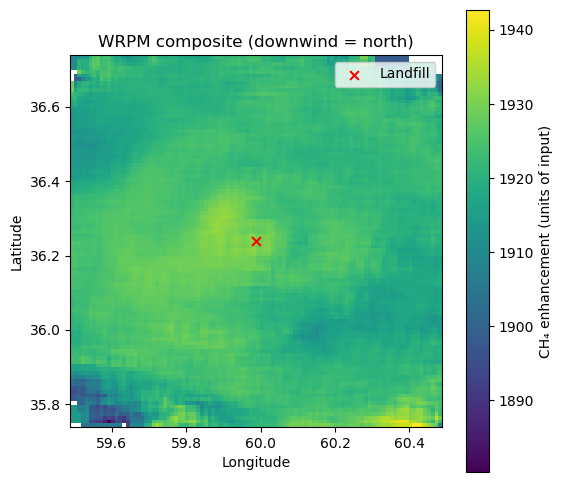

In [21]:
import rasterio, numpy as np, matplotlib.pyplot as plt

p = "wrpm_oversampled_0p01deg.tif"
with rasterio.open(p) as src:
    arr = src.read(1)
    transform = src.transform
    west, north = transform.c, transform.f
    step = transform.a
    east  = west + step*src.width
    south = north - step*src.height

print("Shape:", arr.shape, "| pixel step (deg):", step)
print("Extent (W,S,E,N):", (west, south, east, north))

plt.figure(figsize=(6,6))
plt.imshow(arr, origin="upper", extent=[west, east, south, north])
plt.colorbar(label="CH₄ enhancement (units of input)")
plt.title("WRPM composite (downwind = north)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")

# --- Mark landfill location ---
plt.scatter([src_lon], [src_lat], s=40, c="red", marker="x", label="Landfill")
plt.legend(loc="upper right")

plt.show()



## Check the rotation worked  
Verifies that after rotation the wind really does line up north, ensuring the method is correct.

In [22]:
# --- WRPM rotation sanity check (should report ~0°) ---

# use local conversion factors at the landfill
km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * np.cos(np.deg2rad(src_lat))

# build a unit downwind vector (east = sin α, north = cos α)
alpha = np.deg2rad(downwind)
x_loc = np.sin(alpha)   # east component
y_loc = np.cos(alpha)   # north component

# step 1 km along downwind, convert to lon/lat
eps_km = 1.0
dlon = (eps_km * x_loc) / km_per_deg_lon
dlat = (eps_km * y_loc) / km_per_deg_lat
test_lon = src_lon + dlon
test_lat = src_lat + dlat

# rotate coords so that downwind → north
tlon, tlat = rotate_about_source(test_lon, test_lat, src_lon, src_lat, angle_deg=downwind)

# compute bearing after rotation (0° = north)
dx = (tlon - src_lon) * km_per_deg_lon   # east offset in km
dy = (tlat - src_lat) * km_per_deg_lat   # north offset in km
bearing_after = (np.degrees(np.arctan2(dx, dy)) + 360) % 360

print(f"[WRPM check] Downwind={downwind:.1f}° → after rotation ≈ {bearing_after:.1f}° (expect ~0°)")


[WRPM check] Downwind=57.5° → after rotation ≈ 0.0° (expect ~0°)


In [23]:
# --- Plume isolation helper (percentile background + optional offset) ---

import numpy as np

def isolate_plume(ppb_grid, lat, lat0, bg_percentile=50):
    """
    Parameters
    ----------
    ppb_grid : 2D ndarray
        Single composite CH4 field in ppb (already rotated: downwind = north).
    lat : 1D or 2D ndarray
        Latitude(s) aligned to ppb_grid. If 1D, function will broadcast.
    lat0 : float
        Source latitude. 'South' (upwind) is lat < lat0.
    bg_percentile : float, default 50
        Percentile of upwind pixels to use as background (e.g., 40–70).

    Returns
    -------
    background_ppb : float
        Chosen background value in ppb.
    plume_mask : 2D bool ndarray
        True where ppb_grid > background_ppb.
    """
    # Ensure lat is 2D and aligned
    if lat.ndim == 1:
        if lat.size == ppb_grid.shape[0]:
            lat2 = np.broadcast_to(lat[:, None], ppb_grid.shape)
        elif lat.size == ppb_grid.shape[1]:
            lat2 = np.broadcast_to(lat[None, :], ppb_grid.shape)
        else:
            raise ValueError("Latitude axis length doesn't match grid dimensions.")
    else:
        lat2 = lat

    valid = np.isfinite(ppb_grid)
    upwind = (lat2 < lat0) & valid
    bg_vals = ppb_grid[upwind]
    if bg_vals.size == 0:
        raise ValueError("No valid upwind pixels south of the source to compute background.")

    background_ppb = float(np.nanpercentile(bg_vals, bg_percentile))
    plume_mask = (ppb_grid > background_ppb) & valid
    return background_ppb, plume_mask


In [24]:
# Helper: connected-plume segmentation + convex hull (CH4 Sentinel style)
import numpy as np
from shapely.geometry import Point, MultiPoint
from scipy import ndimage as ndi

def segment_connected_plume(ppb_grid, LON, LAT, src_lon, src_lat,
                            bg_percentile=95,
                            R_seed_m=1000.0, R_seed_max_m=5000.0, grow_factor=1.7,
                            do_close=True, close_radius=1):
    """
    Returns
    -------
    background_ppb : float
    plume_mask : 2D bool array (connected component grown from near-source seeds)
    hull_poly : shapely geometry or None (for plotting only)
    """
    # --- background + threshold mask (upwind percentile) ---
    background_ppb, plume_mask_all = isolate_plume(
        ppb_grid=ppb_grid, lat=LAT, lat0=src_lat, bg_percentile=bg_percentile
    )

    # --- distances from source (metres) ---
    mx = 111320.0 * np.cos(np.deg2rad(src_lat))   # m/deg lon
    my = 111320.0                                 # m/deg lat
    dx_m = (LON - src_lon) * mx
    dy_m = (LAT - src_lat) * my
    dist_m = np.hypot(dx_m, dy_m)

    # --- seed search (adaptive radius) ---
    R = float(R_seed_m)
    seed_mask = plume_mask_all & (dist_m <= R)
    while (not np.any(seed_mask)) and (R < R_seed_max_m):
        R = min(R_seed_max_m, R * grow_factor)
        seed_mask = plume_mask_all & (dist_m <= R)

    if not np.any(seed_mask):
        plume_mask = np.zeros_like(plume_mask_all, dtype=bool)
        hull_poly = None
        return background_ppb, plume_mask, hull_poly

    # --- grow connected component only within thresholded plume ---
    structure = np.ones((3,3), dtype=bool)  # 8-connected
    plume_mask = ndi.binary_propagation(seed_mask, structure=structure, mask=plume_mask_all)

    if do_close:
        plume_mask = ndi.binary_closing(plume_mask, structure=structure, iterations=close_radius).astype(bool)

    # --- convex hull for plotting (QA only) ---
    yy, xx = np.where(plume_mask)
    hull_poly = None
    if yy.size > 2:
        pts = [Point(float(LON[i, j]), float(LAT[i, j])) for i, j in zip(yy, xx)]
        # anchor hull to source so the outline includes source vicinity
        pts.append(Point(float(src_lon), float(src_lat)))
        hull_poly = MultiPoint(pts).convex_hull

    return background_ppb, plume_mask, hull_poly


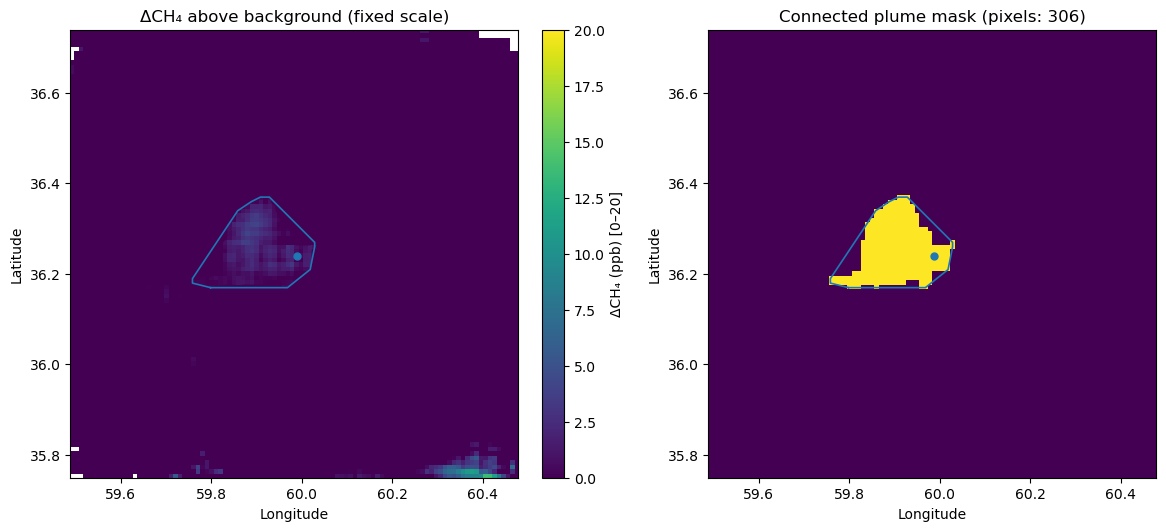

In [25]:
# Step 4.2 (Report): Pre-processing — plume isolation (connected plume + convex hull)
# Strategy (as in CH4 Sentinel): 
# 1) threshold → plume_mask_all
# 2) find seeds within R_seed of landfill
# 3) grow only the connected component(s) from those seeds inside plume_mask_all
# 4) (optional) small morphological clean-up
# 5) convex hull on the grown plume for plotting / QA

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import Point, MultiPoint
from scipy import ndimage as ndi

# ---------------- inputs / knobs ----------------
composite_path = "wrpm_oversampled_0p01deg.tif"

try:
    _ = src_lat; _ = src_lon
except NameError:
    raise NameError("Define `src_lat` and `src_lon` earlier (floats).")

bg_percentile = 95          # upwind background percentile for threshold
R_seed_m      = 1000.0      # initial radius (m) to look for seed pixels
R_seed_max_m  = 5000.0      # max radius to expand to if no seeds found
grow_factor   = 1.7         # how fast to expand seed radius when empty

# optional clean-up on grown plume
DO_CLOSE      = True
CLOSE_RADIUS  = 1           # in pixels; 1 = gentle

# fixed visual scale for enhancement
V_MIN, V_MAX  = 0.0, 20.0

# ---------------- read composite + coords ----------------
with rasterio.open(composite_path) as src:
    CH4_ppb = src.read(1).astype(float)
    t = src.transform
    ny, nx = CH4_ppb.shape
    xs = np.arange(nx); ys = np.arange(ny)
    LON = t.c + xs * t.a + ys[:, None] * t.b
    LAT = t.f + xs * t.d + ys[:, None] * t.e
    extent = (LON.min(), LON.max(), LAT.min(), LAT.max())

# ---------------- background + threshold mask ----------------
background_ppb, plume_mask_all = isolate_plume(
    ppb_grid=CH4_ppb, lat=LAT, lat0=src_lat, bg_percentile=bg_percentile
)

# ---------------- connected-grow from near-source seeds ----------------
# metres per degree at source latitude
mx = 111320.0 * np.cos(np.deg2rad(src_lat))
my = 111320.0
dx_m = (LON - src_lon) * mx
dy_m = (LAT - src_lat) * my
dist_m = np.hypot(dx_m, dy_m)

# Find seed pixels = above-background AND within R_seed of source
R = R_seed_m
seed_mask = plume_mask_all & (dist_m <= R)

# If no seeds, expand search radius until seeds found or R reaches max
while (not np.any(seed_mask)) and (R < R_seed_max_m):
    R = min(R_seed_max_m, R * grow_factor)
    seed_mask = plume_mask_all & (dist_m <= R)

# If still none, return empty plume
if not np.any(seed_mask):
    grown_plume = np.zeros_like(plume_mask_all, dtype=bool)
else:
    # 8-connected propagation restricted to plume_mask_all
    structure = np.ones((3,3), dtype=bool)  # 8-neighbourhood
    grown_plume = ndi.binary_propagation(seed_mask, structure=structure, mask=plume_mask_all)

    # optional small morphological closing to fill 1-pixel gaps
    if DO_CLOSE:
        grown_plume = ndi.binary_closing(grown_plume, structure=structure, iterations=CLOSE_RADIUS).astype(bool)

# final plume mask
plume_mask = grown_plume

# ---------------- convex hull for plotting / QA ----------------
# (Hull is only for display; analysis uses `plume_mask` pixels)
hull_poly = None
yy, xx = np.where(plume_mask)
if yy.size > 2:
    pts = [Point(float(LON[i, j]), float(LAT[i, j])) for i, j in zip(yy, xx)]
    # anchor to landfill so outline passes through the source area if plume touches it
    pts.append(Point(float(src_lon), float(src_lat)))
    hull_poly = MultiPoint(pts).convex_hull

# ---------------- visuals (fixed Δ scale + hull + mask) ----------------
delta_ppb = np.clip(CH4_ppb - background_ppb, 0, None)

fig, axes = plt.subplots(1, 2, figsize=(13, 5.2), constrained_layout=True)

# Panel A: ΔCH4 with mask contour + hull outline
ax = axes[0]
im = ax.imshow(delta_ppb, origin="upper", extent=extent, vmin=V_MIN, vmax=V_MAX)
ax.contour(LON, LAT, plume_mask.astype(int), levels=[0.5], linewidths=1.2)
if hull_poly is not None and hasattr(hull_poly, "geom_type"):
    if hull_poly.geom_type == "Polygon":
        hx, hy = hull_poly.exterior.xy
        ax.plot(hx, hy, linewidth=1.2)
    elif hull_poly.geom_type == "MultiPolygon":
        for part in hull_poly.geoms:
            hx, hy = part.exterior.xy
            ax.plot(hx, hy, linewidth=1.2)
ax.scatter([src_lon],[src_lat], s=25)
ax.set_title("ΔCH₄ above background (fixed scale)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04); cbar.set_label(f"ΔCH₄ (ppb) [0–{int(V_MAX)}]")

# Panel B: binary plume mask
ax = axes[1]
ax.imshow(plume_mask, origin="upper", extent=extent, interpolation="nearest")
if hull_poly is not None and hasattr(hull_poly, "geom_type"):
    if hull_poly.geom_type == "Polygon":
        hx, hy = hull_poly.exterior.xy
        ax.plot(hx, hy, linewidth=1.2)
    elif hull_poly.geom_type == "MultiPolygon":
        for part in hull_poly.geoms:
            hx, hy = part.exterior.xy
            ax.plot(hx, hy, linewidth=1.2)
ax.scatter([src_lon],[src_lat], s=25)
ax.set_title(f"Connected plume mask (pixels: {int(plume_mask.sum())})")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

plt.show()

# ---------------- area grid (unchanged) ----------------
R_earth   = 6371008.8
deg2rad   = np.pi / 180.0
dlon_deg  = abs(t.a)
dlat_deg  = abs(t.e)
dx_m_grid = R_earth * np.cos(np.deg2rad(LAT)) * deg2rad * dlon_deg
dy_m_grid = R_earth * deg2rad * dlat_deg
pixel_area_m2 = dx_m_grid * dy_m_grid



In [26]:
# Step 1 (Report 4.3): Above Background Methane (ABM) — area-weighted enhancement (ppb·m²)
# Equation: ΔC_j = (C_j − T) × A_j
# Output: `sum_excess_ppb_m2` (ppb·m²), plus simple diagnostics

# 1) Excess above background threshold (clip negatives to 0 if desired)
threshold = background_ppb
delta_ppb = CH4_ppb - threshold

# Simple stats inside the mask
n_pix = int(plume_mask.sum())
mean_excess_ppb = float(np.nanmean(delta_ppb[plume_mask])) if n_pix > 0 else np.nan
sum_excess_ppb  = float(np.nansum(delta_ppb[plume_mask]))  # units: ppb·pixels

print(f"[Step 1] Mask pixels: {n_pix}")
print(f"[Step 1] Mean excess: {mean_excess_ppb:.2f} ppb")
print(f"[Step 1] Sum excess (ppb·pixels): {sum_excess_ppb:.2e}")

# 2) Area-weighted sum (ppb·m²), using geodesic pixel area
sum_excess_ppb_m2 = float(np.nansum(delta_ppb[plume_mask] * pixel_area_m2[plume_mask]))  # ppb·m²
print(f"[Step 1] Area-weighted sum excess: {sum_excess_ppb_m2:.2e} ppb·m²")


[Step 1] Mask pixels: 306
[Step 1] Mean excess: 1.32 ppb
[Step 1] Sum excess (ppb·pixels): 4.04e+02
[Step 1] Area-weighted sum excess: 4.03e+08 ppb·m²


In [27]:
# Steps 2–6 (Report 4.3): Mole fraction → air column → CH4 column → IME → flux
# This block is split into clearly labelled sections. Behaviour unchanged.

# ─────────────────────────────────────────────────────────────────────────────
# Step 2: Convert ppb·m² to area-integrated mole fraction (Δχ·m²)
#   Δχ = ΔC × 1e−9  (ppb → mole fraction)
delta_chi_m2 = sum_excess_ppb_m2 * 1e-9  # mole-fraction·m² (unitless × m²)
print(f"[Step 2] Δχ·m²: {delta_chi_m2:.3e}")

# ─────────────────────────────────────────────────────────────────────────────
# Step 3: Dry-air column mass
#   Ω_air = p / g
g = 9.80665                      # m s^-2
winds = pd.read_csv("winds.csv", parse_dates=["date"])
p_eff_pa = float(winds["surface_pressure_pa"].median())  # or .mean()
omega_air = p_eff_pa / g         # kg m^-2
print(f"[Step 3] Ω_air: {omega_air:.2f} kg/m²")

# ─────────────────────────────────────────────────────────────────────────────
# Step 4: Scale to methane column mass (area-integrated)
#   ΔΩ_CH4 = Δχ · Ω_air · (M_CH4 / M_air)
M_ratio = 16.04 / 28.97          # M_CH4 / M_air ≈ 0.554
delta_omega_ch4_kg = delta_chi_m2 * omega_air * M_ratio  # kg
print(f"[Step 4] ΔΩ_CH4 (kg): {delta_omega_ch4_kg:.3e}")

# ─────────────────────────────────────────────────────────────────────────────
# Step 5: Integrated Mass Enhancement (IME)
IME_kg = delta_omega_ch4_kg      # already integrated over area by construction
print(f"[Step 5] IME: {IME_kg:.3e} kg")

# ─────────────────────────────────────────────────────────────────────────────
# Step 6: Emission rate (flux)
#   Q = (U_eff / L_eff) · IME
# L_eff from plume mask area (same mask as Step 1)
mask_area_m2 = float(np.nansum(pixel_area_m2[plume_mask]))
L_eff_m = np.sqrt(mask_area_m2)  # L_eff = sqrt(area)

U_bar = float(winds["wind_speed_mps"].median())
Q_kg_s = (U_bar / L_eff_m) * IME_kg

Q_t_per_hour = Q_kg_s * 3600 / 1000
Q_t_per_day  = Q_kg_s * 86400 / 1000
Q_t_per_year = Q_kg_s * 31556952 / 1000  

print(f"[Step 6] Mask area: {mask_area_m2:.3e} m², L_eff: {L_eff_m:.0f} m, U: {U_bar:.2f} m/s")
print(f"[Step 6] Q ≈ {Q_t_per_hour:.3f} t/h  |  {Q_t_per_day:.3f} t/day  |  {Q_t_per_year:.1f} t/yr")



[Step 2] Δχ·m²: 4.031e-01
[Step 3] Ω_air: 9107.95 kg/m²
[Step 4] ΔΩ_CH4 (kg): 2.033e+03
[Step 5] IME: 2.033e+03 kg
[Step 6] Mask area: 3.051e+08 m², L_eff: 17467 m, U: 3.85 m/s
[Step 6] Q ≈ 1.613 t/h  |  38.714 t/day  |  14140.0 t/yr
